# Setting

## Library

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import random
import os
from tqdm.notebook import tqdm

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [5]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score # 정확도
from sklearn.metrics import precision_score # 정밀도
from sklearn.metrics import recall_score # 재현율
from sklearn.metrics import f1_score # F1-Score
from sklearn.metrics import confusion_matrix

## Seed

In [6]:
def my_seed_everywhere(seed):
    random.seed(seed) # random
    np.random.seed(seed) # numpy
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    print(f'고정된 Seed : {seed}')

In [7]:
my_seed_everywhere(42)

고정된 Seed : 42


# Data Set

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
path_file = '/content/drive/MyDrive/UNIST/AICP/data/dynmom_dat.csv'

df = pd.read_csv(path_file)

# Preprocessing

In [79]:
def preprocessing(data, used=None):
  # 'DATE'를 칼럼 대신 인덱스로 사용
  data.index = data['DATE']
  data = data.drop(columns='DATE')
  print("'DATE'를 칼럼 대신 인덱스로 사용")

  # 결측치 제거 및 모델 학습에 불필요한 칼럼 제거
  data = data.dropna()
  data = data.drop(columns=['winner', 'loser', 'form_date'])
  print("결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')")

  if used != None:
    used += ['wml']
    D = ', '.join(used)
    data = data[used]
    print(f"훈련에 사용되는 변수 들 : {D}")

  return data

In [80]:
df = preprocessing(df,
                   used=['cum_loser_t_2_4', 'cum_loser_t_5_8', 'cum_loser_t_9_12'])

'DATE'를 칼럼 대신 인덱스로 사용
결측치 제거 및 모델 학습에 불필요한 칼럼 제거 ('winner', 'loser', 'form_date')
훈련에 사용되는 변수 들 : cum_loser_t_2_4, cum_loser_t_5_8, cum_loser_t_9_12, wml


In [81]:
def normal_wml(df):
  print("'wml'이 양수면 1 & 음수면 0")
  print("Output : 'Preprocessed_Data' & 'WML'")
  print()

  cond_wml = (df['wml']>=0)
  df.loc[cond_wml, 'pos_wml'] = 1
  df.loc[~cond_wml, 'pos_wml'] = 0
  WML = df[['wml']]

  df.drop(columns=['wml'], inplace=True)

  POS_WML = df['pos_wml'].value_counts()
  print(f'Ratio : {POS_WML[0]/POS_WML[1]}')
  print(POS_WML)

  return df, WML

In [82]:
dynmom, WML = normal_wml(df)

'wml'이 양수면 1 & 음수면 0
Output : 'Preprocessed_Data' & 'WML'

Ratio : 0.5634379263301501
1.0    733
0.0    413
Name: pos_wml, dtype: int64


# Modeling

In [83]:
def Roling_Windows(data, window_size, method, model, model_name, plot=True, plot_feature=True):

  # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
  result_dict = {
    'TRAIN_START_DATE':[],
    'TRAIN_END_DATE':[],
    'TEST_DATE':[],
    'Actual_POS_WML':[],
    f'{model_name}_PRED_POS_WML':[],
    f'{model_name}_PROB_POS_WML':[]
  }

  df_feature = pd.DataFrame()

  # 모델 학습이 종료되는 지점 설정
  end = data.shape[0] - window_size

  print('*'*50)
  print(f'\n{model_name} Model의 Rolling {method} Window를 실행합니다\n')
  print('설정된 Model의 하이퍼파리미터 : \n')
  for p, v in zip(model.get_params(deep=True).keys(), model.get_params(deep=True).values()):
    print(f'   {p} : {v}')
  print()
  print('*'*50)

  for i in tqdm(range(end)):

    # 모델 학습 중지
    if i == end:
      print('Prediction using machine learning has ended.')
      break
    
    # Rolling Fixed Window
    if method == 'Fixed':
      MODEL = model
      train = data.iloc[0+i:window_size+i]

    # Rolling Expanding Window
    elif method == 'Expanding':
      MODEL = model
      train = data.iloc[0:window_size+i]
    
    # 'method' 잘못입력한 경우
    else:
      print("Make sure to set the method to either 'Fixed' or 'Expanding'.")
      break
    
    # 테스트 데이터 설정
    test = data.iloc[[window_size+i]]

    # Features와 Target 구분
    X_train = train.drop(columns=['pos_wml'])
    y_train = train['pos_wml']

    X_test = test.drop(columns=['pos_wml'])
    y_test = test['pos_wml'] 

    # 모델 학습 및 추론
    MODEL.fit(X_train, y_train)
    pred_test = MODEL.predict(X_test)
    prob_test = MODEL.predict_proba(X_test)

    # 학습 및 테스트 데이터 정보 & 실제값과 예측값 정보 수집
    result_dict['TRAIN_START_DATE'].append(train.index[0])
    result_dict['TRAIN_END_DATE'].append(train.index[-1])
    result_dict['TEST_DATE'].append(test.index[0])

    result_dict['Actual_POS_WML'].append(list(y_test)[0])
    result_dict[f'{model_name}_PRED_POS_WML'].append(pred_test[0])
    result_dict[f'{model_name}_PROB_POS_WML'].append(prob_test[0][-1])

    # 트리 기반 모델 (사이킷런)의 Feature Importance 정보 수집
    feature_importances = MODEL.feature_importances_
    df_ft_importance = pd.DataFrame(feature_importances, index = X_train.columns).T
    df_ft_importance.index = y_test.index
    df_feature = pd.concat([df_feature, df_ft_importance])

  result = pd.DataFrame(result_dict)
  result.index = df_feature.index

  result = pd.concat([result, df_feature], axis=1)
  result = result.set_index('TEST_DATE')
  
  # 모델 성능 시각화
  if plot == True:
    plot_result(result, method, model_name)
  
  # 모델의 변수 중요도 시각화
  if plot_feature == True:
    plot_feature_importances(result, model_name)
    print()

  # 학습 및 테스트 데이터 정보, 실제값과 예측값 정보, 변수 중요도 정보
  return result

In [84]:
def plot_result(data, method, model_name):
  print('\nPerformance results of the model\n')

  # Confusion Matrix & etc
  print(classification_report(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML']))

  # Accuracy, Precision, Recall, F1 Score
  accuracy = accuracy_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  precision = precision_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  recall = recall_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  F1_score = f1_score(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])

  print(f'\naccuracy : {accuracy}')
  print(f'\nprecision : {precision}')
  print(f'\nrecall : {recall}')
  print(f'\nF1-Score : {F1_score}\n')
  
  # Visualization Confusion Matrix
  confusion = confusion_matrix(data['Actual_POS_WML'], data[f'{model_name}_PRED_POS_WML'])
  sns.heatmap(confusion, annot=True, fmt='g')
  plt.title(f'Performance results {method} of the {model_name} model')
  
  plt.show()

In [85]:
def plot_feature_importances(data, model_name):

  data = data.drop(columns=['TRAIN_START_DATE', 'TRAIN_END_DATE', 'Actual_POS_WML',
                           f'{model_name}_PRED_POS_WML', f'{model_name}_PROB_POS_WML'])

  print('\nFeature Importance of the model\n')

  # 날짜 별 Feature Importance 변화 추이
  plt.figure(figsize=(15, 5))
  for col in data.columns:

    sns.lineplot(data=data,
                x=data.index,
                y=col,
                label=col,
                alpha=0.3)
    
    plt.title('Feature importances using MDI')
    plt.xlabel('DATE')
    plt.ylabel('Mean decrease in impurity')
    plt.xticks([data.index[i] for i in range(0,len(data.index), 12)])
    plt.tick_params(axis='x',
                      direction='out',
                      labelrotation=45,
                      length=1,
                      pad=10,
                      labelsize=5,
                      width=0.1)
  plt.show()

  # 각 변수 별 Feature Importance 통계값
  MEAN = display_feature_importance(data, method='mean')
  MAX = display_feature_importance(data, method='max')
  MIN = display_feature_importance(data, method='min')

  plt.figure(figsize=(15, 5))
  sns.barplot(data=MEAN,
              y=MEAN.index,
              x='mean_Feature_Importance')

  plt.show()
  print()

  FEATURE_IMPORTANCE = pd.concat([MEAN, MAX, MIN], axis=1)
  display(FEATURE_IMPORTANCE)

In [86]:
def display_feature_importance(data, method):
       
    feature_dict = {}
    for col in data.columns:
      if method=='mean':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].mean())

      if method=='max':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].max())
      
      if method=='min':
        feature_dict[col]=[]
        feature_dict[col].append(data[col].min())
    
    feature_df = pd.DataFrame(feature_dict).T
    feature_df.columns = [method+'_'+'Feature_Importance']
    feature_df=feature_df.sort_values(by=method+'_'+'Feature_Importance', ascending=False)

    return feature_df

In [87]:
def slice_feature_importance(data, num, method, model_name):

  if type(num) != bool:
    division = int(data.shape[0]/num)
    
    for i in range(num):

      if i == num-1:
        sliced_data = data.iloc[i*division:]

      else:
        sliced_data = data.iloc[i*division:(i+1)*division]

      start = sliced_data.index[0]
      end = sliced_data.index[-1]

      print()
      print('*'*50)
      print(f'\nDATE : {start} ~ {end}\n')
      print('*'*50)
      print()
      
      plot_result(sliced_data, method, model_name)
      plot_feature_importances(sliced_data, model_name)
  
  else:
    start = input('Start Date (ex: 20200131): ')
    end = input('Start Date (ex: 20221230): ')
    print('*'*50)
    print(f'\nDate : {start} ~ {end}\n')
    print('*'*50)
    print()

    sliced_data = data.loc[start:end]
    plot_result(sliced_data, method, model_name)
    plot_feature_importances(sliced_data)

In [88]:
def cumm_return_by_dynamic(data, wml, weight, A0_P1, A1_P0,  plot=True):

  start_index = data.index[0]
  wml = wml.loc[start_index:]

  df = pd.DataFrame(wml['wml'] * data[weight])
  df.columns = ['cum_return']
  df['cum_return'] = (1 + df.cum_return).cumprod() - 1 
  
  S = df['cum_return'].mean()/df['cum_return'].std()

  print('Sharpe Ratio : {:0.5f}\n'.format(S))

  print('최근 누적 수익률\n')
  latly_10 = df.sort_index(ascending=False).head(5)
  for i, r in zip(latly_10.index, latly_10['cum_return']):
    i = str(i)
    print('  {}년-{}월 -> {:0.2f}'.format(i[:4], i[4:6], r))

  print('\n누적 수익률 가장 높았던 순간 Top 10\n')
  top_10 = df.sort_values(by='cum_return', ascending=False).head(10)
  rank = 1
  for i, r in zip(top_10.index, top_10['cum_return']):
    i = str(i)
    print('  {}등 : {}년-{}월 -> {:0.2f}'.format(rank, i[:4], i[4:6], r))
    rank += 1
  print()

  TEST_WML = wml.copy()
  TEST_WML['wml'] = (1 + TEST_WML.wml).cumprod() - 1
  TEST_WML.columns = ['cum_return'] 

  if plot == True:

    plt.figure(figsize=(13, 6))
    sns.lineplot(data=df, x=df.index, y=df['cum_return'], label='With_ML')
    sns.lineplot(data=TEST_WML, x=TEST_WML.index, y=TEST_WML['cum_return'], label='Original')
    plt.xticks([df.index[i] for i in range(0,len(df.index), 12)])
    plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=5,
                    width=5)
    for i in A0_P1:
      plt.vlines(i, -80000, 0, color='pink', linewidth=0.4, alpha=1)

    for i in A1_P0:
      plt.vlines(i, 80000, 0, color='pink', linewidth=0.4, alpha=1)

    plt.legend(fontsize=10)
    plt.show() 

  return df

In [89]:
def What_Pred(data, WML, model_name):

  start_index = data.index[0]
  WML = WML.loc[start_index:]
  WML.index.name = 'TEST_DATE'

  Q1 = WML.quantile(0.25)
  Q3 = WML.quantile(0.75)
  IQR = Q3 - Q1

  Upper = Q3 + (1.5*IQR)
  Lower = Q1 - (1.5*IQR)

  print('\nIQR 기준 WML 이상치 (Maximum 미만) 개수\n')

  cond_U = (WML['wml']>Upper[0])  
  WML_U = WML.loc[cond_U]
  
  print(f'Number of Outlier by IQR (Maximum) : {WML_U.shape[0]}')
  print(f'Maximum by IQR : {Upper[0]}')
  print(f"Max Outlier : {WML_U['wml'].max()}")
  print(f"Min Outlier : {WML_U['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_1 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_1 = Result.loc[cond_1]
  print('\nACTUAL = PRED = 1\n')
  sns.boxplot(data=R_1, x='wml')
  plt.show()
  display(R_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  print('\nIQR 기준 WML 이상치 (Minimum 미만) 개수\n')

  cond_L = (WML['wml']<Lower[0])  
  WML_L = WML.loc[cond_L]
  
  print(f'Number of Outlier by IQR (Minimum) : {WML_L.shape[0]}')
  print(f'Minimun by IQR : {Lower[0]}')
  print(f"Max Outlier : {WML_L['wml'].max()}")
  print(f"Min Outlier : {WML_L['wml'].min()}")

  Result = pd.concat([data, WML],axis=1)
  Result = Result[['Actual_POS_WML', f'{model_name}_PRED_POS_WML', 'wml']]

  cond_0 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_0 = Result.loc[cond_0]
  print('\nACTUAL = PRED = 0\n')
  sns.boxplot(data=R_0, x='wml')
  plt.show()
  display(R_0[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_0_1 = (Result['Actual_POS_WML'] == 0) & (Result[f'{model_name}_PRED_POS_WML'] == 1)
  R_0_1 = Result.loc[cond_0_1]
  print('\nACTUAL = 0 &  PRED = 1\n')
  sns.boxplot(data=R_0_1, x='wml')
  plt.show()
  sns.barplot(data=R_0_1.sort_values(by='wml', ascending=True), x=R_0_1.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_0_1[['wml']].describe().T)

  print()
  print('-'*80)
  print()

  cond_1_0 = (Result['Actual_POS_WML'] == 1) & (Result[f'{model_name}_PRED_POS_WML'] == 0)
  R_1_0 = Result.loc[cond_1_0]
  print('\nACTUAL = 1 &  PRED = 0\n')
  sns.boxplot(data=R_1_0, x='wml')
  plt.show()
  sns.barplot(data=R_1_0.sort_values(by='wml', ascending=True), x=R_1_0.index, y='wml')
  plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,        
    labelbottom=False)
  plt.show()
  display(R_1_0[['wml']].describe().T)

  return list(R_0_1.index), list(R_1_0.index)

In [90]:
dynmom.columns

Index(['cum_loser_t_2_4', 'cum_loser_t_5_8', 'cum_loser_t_9_12', 'pos_wml'], dtype='object')

## Rolling Fixed Windows

### Random Forest

In [91]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.17      0.22       316
         1.0       0.64      0.79      0.71       590

    accuracy                           0.57       906
   macro avg       0.47      0.48      0.46       906
weighted avg       0.52      0.57      0.54       906


accuracy : 0.5728476821192053

precision : 0.6396148555708391

recall : 0.788135593220339

F1-Score : 0.7061503416856492



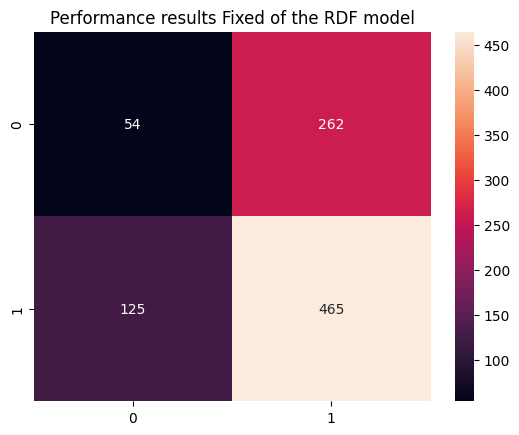


Feature Importance of the model



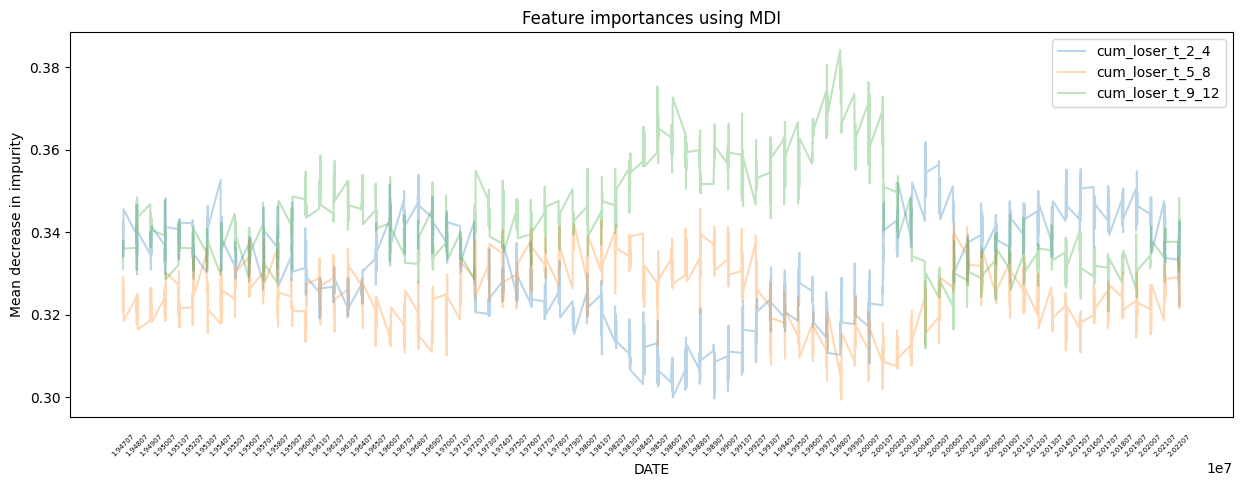

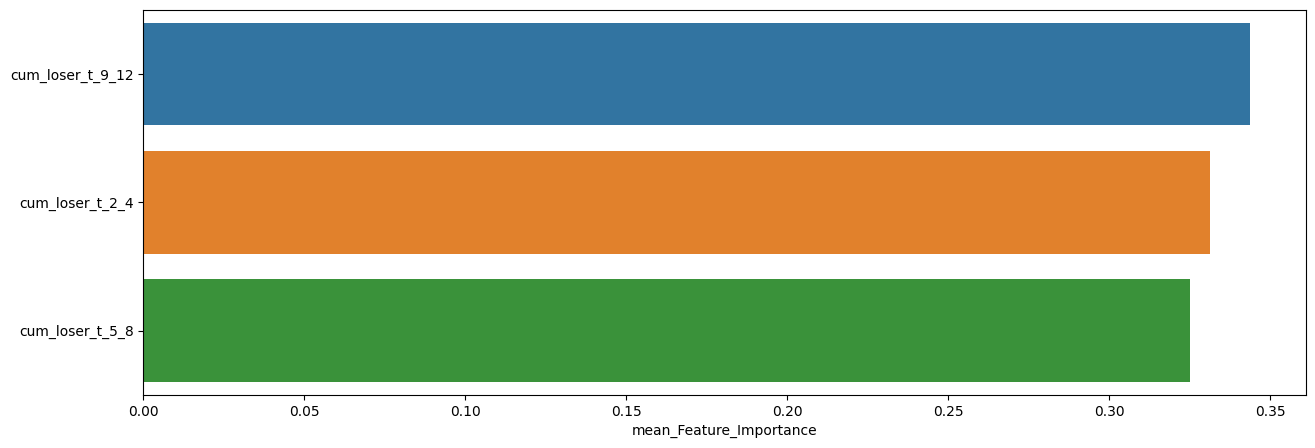

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.343822                0.384235   
cum_loser_t_2_4                  0.331199                0.361818   
cum_loser_t_5_8                  0.324978                0.345721   

                  min_Feature_Importance  
cum_loser_t_9_12                0.311767  
cum_loser_t_2_4                 0.299639  
cum_loser_t_5_8                 0.299336

In [92]:
Fixed_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=RDF, # 사용할 모델
                                  model_name='RDF', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.24      0.27        75
         1.0       0.66      0.74      0.70       151

    accuracy                           0.57       226
   macro avg       0.49      0.49      0.48       226
weighted avg       0.54      0.57      0.55       226


accuracy : 0.5707964601769911

precision : 0.6607142857142857

recall : 0.7350993377483444

F1-Score : 0.6959247648902821



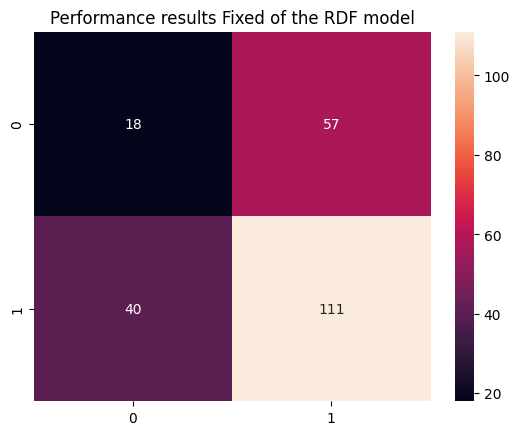


Feature Importance of the model



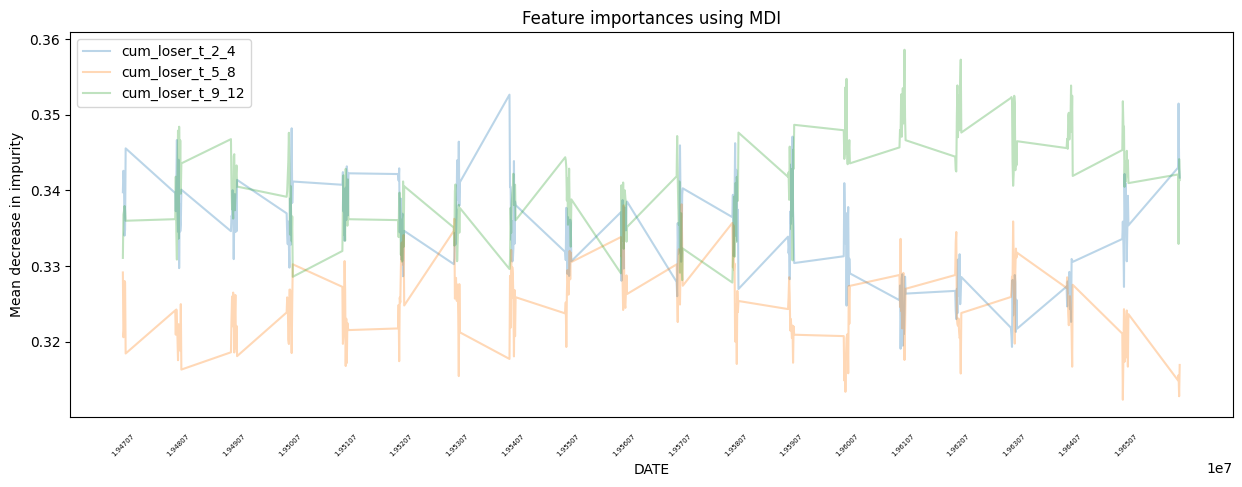

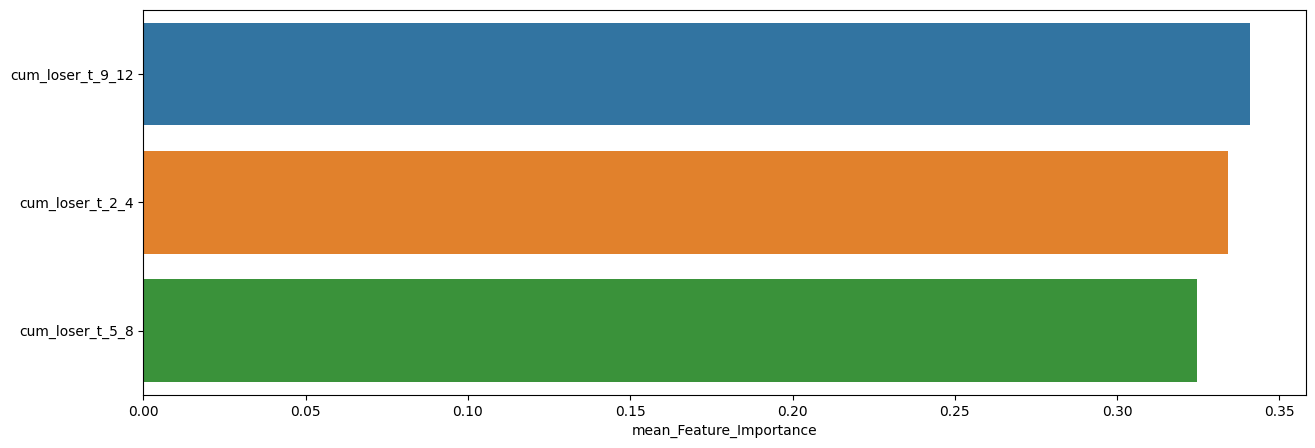

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.341078                0.358582   
cum_loser_t_2_4                  0.334211                0.352647   
cum_loser_t_5_8                  0.324711                0.338162   

                  min_Feature_Importance  
cum_loser_t_9_12                0.327825  
cum_loser_t_2_4                 0.319086  
cum_loser_t_5_8                 0.312345


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.17      0.22        75
         1.0       0.66      0.81      0.73       151

    accuracy                           0.60       226
   macro avg       0.49      0.49      0.48       226
weighted avg       0.55      0.60      0.56       226


accuracy : 0.6017699115044248

precision : 0.6648648648648648

recall : 0.8145695364238411

F1-Score : 0.7321428571428572



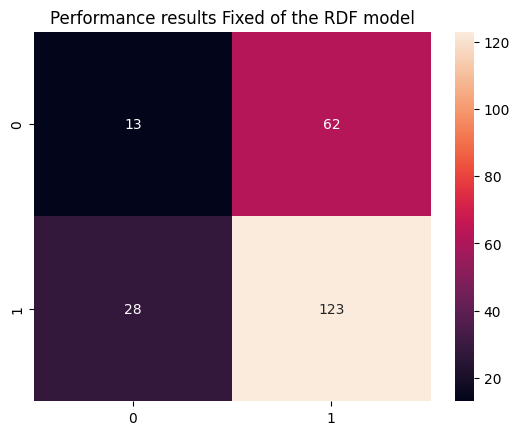


Feature Importance of the model



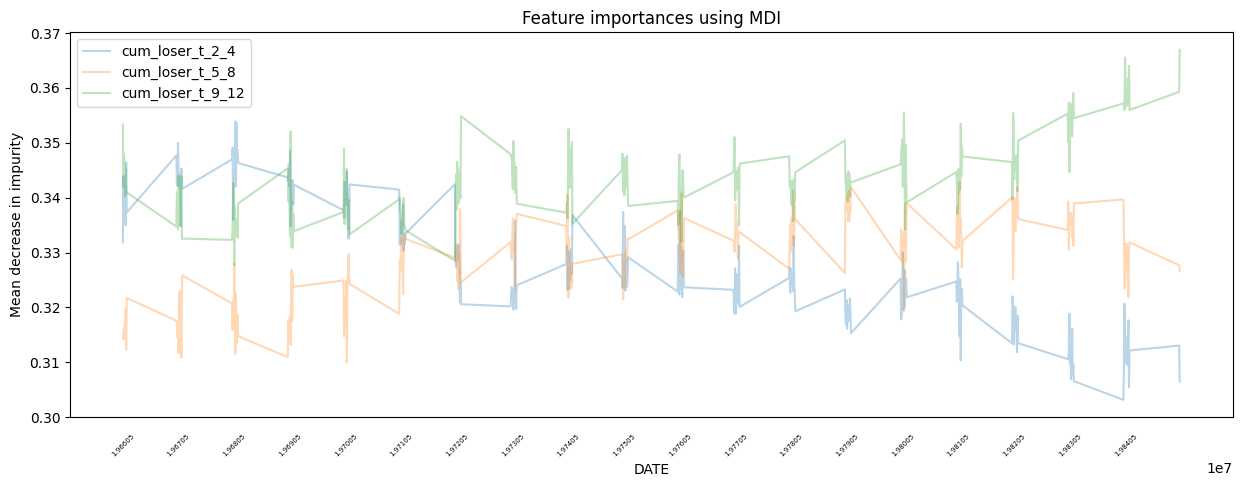

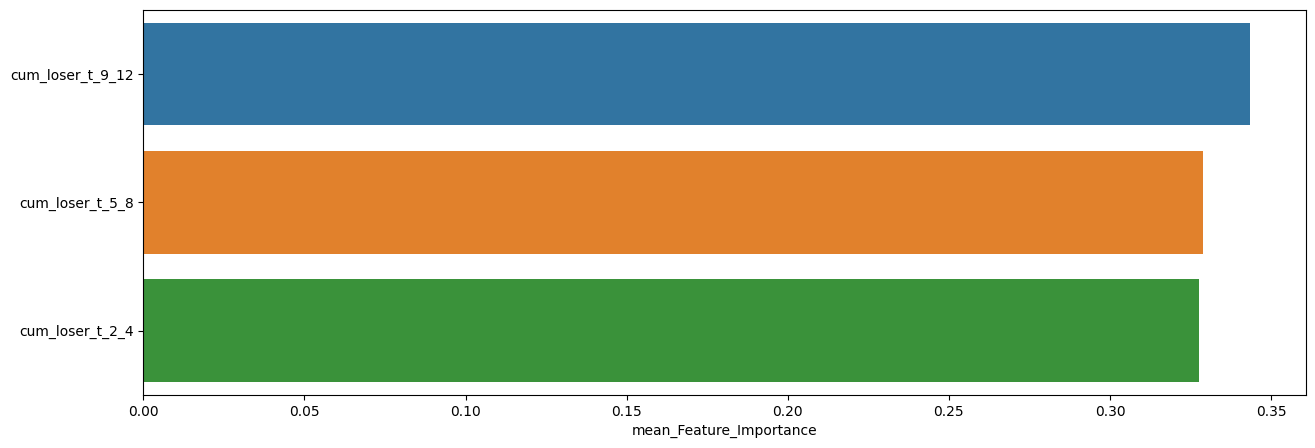

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.343584                0.366954   
cum_loser_t_5_8                  0.328877                0.342788   
cum_loser_t_2_4                  0.327540                0.353919   

                  min_Feature_Importance  
cum_loser_t_9_12                0.327704  
cum_loser_t_5_8                 0.310017  
cum_loser_t_2_4                 0.303149


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.25      0.09      0.13        70
         1.0       0.68      0.88      0.77       156

    accuracy                           0.64       226
   macro avg       0.47      0.49      0.45       226
weighted avg       0.55      0.64      0.57       226


accuracy : 0.6371681415929203

precision : 0.6831683168316832

recall : 0.8846153846153846

F1-Score : 0.7709497206703911



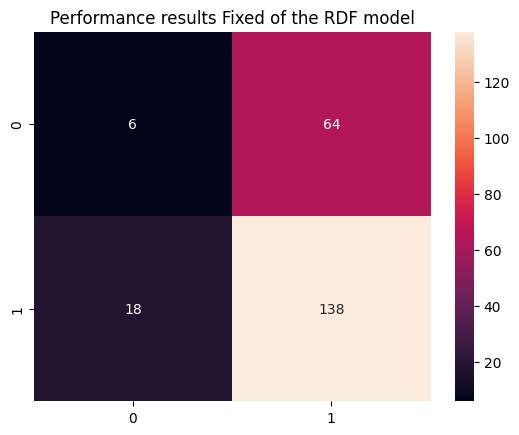


Feature Importance of the model



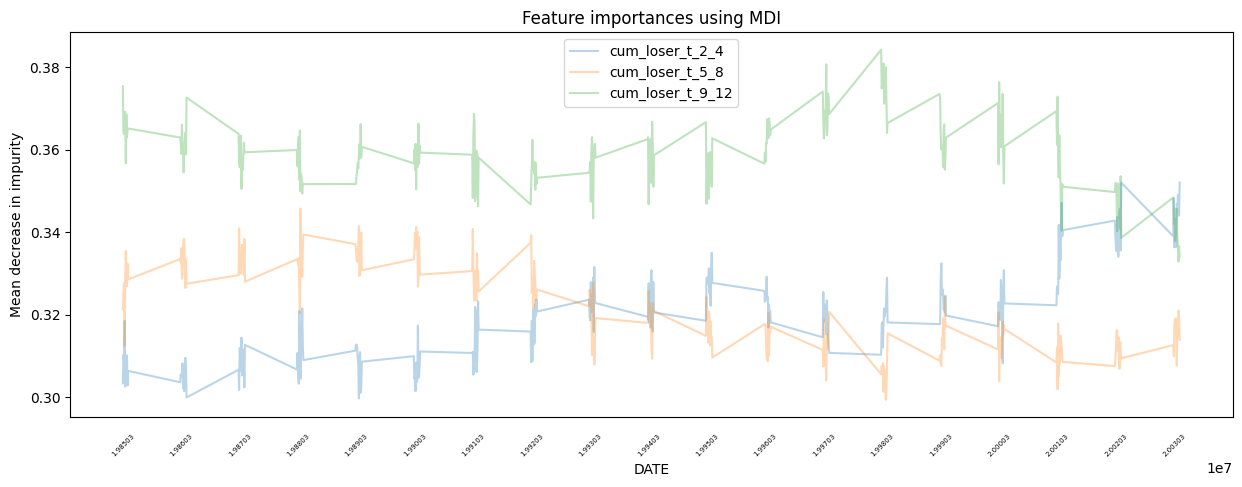

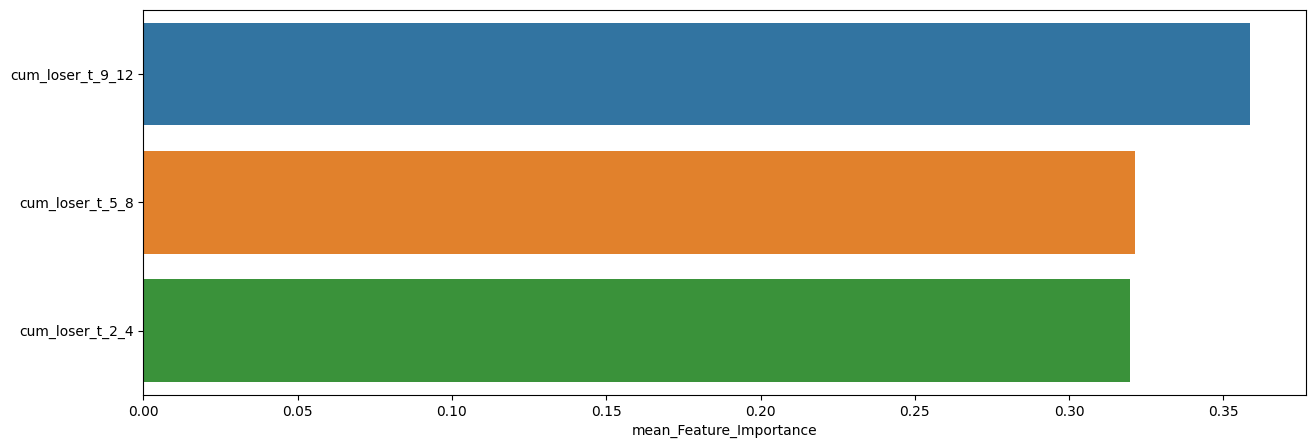

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.358780                0.384235   
cum_loser_t_5_8                  0.321350                0.345721   
cum_loser_t_2_4                  0.319871                0.352024   

                  min_Feature_Importance  
cum_loser_t_9_12                0.332851  
cum_loser_t_5_8                 0.299336  
cum_loser_t_2_4                 0.299639


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.18      0.22        96
         1.0       0.54      0.70      0.61       132

    accuracy                           0.48       228
   macro avg       0.42      0.44      0.42       228
weighted avg       0.44      0.48      0.45       228


accuracy : 0.4824561403508772

precision : 0.5406976744186046

recall : 0.7045454545454546

F1-Score : 0.6118421052631577



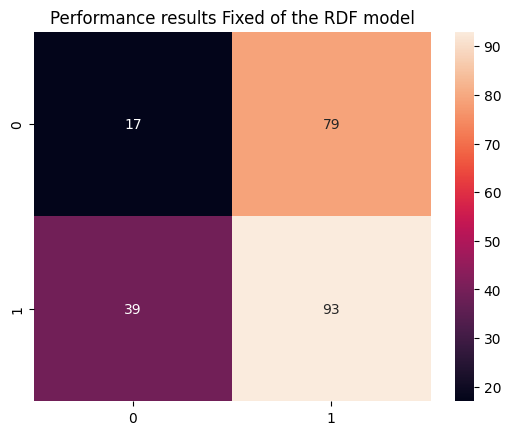


Feature Importance of the model



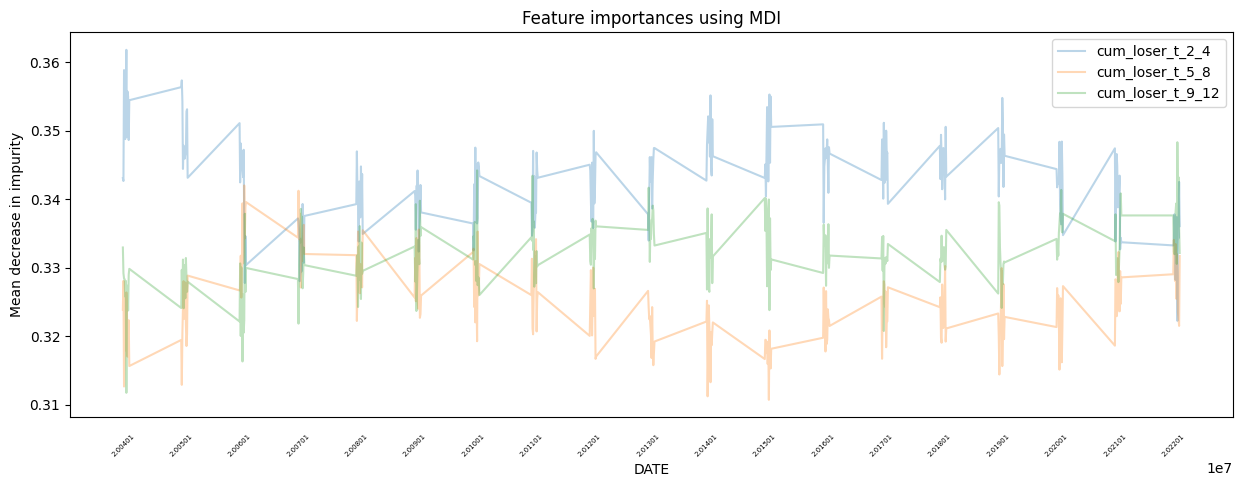

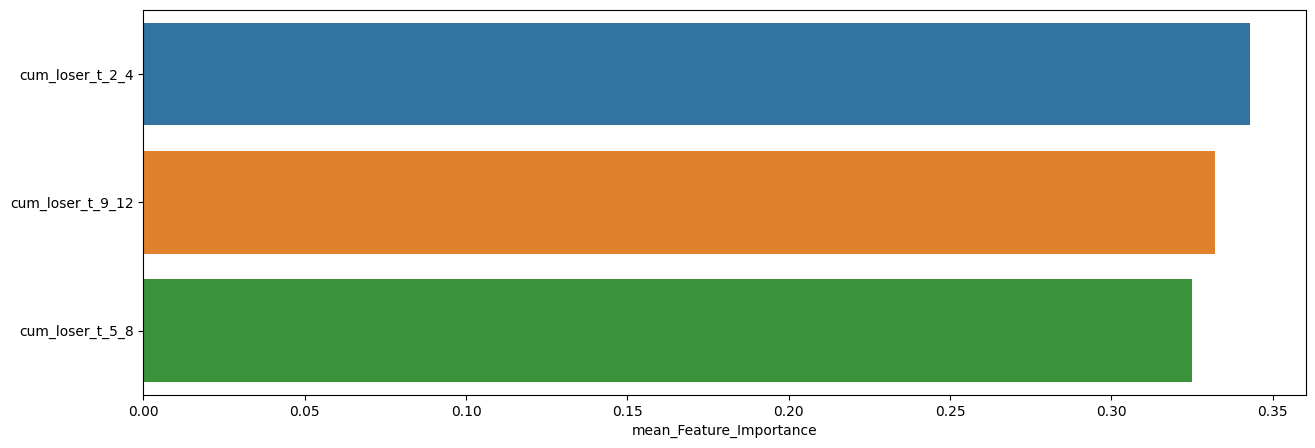

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                  0.343071                0.361818   
cum_loser_t_9_12                 0.331953                0.348333   
cum_loser_t_5_8                  0.324975                0.342028   

                  min_Feature_Importance  
cum_loser_t_2_4                 0.322274  
cum_loser_t_9_12                0.311767  
cum_loser_t_5_8                 0.310744

In [93]:
slice_feature_importance(Fixed_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



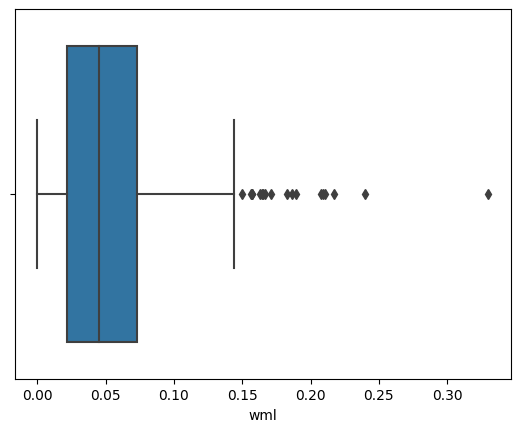

count      mean      std       min       25%       50%       75%  \
wml  465.0  0.053202  0.04325  0.000007  0.021964  0.045201  0.072663   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



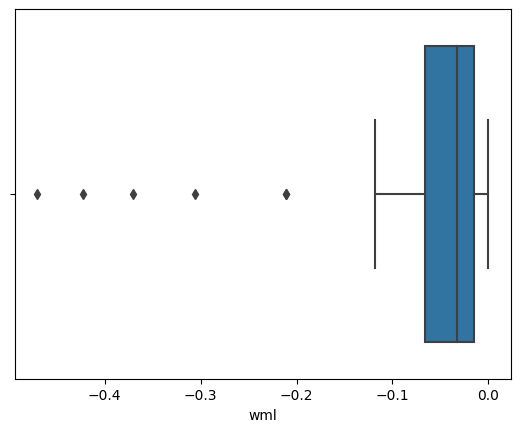

count      mean       std       min       25%       50%       75%  \
wml   54.0 -0.069968  0.102965 -0.469903 -0.066043 -0.032684 -0.014956   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



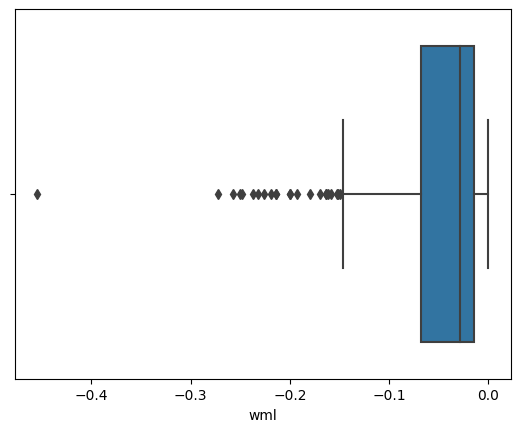

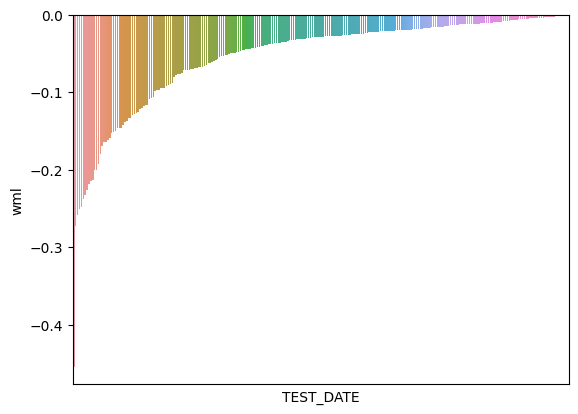

count      mean       std       min       25%       50%       75%  \
wml  262.0 -0.053496  0.062649 -0.454349 -0.068209 -0.028415 -0.014428   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



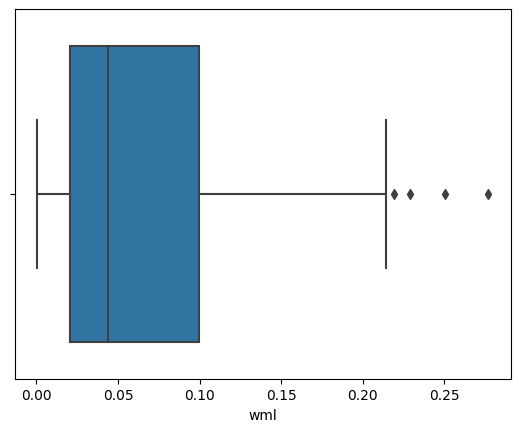

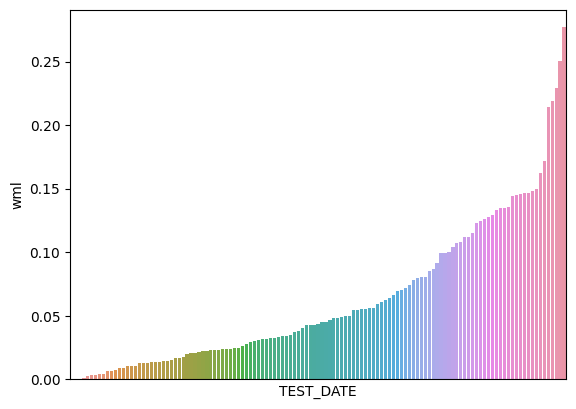

count      mean       std       min       25%       50%       75%  \
wml  125.0  0.062867  0.057747  0.000627  0.020642  0.043713  0.099468   

          max  
wml  0.276912

In [94]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Fixed_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.73644

최근 누적 수익률

  2022년-12월 -> 5853.09
  2022년-11월 -> 5273.44
  2022년-10월 -> 5016.10
  2022년-09월 -> 5016.10
  2022년-08월 -> 5016.10

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 14853.86
  2등 : 2018년-12월 -> 14701.63
  3등 : 2001년-09월 -> 14549.59
  4등 : 2003년-02월 -> 14267.03
  5등 : 2003년-03월 -> 14064.38
  6등 : 2018년-11월 -> 13902.32
  7등 : 2009년-03월 -> 13876.92
  8등 : 2009년-02월 -> 13876.92
  9등 : 2009년-01월 -> 13876.92
  10등 : 2002년-12월 -> 13856.75



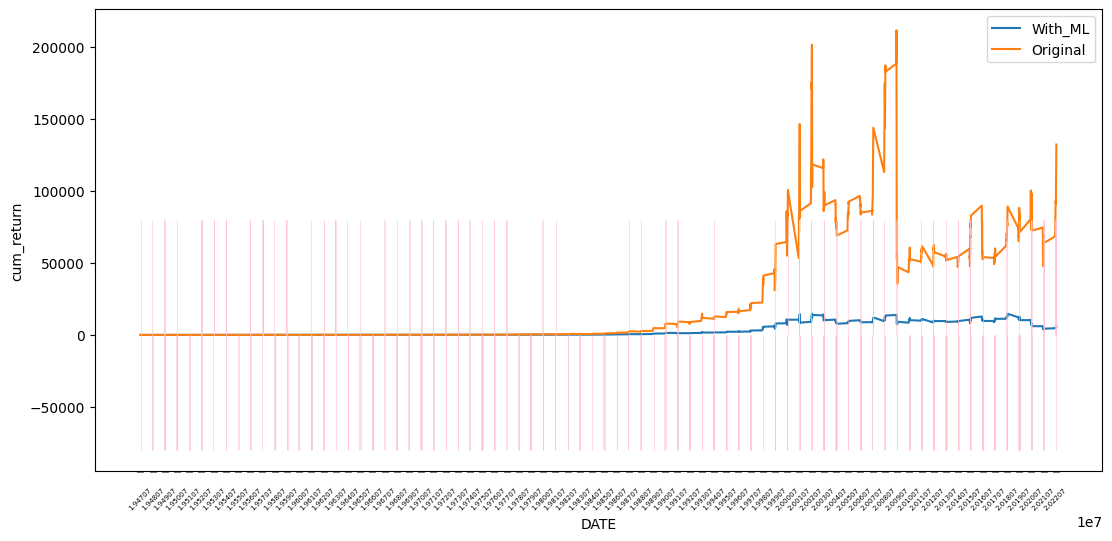

In [95]:
RDF_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.74506

최근 누적 수익률

  2022년-12월 -> 5427.76
  2022년-11월 -> 4934.19
  2022년-10월 -> 4728.02
  2022년-09월 -> 4523.24
  2022년-08월 -> 4324.41

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 7200.59
  2등 : 2002년-09월 -> 6954.04
  3등 : 2009년-01월 -> 6791.07
  4등 : 2008년-11월 -> 6742.19
  5등 : 2008년-12월 -> 6667.17
  6등 : 2008년-06월 -> 6359.47
  7등 : 2002년-07월 -> 6312.15
  8등 : 2008년-10월 -> 6292.35
  9등 : 2002년-08월 -> 6145.71
  10등 : 2002년-06월 -> 6108.29



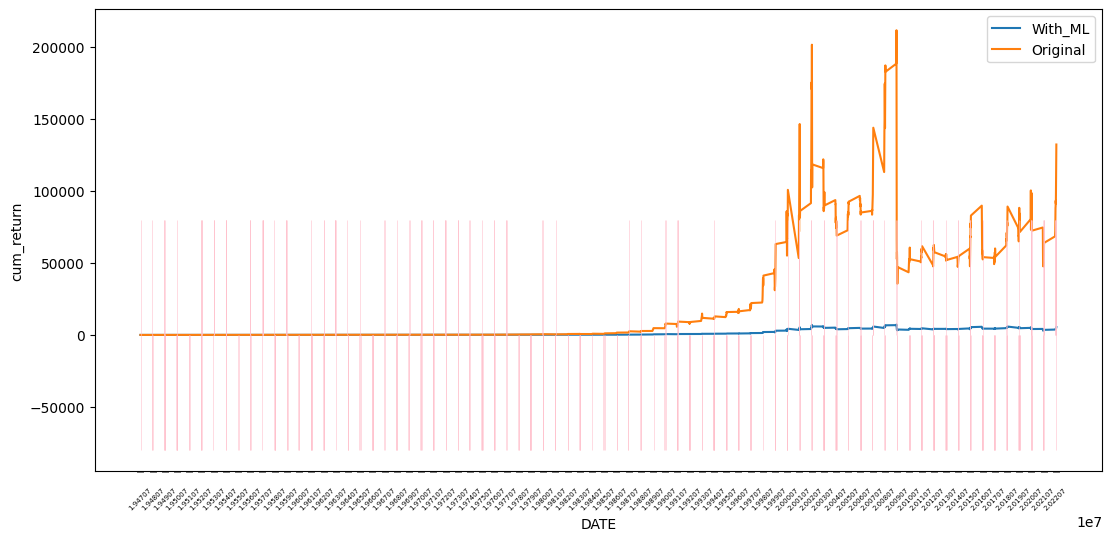

In [96]:
RDF_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [97]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.23      0.28       316
         1.0       0.66      0.80      0.72       590

    accuracy                           0.60       906
   macro avg       0.52      0.51      0.50       906
weighted avg       0.56      0.60      0.57       906


accuracy : 0.6004415011037527

precision : 0.659217877094972

recall : 0.8

F1-Score : 0.7228177641653906



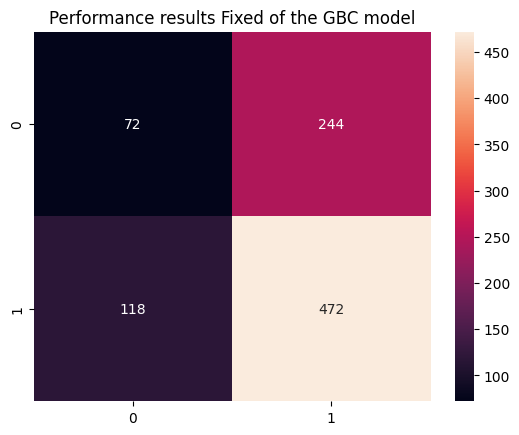


Feature Importance of the model



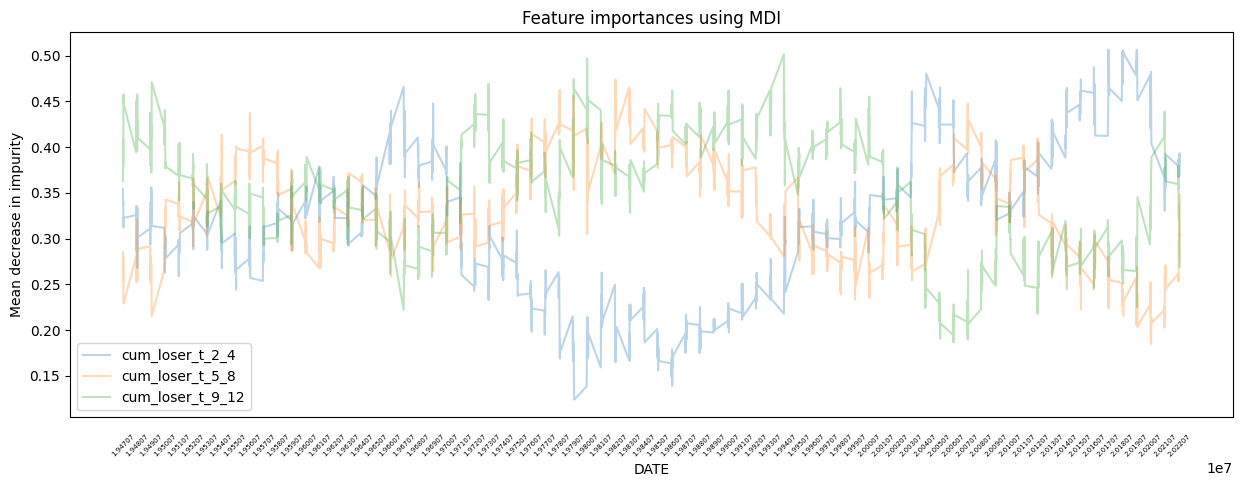

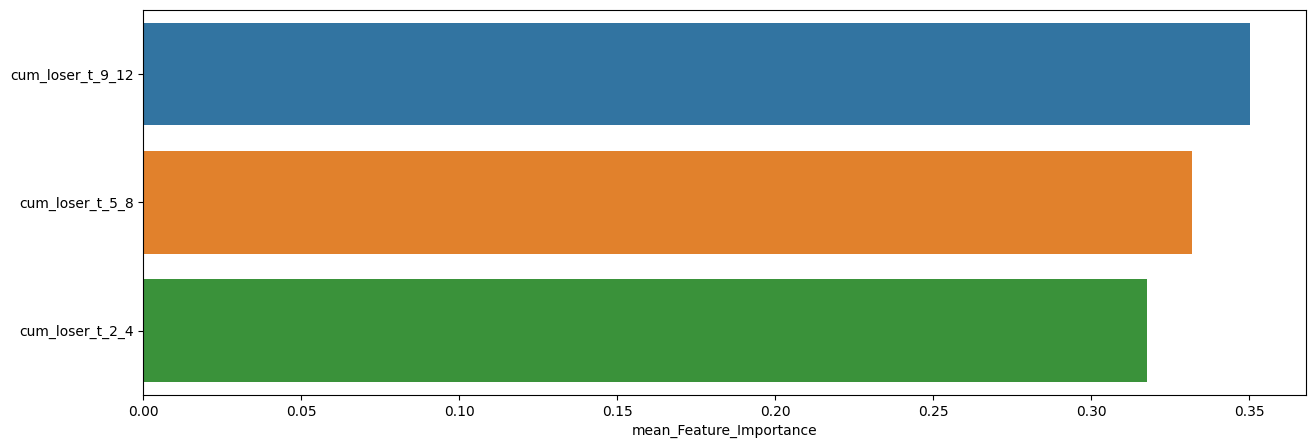

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.350390                0.501341   
cum_loser_t_5_8                  0.331934                0.473792   
cum_loser_t_2_4                  0.317676                0.506360   

                  min_Feature_Importance  
cum_loser_t_9_12                0.186720  
cum_loser_t_5_8                 0.184758  
cum_loser_t_2_4                 0.123876

In [98]:
Fixed_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=GBC, # 사용할 모델
                                  model_name='GBC', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.27      0.31        75
         1.0       0.68      0.78      0.73       151

    accuracy                           0.61       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.61      0.59       226


accuracy : 0.6106194690265486

precision : 0.6820809248554913

recall : 0.7814569536423841

F1-Score : 0.7283950617283951



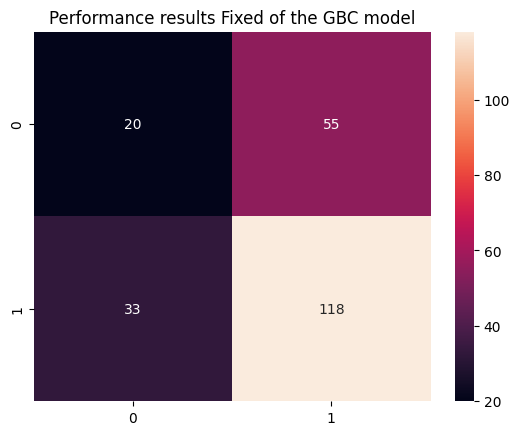


Feature Importance of the model



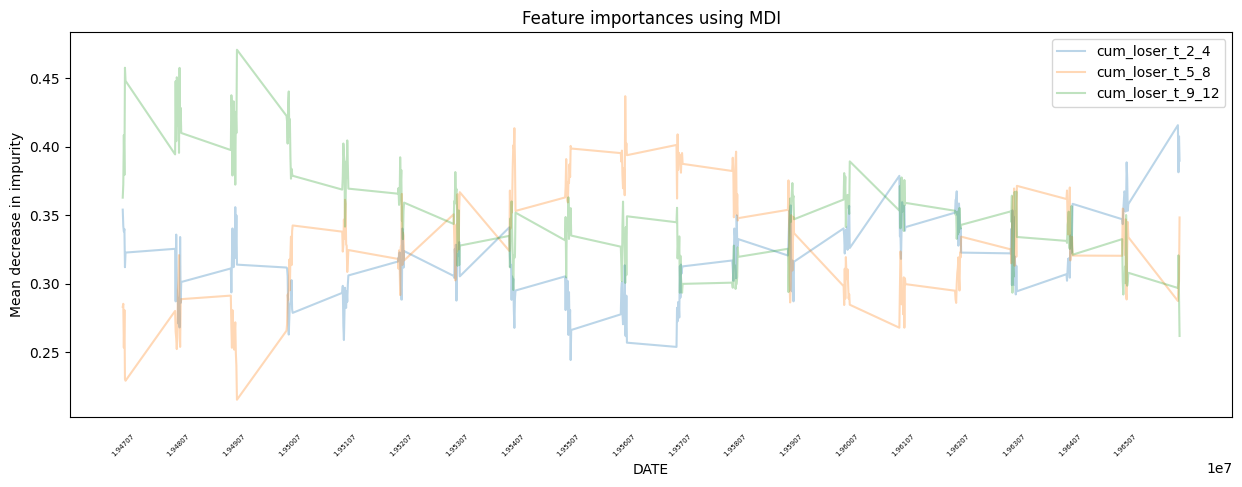

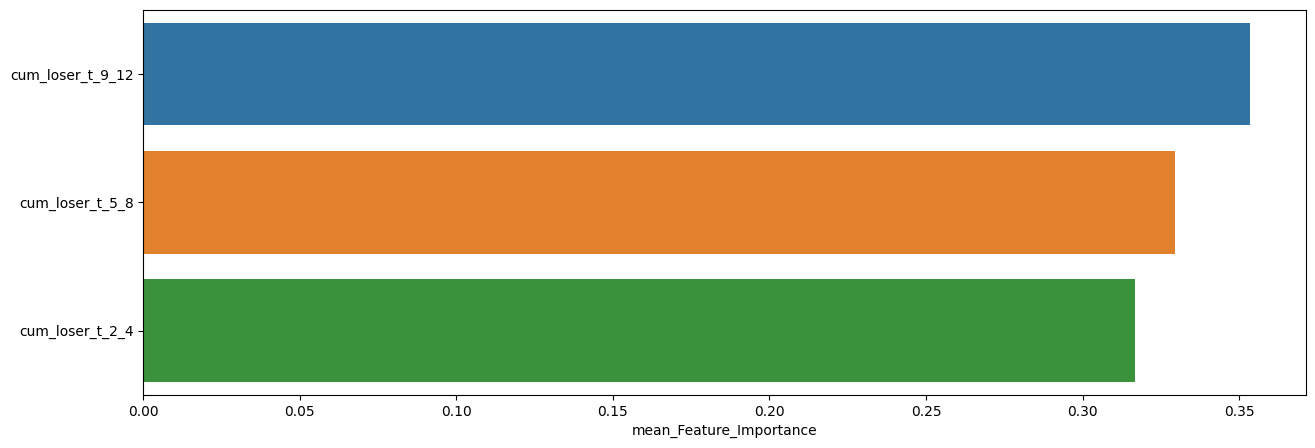

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.353648                0.470850   
cum_loser_t_5_8                  0.329636                0.436935   
cum_loser_t_2_4                  0.316717                0.415762   

                  min_Feature_Importance  
cum_loser_t_9_12                0.261809  
cum_loser_t_5_8                 0.215242  
cum_loser_t_2_4                 0.244232


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.46      0.32      0.38        75
         1.0       0.71      0.81      0.76       151

    accuracy                           0.65       226
   macro avg       0.58      0.57      0.57       226
weighted avg       0.63      0.65      0.63       226


accuracy : 0.6504424778761062

precision : 0.7068965517241379

recall : 0.8145695364238411

F1-Score : 0.7569230769230769



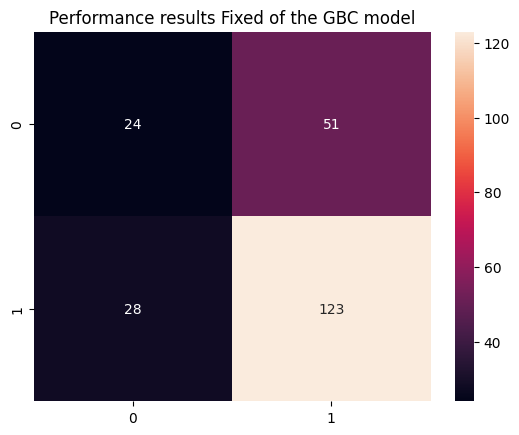


Feature Importance of the model



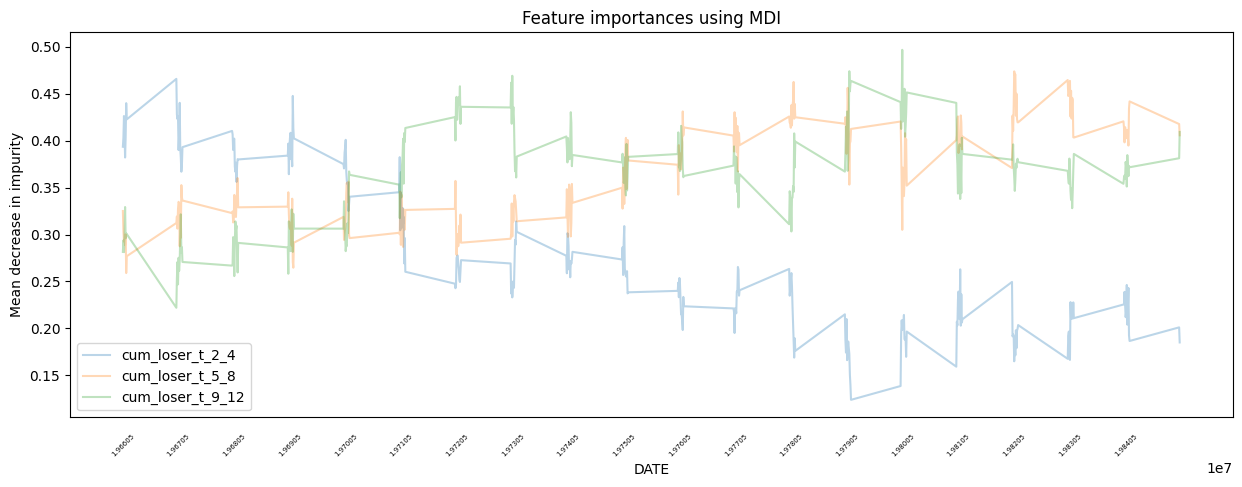

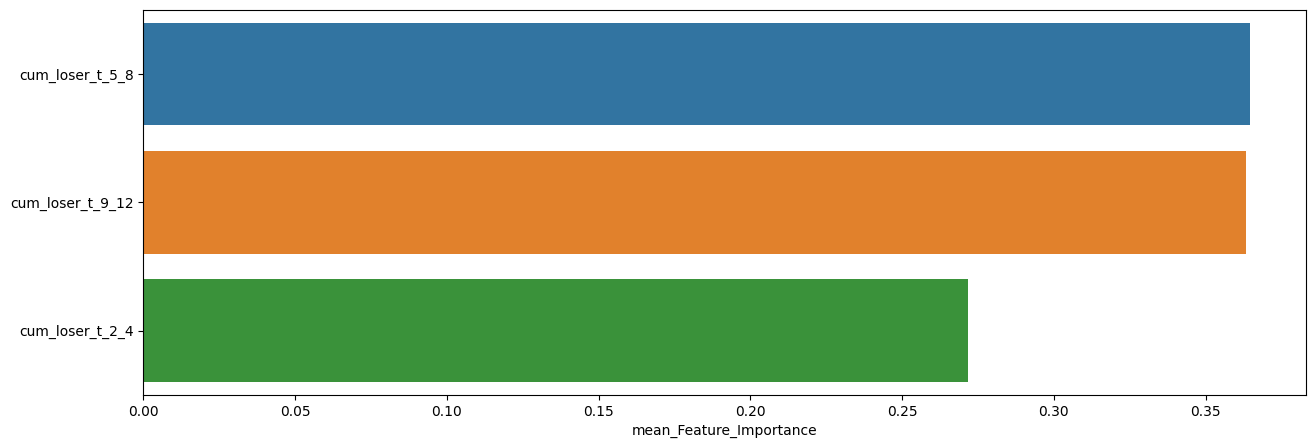

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_5_8                  0.364812                0.473792   
cum_loser_t_9_12                 0.363425                0.496748   
cum_loser_t_2_4                  0.271763                0.465813   

                  min_Feature_Importance  
cum_loser_t_5_8                 0.258945  
cum_loser_t_9_12                0.221948  
cum_loser_t_2_4                 0.123876


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.28      0.10      0.15        70
         1.0       0.69      0.88      0.77       156

    accuracy                           0.64       226
   macro avg       0.48      0.49      0.46       226
weighted avg       0.56      0.64      0.58       226


accuracy : 0.6415929203539823

precision : 0.6865671641791045

recall : 0.8846153846153846

F1-Score : 0.773109243697479



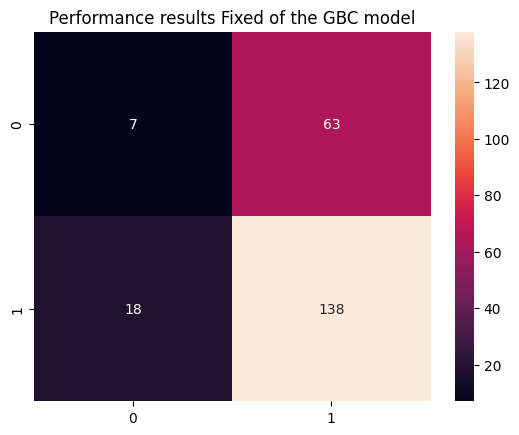


Feature Importance of the model



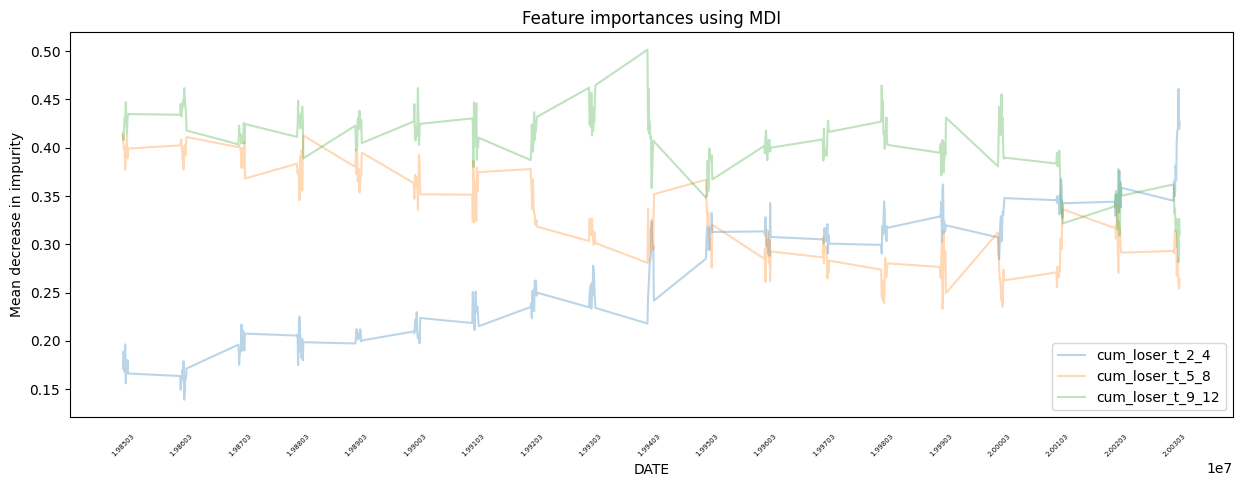

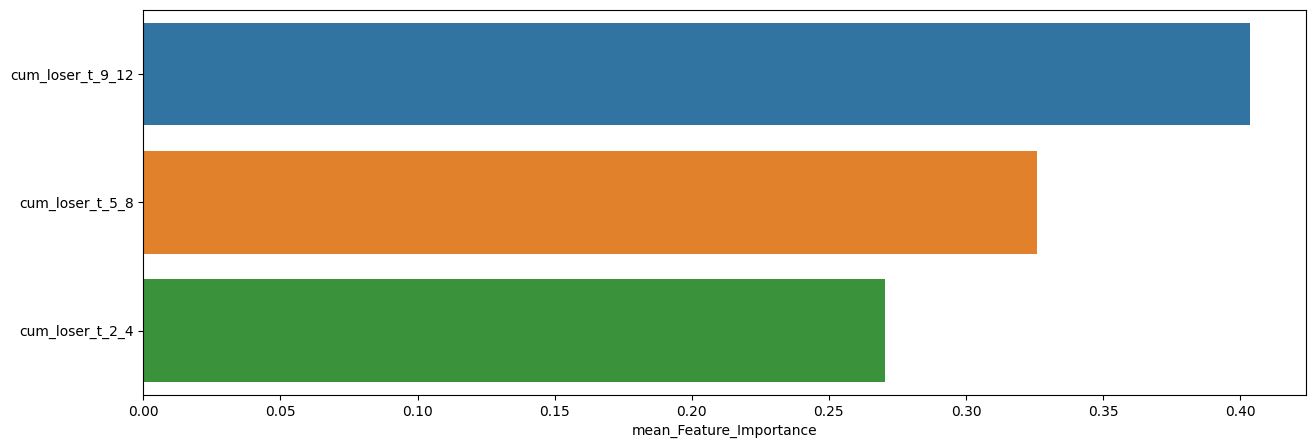

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.403734                0.501341   
cum_loser_t_5_8                  0.325783                0.413387   
cum_loser_t_2_4                  0.270483                0.460666   

                  min_Feature_Importance  
cum_loser_t_9_12                0.281428  
cum_loser_t_5_8                 0.233262  
cum_loser_t_2_4                 0.139023


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.22      0.27        96
         1.0       0.55      0.70      0.62       132

    accuracy                           0.50       228
   macro avg       0.45      0.46      0.44       228
weighted avg       0.47      0.50      0.47       228


accuracy : 0.5

precision : 0.5535714285714286

recall : 0.7045454545454546

F1-Score : 0.62



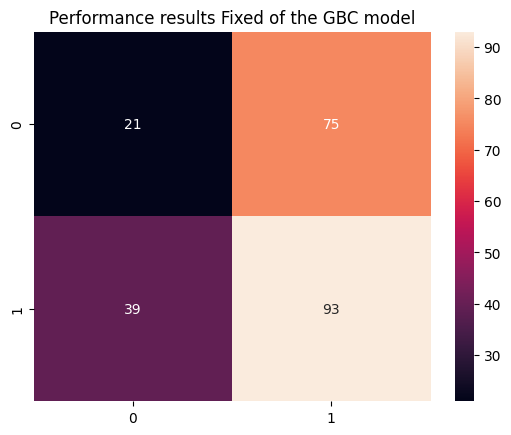


Feature Importance of the model



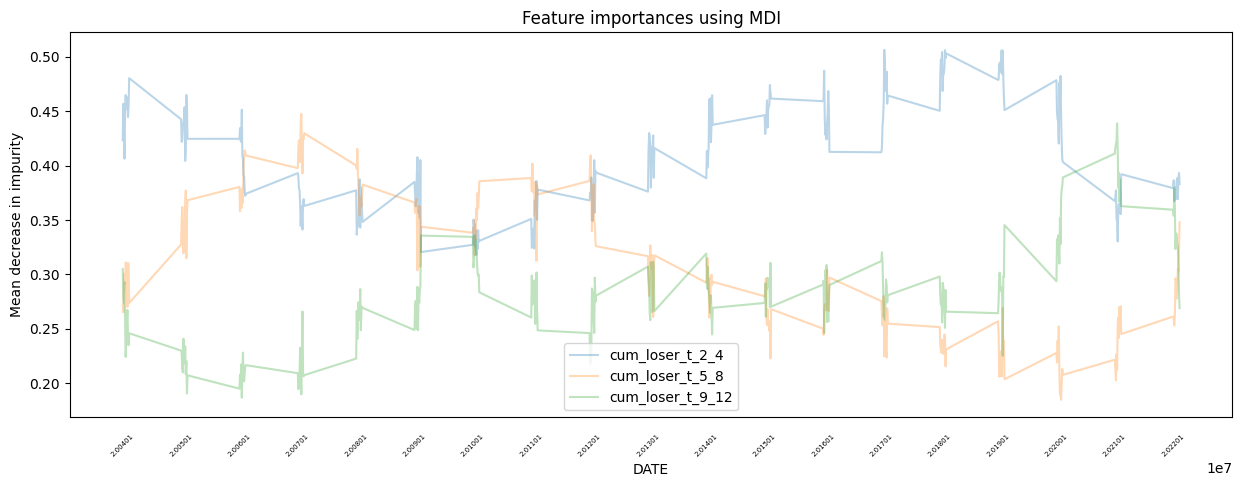

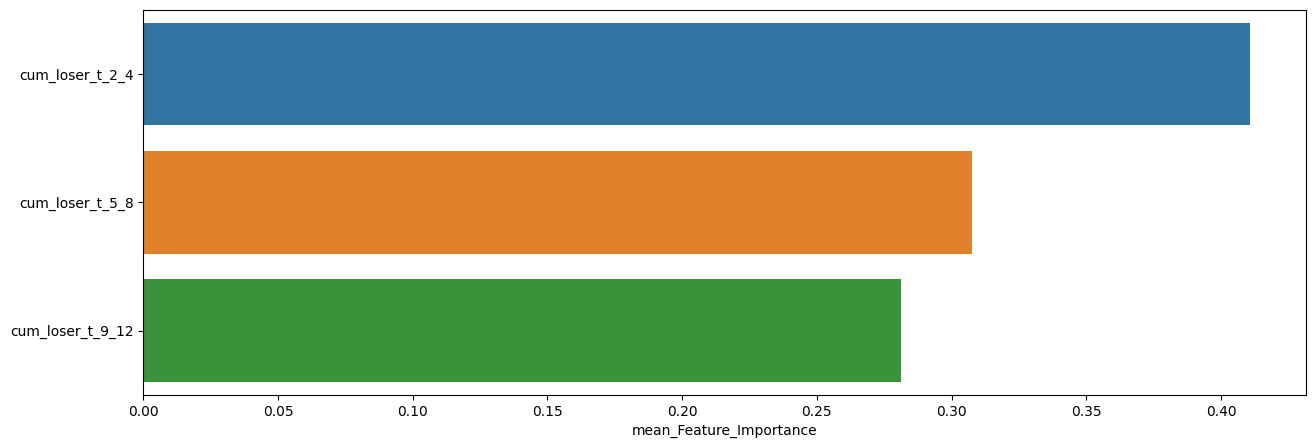

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                  0.410916                0.506360   
cum_loser_t_5_8                  0.307721                0.447529   
cum_loser_t_9_12                 0.281363                0.438744   

                  min_Feature_Importance  
cum_loser_t_2_4                 0.317795  
cum_loser_t_5_8                 0.184758  
cum_loser_t_9_12                0.186720

In [99]:
slice_feature_importance(Fixed_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



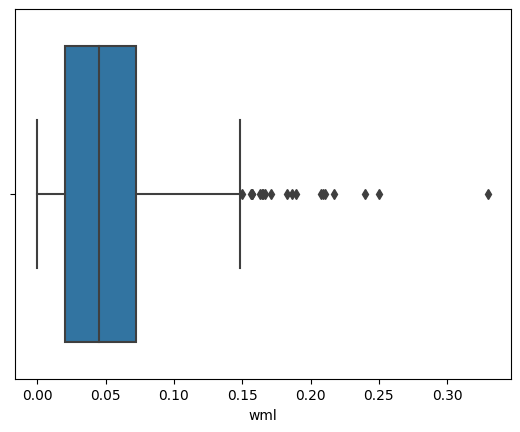

count      mean       std       min       25%       50%       75%  \
wml  472.0  0.052843  0.044543  0.000007  0.020426  0.044955  0.072042   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



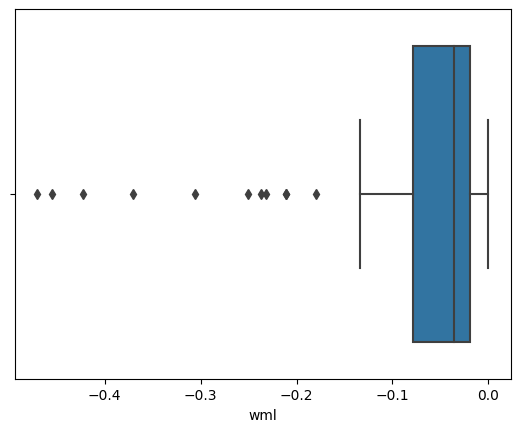

count      mean       std       min       25%       50%       75%  \
wml   72.0 -0.080291  0.107695 -0.469903 -0.078531 -0.035614 -0.019437   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



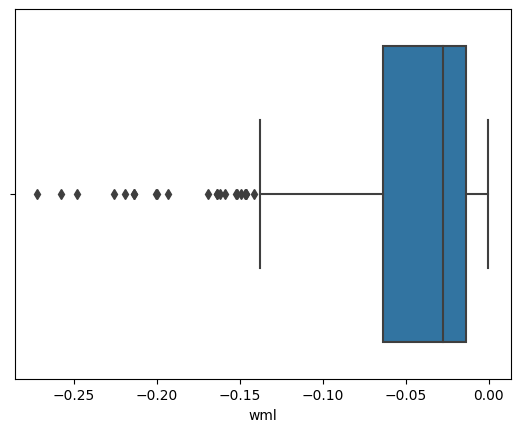

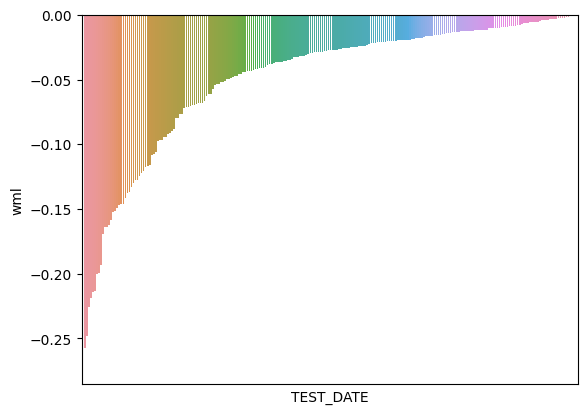

count      mean       std       min       25%       50%      75%  \
wml  244.0 -0.049235  0.054484 -0.271971 -0.063445 -0.027297 -0.01352   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



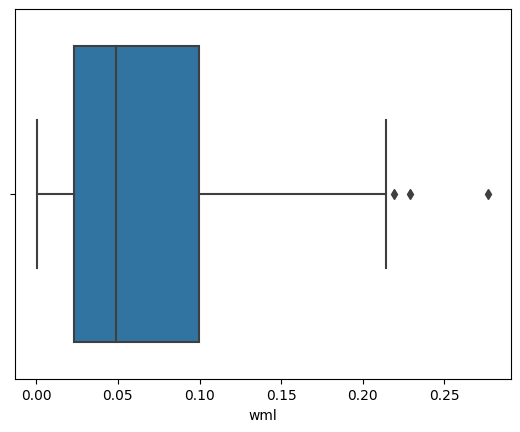

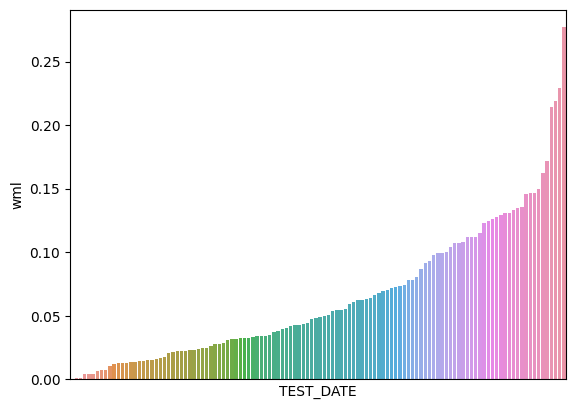

count      mean       std       min       25%      50%       75%  \
wml  118.0  0.064877  0.054104  0.000692  0.023249  0.04876  0.099671   

          max  
wml  0.276912

In [100]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Fixed_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.64101

최근 누적 수익률

  2022년-12월 -> 69657.71
  2022년-11월 -> 62760.28
  2022년-10월 -> 59698.23
  2022년-09월 -> 59698.23
  2022년-08월 -> 59698.23

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2019년-08월 -> 144308.28
  2등 : 2019년-10월 -> 137915.50
  3등 : 2018년-12월 -> 135378.94
  4등 : 2019년-11월 -> 133394.79
  5등 : 2019년-07월 -> 131157.60
  6등 : 2019년-09월 -> 130376.98
  7등 : 2018년-11월 -> 128019.00
  8등 : 2019년-05월 -> 121973.67
  9등 : 2016년-01월 -> 120745.53
  10등 : 2019년-06월 -> 119420.54



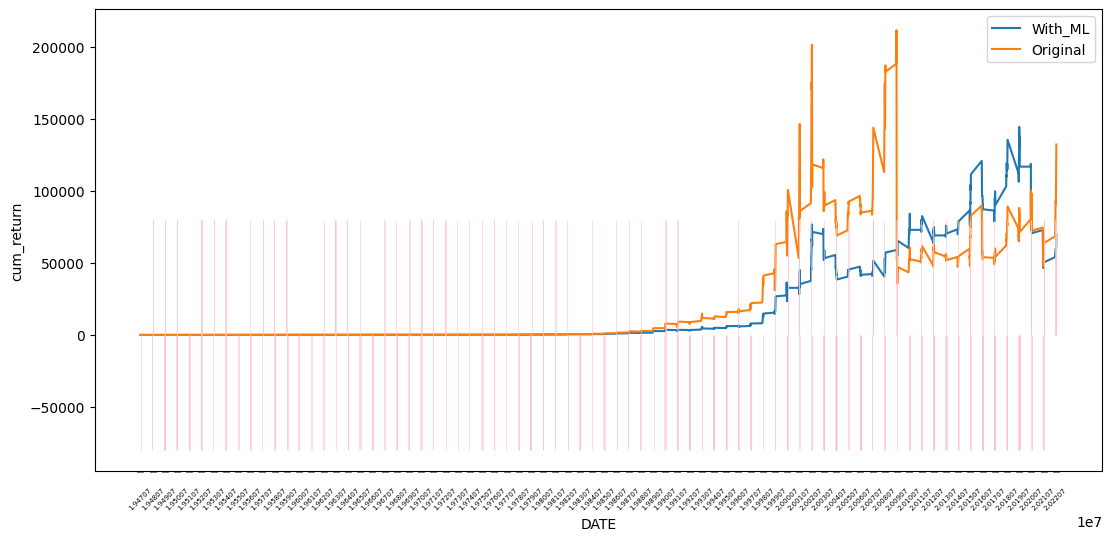

In [101]:
GBC_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.72121

최근 누적 수익률

  2022년-12월 -> 9170.21
  2022년-11월 -> 8424.39
  2022년-10월 -> 8110.19
  2022년-09월 -> 7917.58
  2022년-08월 -> 7709.74

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2016년-01월 -> 12189.15
  2등 : 2018년-12월 -> 11740.39
  3등 : 2015년-12월 -> 11454.96
  4등 : 2002년-09월 -> 11281.59
  5등 : 2018년-11월 -> 11204.64
  6등 : 2015년-11월 -> 11195.14
  7등 : 2019년-08월 -> 11051.92
  8등 : 2016년-02월 -> 10995.69
  9등 : 2015년-09월 -> 10939.12
  10등 : 2019년-10월 -> 10754.46



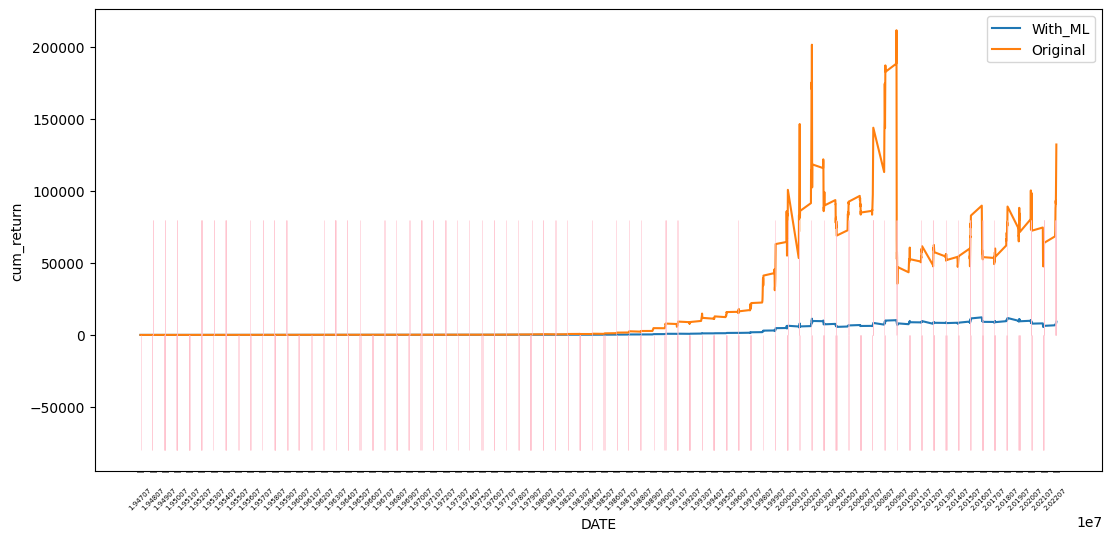

In [102]:
GBC_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_GBC_Result,
                                                 WML,
                                                 'GBC_PROB_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

### XGB

In [103]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : None
 

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.24      0.27       316
         1.0       0.64      0.73      0.68       590

    accuracy                           0.56       906
   macro avg       0.48      0.48      0.48       906
weighted avg       0.53      0.56      0.54       906


accuracy : 0.5562913907284768

precision : 0.6402985074626866

recall : 0.7271186440677966

F1-Score : 0.680952380952381



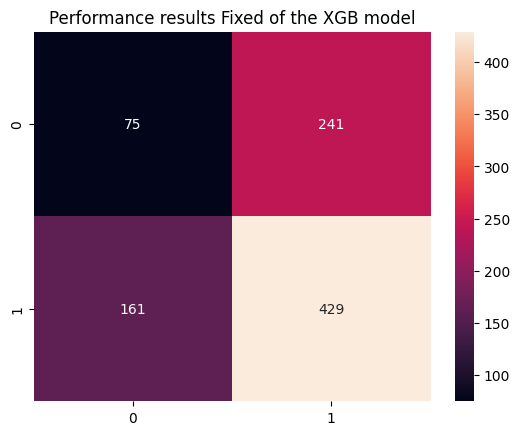


Feature Importance of the model



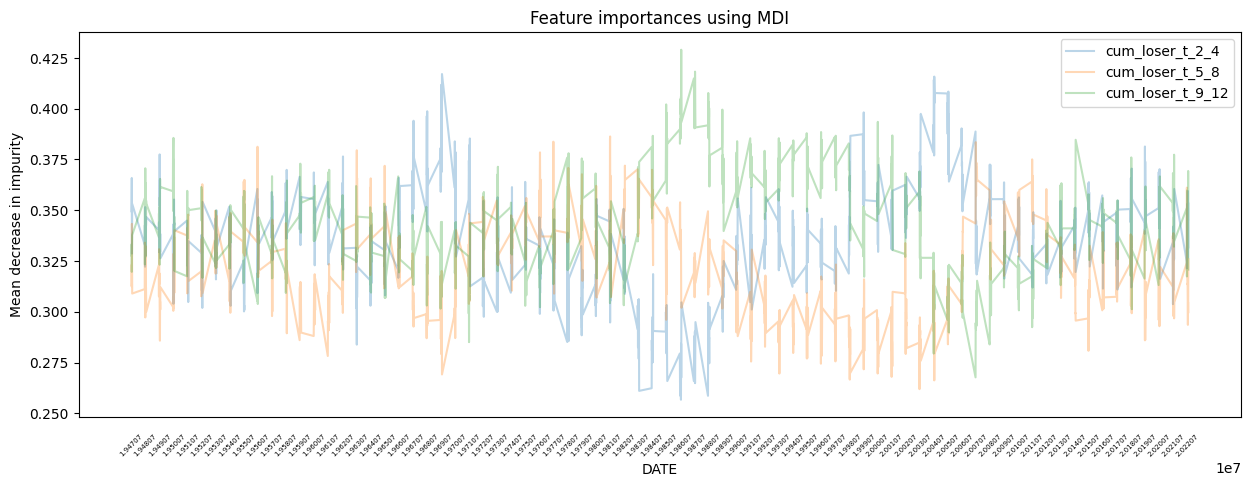

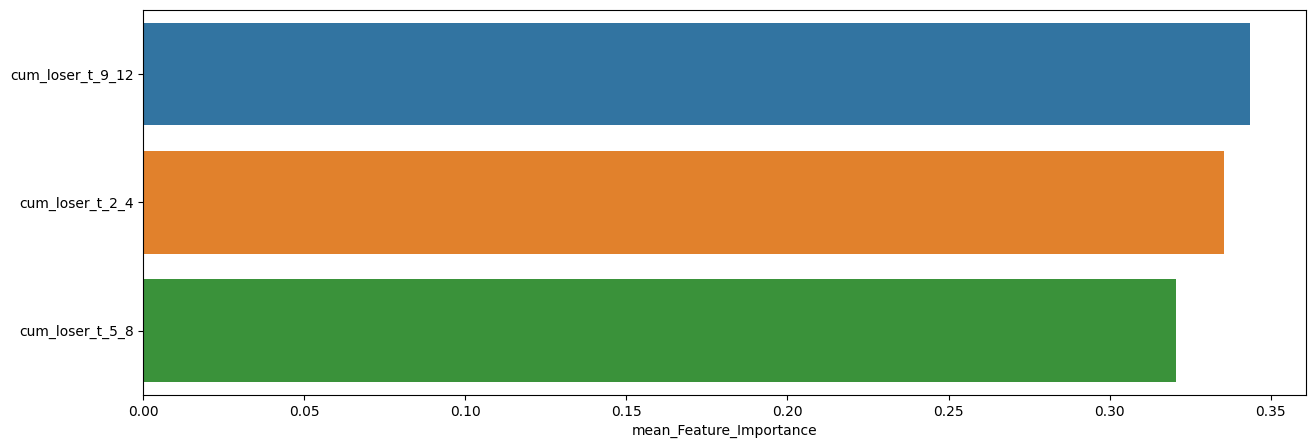

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.343768                0.429030   
cum_loser_t_2_4                  0.335561                0.417068   
cum_loser_t_5_8                  0.320671                0.386333   

                  min_Feature_Importance  
cum_loser_t_9_12                0.267749  
cum_loser_t_2_4                 0.256719  
cum_loser_t_5_8                 0.261935

In [104]:
Fixed_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.32      0.31      0.32        75
         1.0       0.66      0.68      0.67       151

    accuracy                           0.56       226
   macro avg       0.49      0.49      0.49       226
weighted avg       0.55      0.56      0.55       226


accuracy : 0.5575221238938053

precision : 0.6645161290322581

recall : 0.6821192052980133

F1-Score : 0.673202614379085



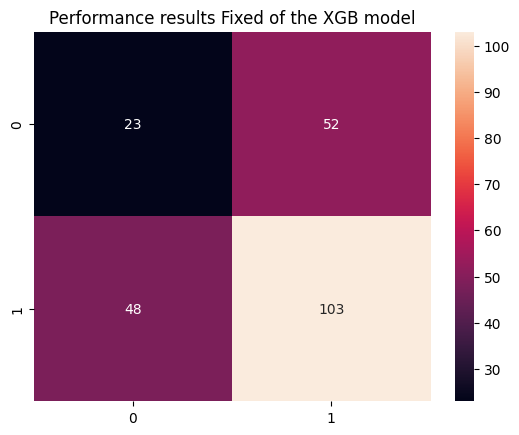


Feature Importance of the model



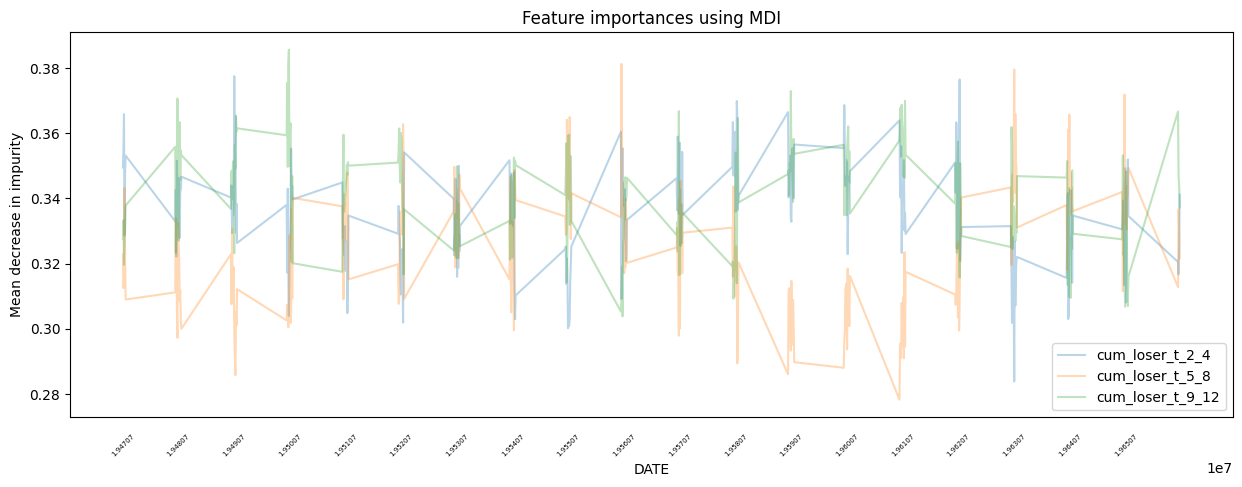

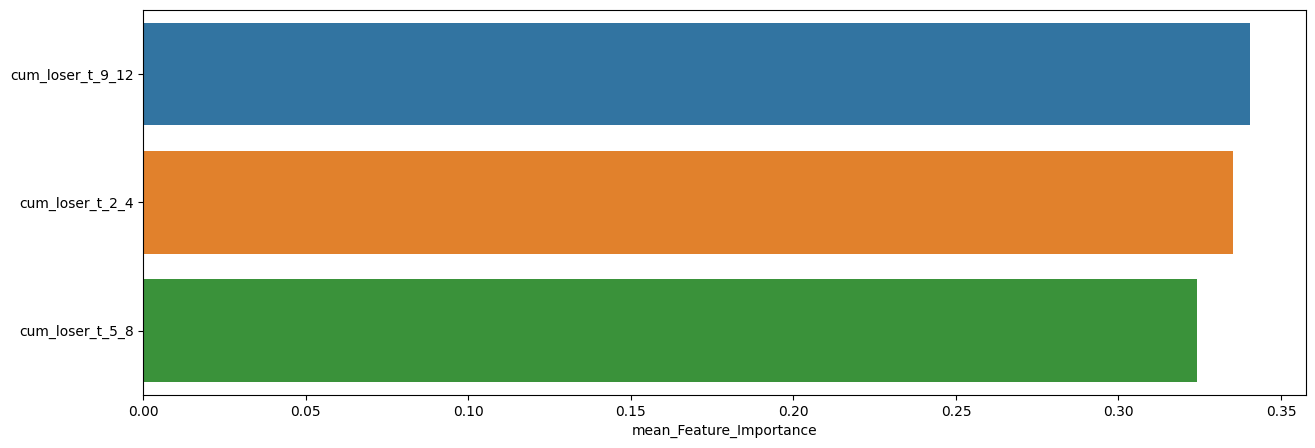

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.340619                0.385617   
cum_loser_t_2_4                  0.335129                0.377507   
cum_loser_t_5_8                  0.324252                0.381270   

                  min_Feature_Importance  
cum_loser_t_9_12                0.303851  
cum_loser_t_2_4                 0.283860  
cum_loser_t_5_8                 0.278257


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.23      0.26        75
         1.0       0.66      0.75      0.71       151

    accuracy                           0.58       226
   macro avg       0.49      0.49      0.48       226
weighted avg       0.55      0.58      0.56       226


accuracy : 0.5796460176991151

precision : 0.6627906976744186

recall : 0.7549668874172185

F1-Score : 0.7058823529411764



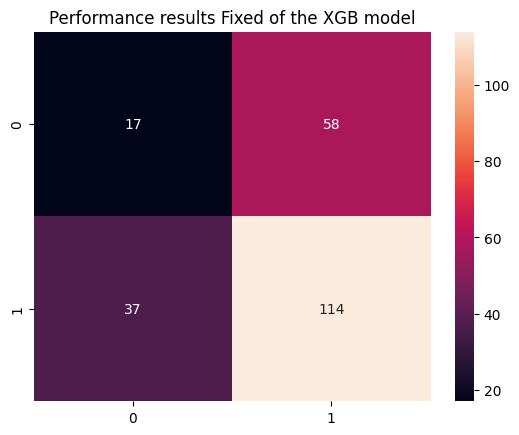


Feature Importance of the model



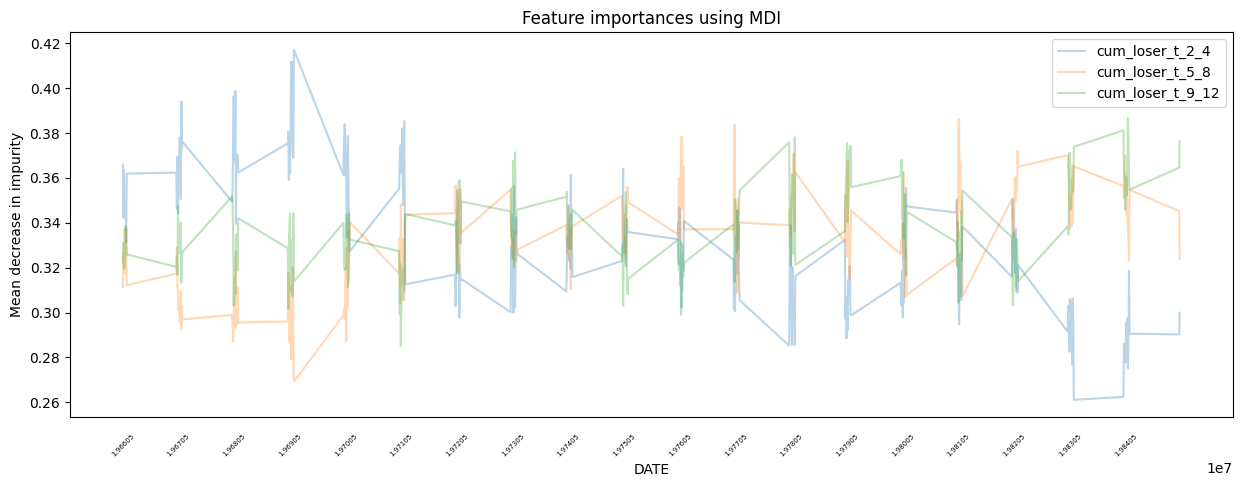

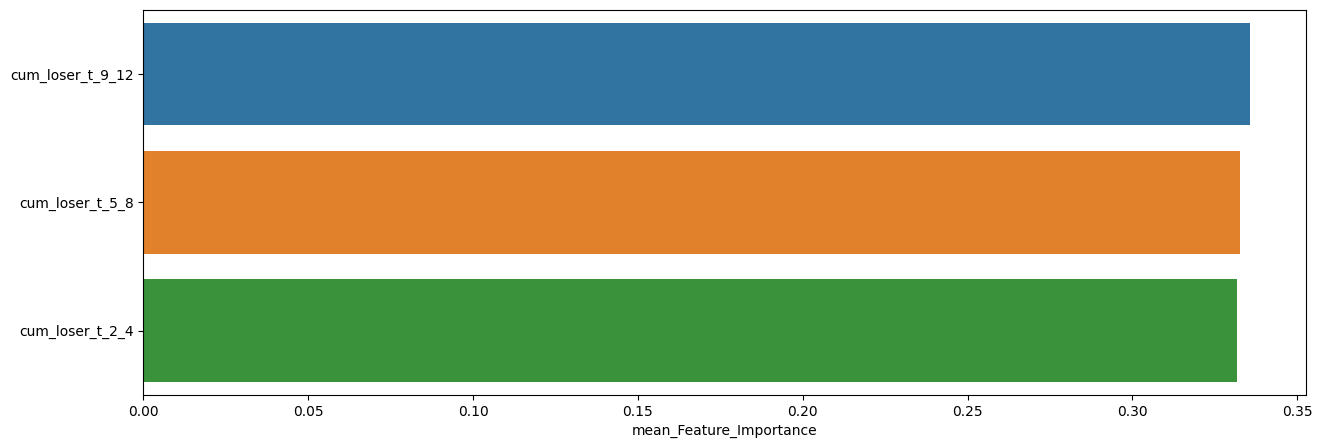

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.335786                0.386658   
cum_loser_t_5_8                  0.332608                0.386333   
cum_loser_t_2_4                  0.331606                0.417068   

                  min_Feature_Importance  
cum_loser_t_9_12                0.285091  
cum_loser_t_5_8                 0.269177  
cum_loser_t_2_4                 0.261086


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.19      0.25        70
         1.0       0.70      0.85      0.77       156

    accuracy                           0.65       226
   macro avg       0.53      0.52      0.51       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6460176991150443

precision : 0.7

recall : 0.8525641025641025

F1-Score : 0.7687861271676302



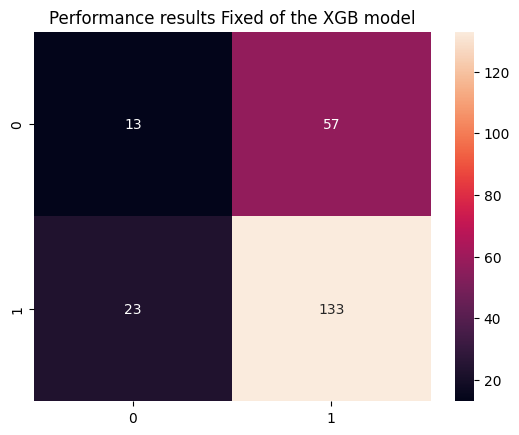


Feature Importance of the model



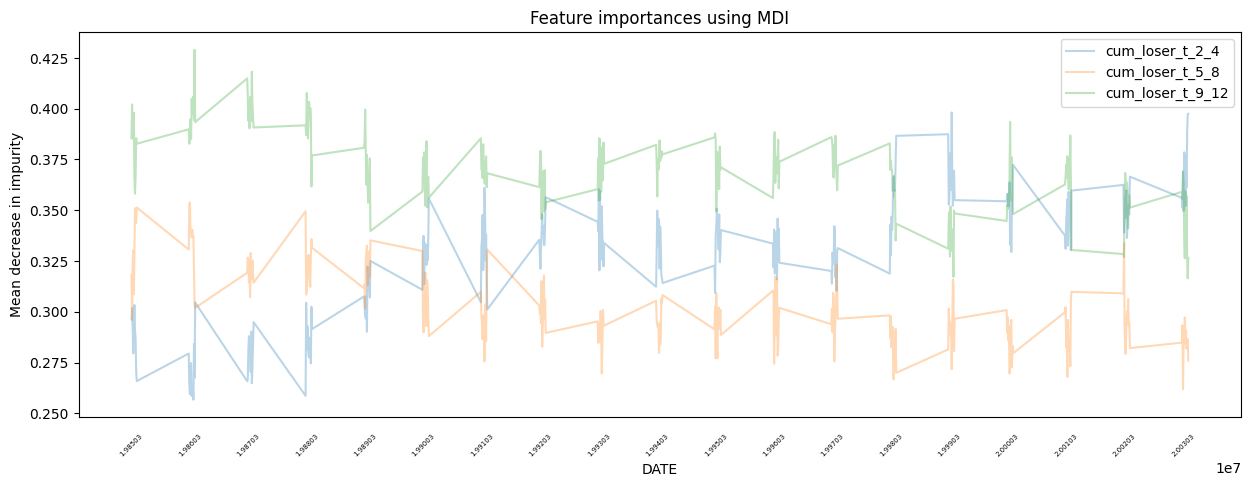

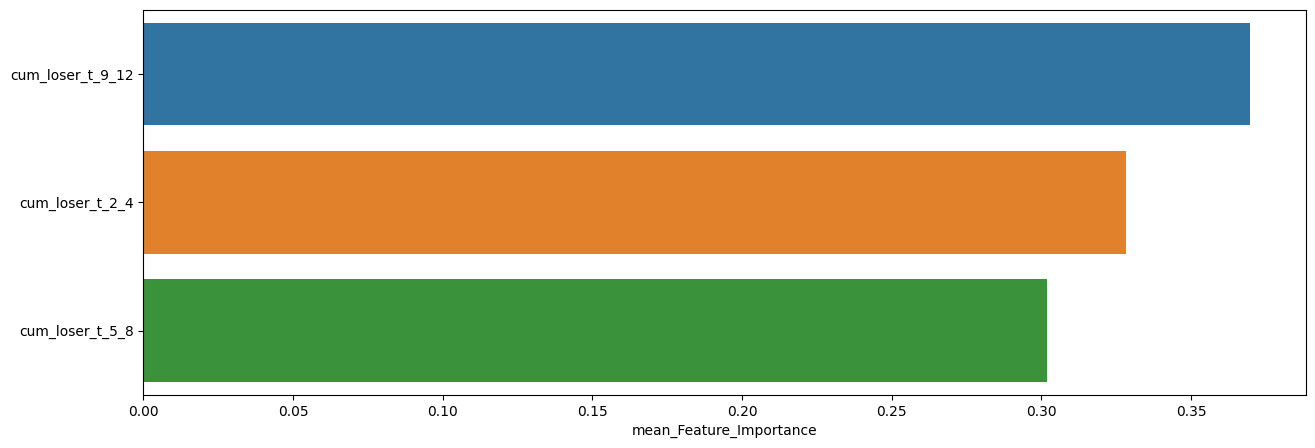

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.369817                0.429030   
cum_loser_t_2_4                  0.328246                0.398181   
cum_loser_t_5_8                  0.301937                0.353926   

                  min_Feature_Importance  
cum_loser_t_9_12                0.316490  
cum_loser_t_2_4                 0.256719  
cum_loser_t_5_8                 0.261935


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.23      0.26        96
         1.0       0.52      0.60      0.55       132

    accuracy                           0.44       228
   macro avg       0.40      0.41      0.41       228
weighted avg       0.42      0.44      0.43       228


accuracy : 0.44298245614035087

precision : 0.5163398692810458

recall : 0.5984848484848485

F1-Score : 0.5543859649122808



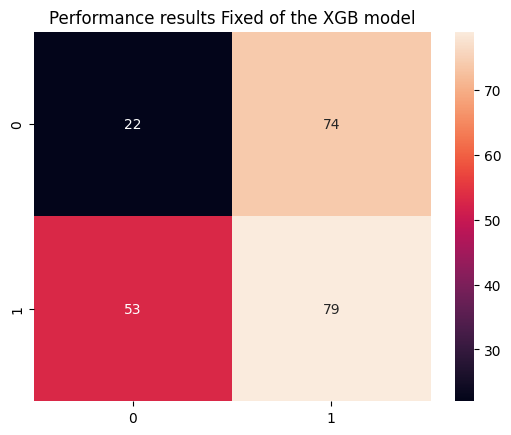


Feature Importance of the model



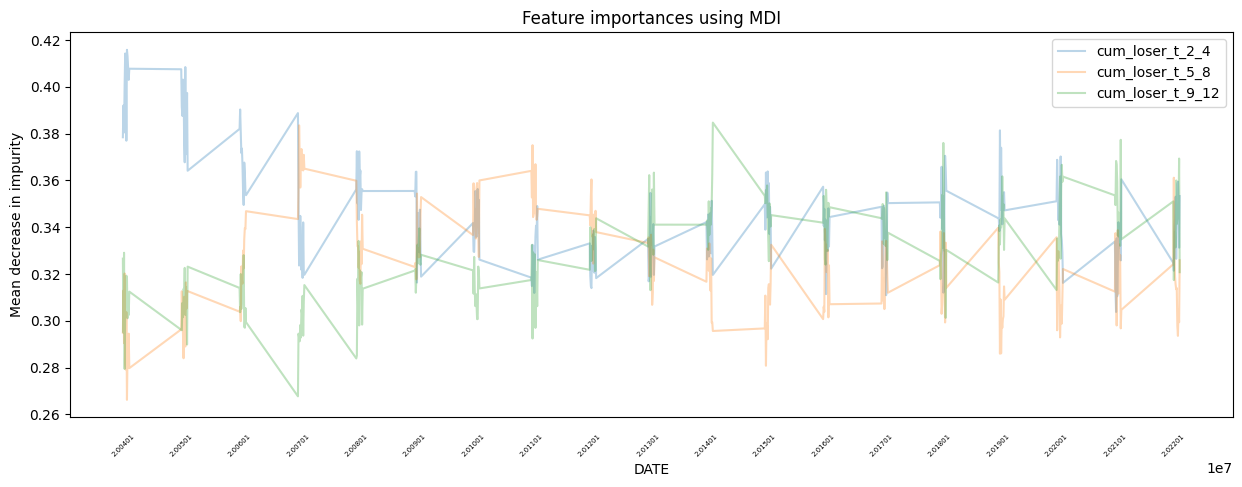

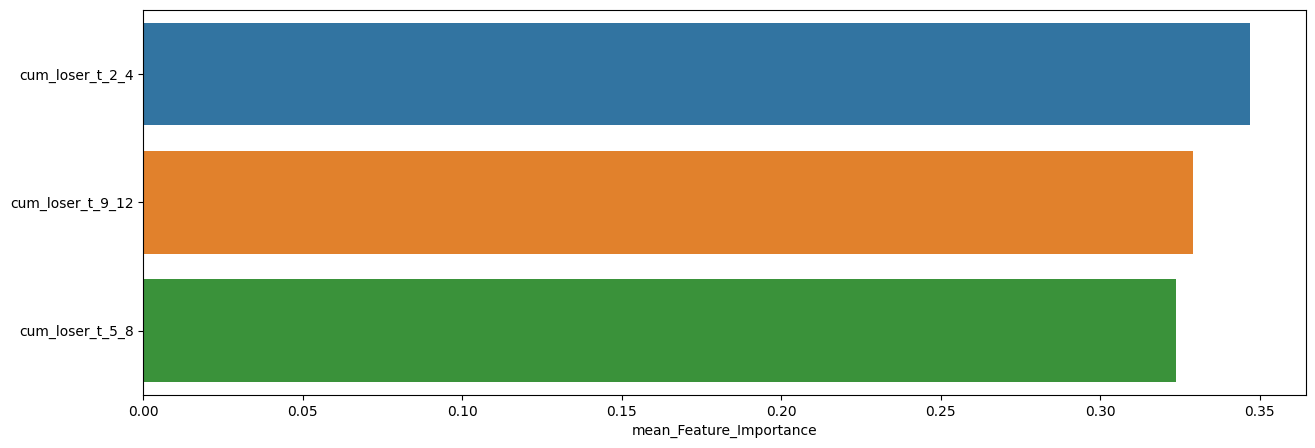

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                  0.347161                0.415800   
cum_loser_t_9_12                 0.328979                0.384704   
cum_loser_t_5_8                  0.323860                0.383530   

                  min_Feature_Importance  
cum_loser_t_2_4                 0.303805  
cum_loser_t_9_12                0.267749  
cum_loser_t_5_8                 0.266252

In [105]:
slice_feature_importance(Fixed_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Fixed', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



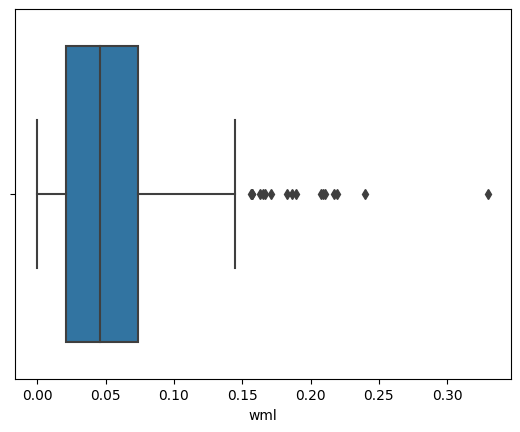

count      mean       std       min       25%       50%       75%  \
wml  429.0  0.053573  0.044407  0.000007  0.021224  0.045577  0.073302   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



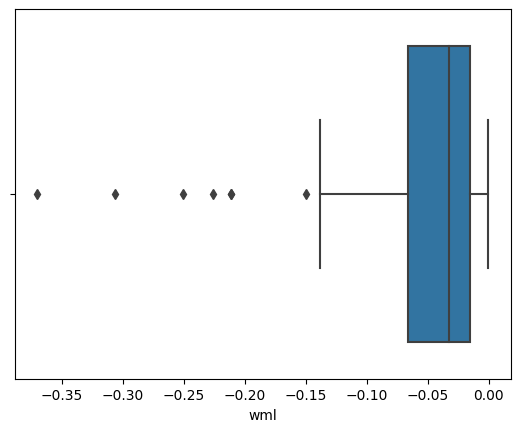

count     mean       std       min       25%       50%      75%       max
wml   75.0 -0.05744  0.071729 -0.370041 -0.066242 -0.032064 -0.01527 -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



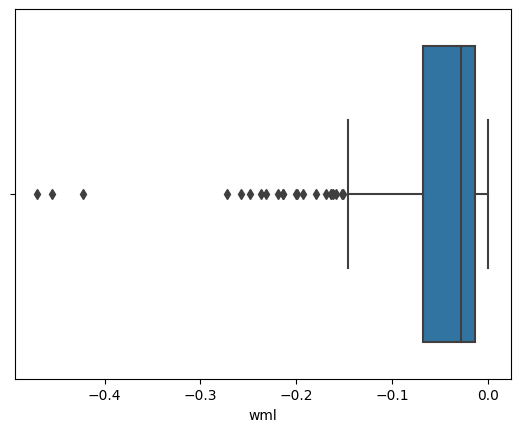

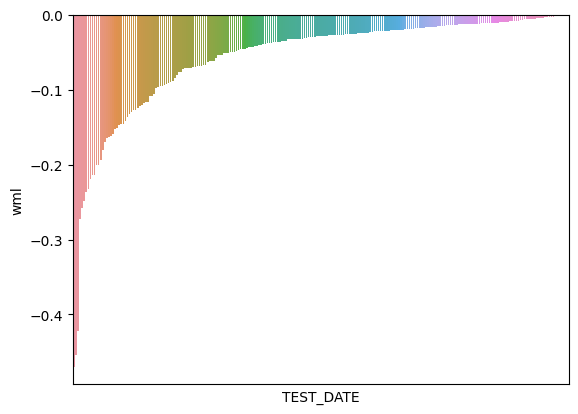

count     mean       std       min      25%       50%       75%       max
wml  241.0 -0.05596  0.071227 -0.469903 -0.06833 -0.028532 -0.014514 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



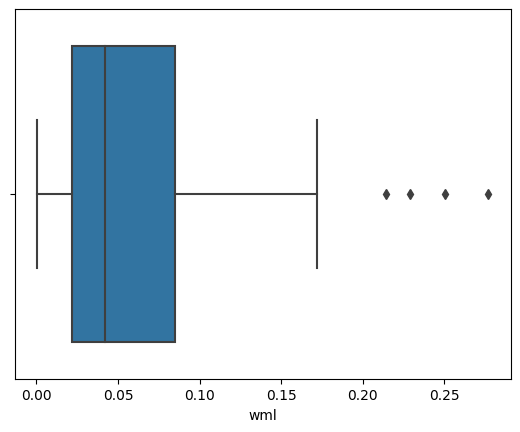

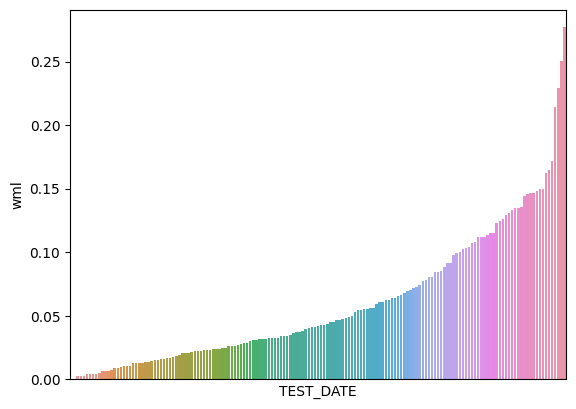

count      mean       std       min       25%       50%       75%  \
wml  161.0  0.059717  0.052574  0.000627  0.022009  0.041853  0.085231   

          max  
wml  0.276912

In [106]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Fixed_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.69139

최근 누적 수익률

  2022년-12월 -> 1517.40
  2022년-11월 -> 1367.05
  2022년-10월 -> 1300.30
  2022년-09월 -> 1300.30
  2022년-08월 -> 1300.30

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 8202.94
  2등 : 2003년-02월 -> 7878.85
  3등 : 2003년-03월 -> 7766.93
  4등 : 2002년-12월 -> 7652.26
  5등 : 2003년-01월 -> 7484.74
  6등 : 2000년-02월 -> 7382.51
  7등 : 2000년-10월 -> 7223.67
  8등 : 2002년-07월 -> 7142.90
  9등 : 2002년-06월 -> 7142.90
  10등 : 2000년-11월 -> 7134.95



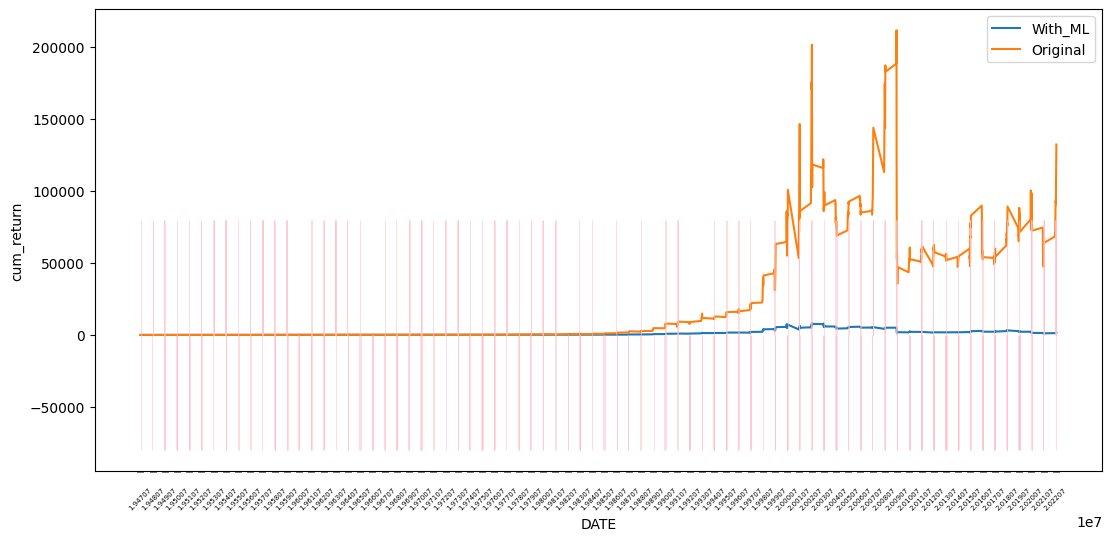

In [107]:
XGB_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.71180

최근 누적 수익률

  2022년-12월 -> 4013.00
  2022년-11월 -> 3647.62
  2022년-10월 -> 3484.67
  2022년-09월 -> 3433.30
  2022년-08월 -> 3421.61

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 12143.77
  2등 : 2002년-07월 -> 10647.83
  3등 : 2002년-10월 -> 10541.44
  4등 : 2002년-06월 -> 10477.84
  5등 : 2002년-08월 -> 10343.08
  6등 : 2003년-02월 -> 10190.53
  7등 : 2003년-03월 -> 10063.09
  8등 : 2002년-12월 -> 9949.54
  9등 : 2003년-01월 -> 9739.73
  10등 : 2001년-09월 -> 9354.42



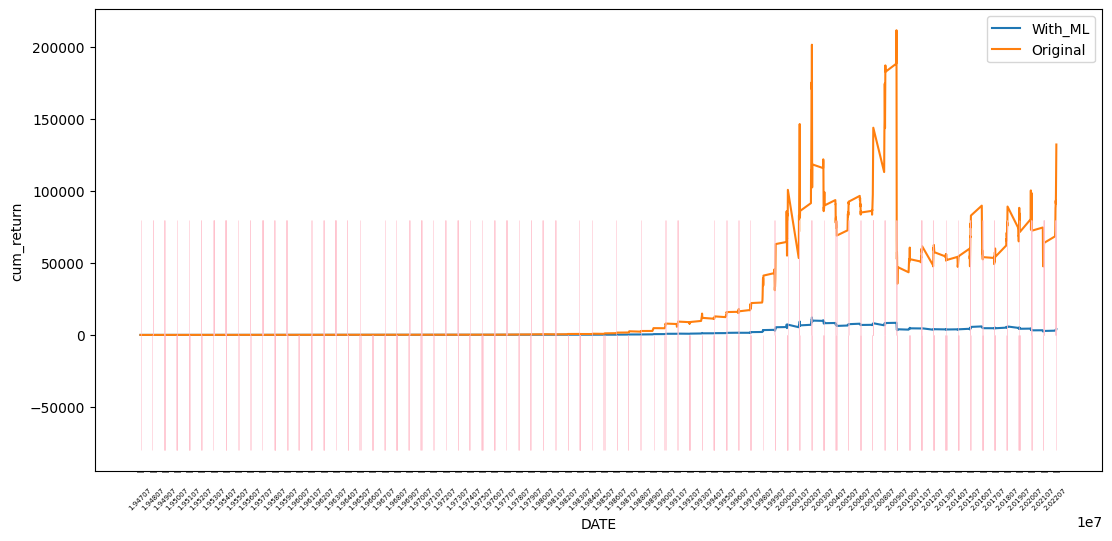

In [108]:
XGB_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [109]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Fixed Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.20      0.24       316
         1.0       0.63      0.74      0.68       590

    accuracy                           0.55       906
   macro avg       0.47      0.47      0.46       906
weighted avg       0.52      0.55      0.53       906


accuracy : 0.5540838852097131

precision : 0.6347826086956522

recall : 0.7423728813559322

F1-Score : 0.684375



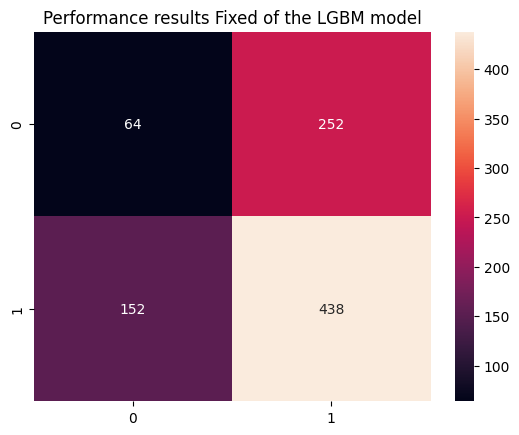


Feature Importance of the model



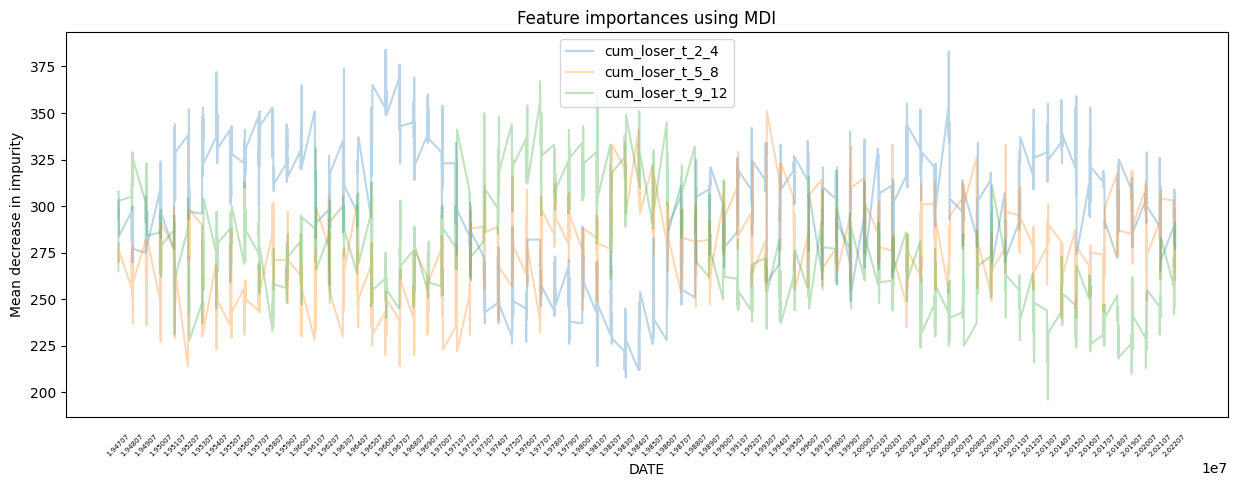

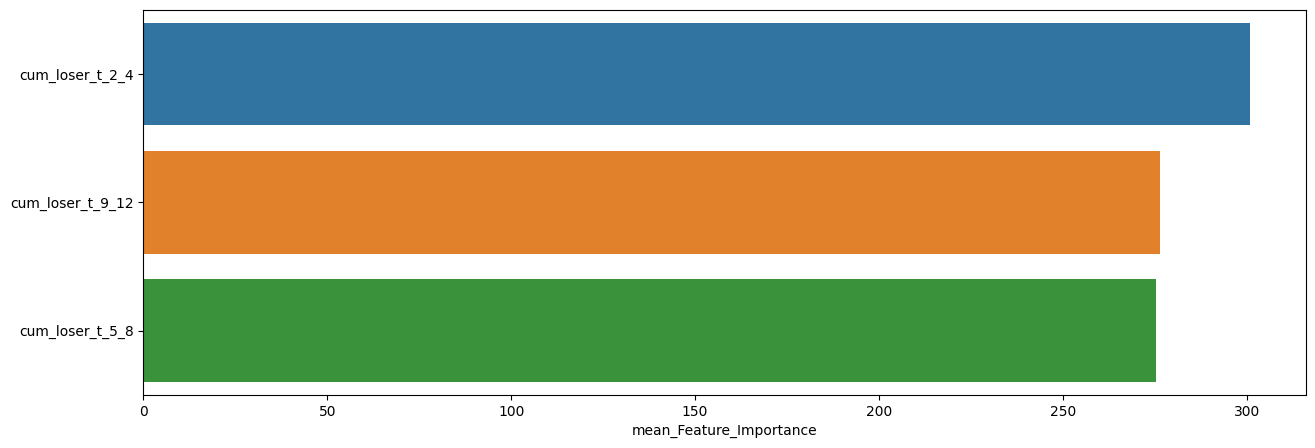

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                301.030905                     384   
cum_loser_t_9_12               276.547461                     367   
cum_loser_t_5_8                275.219647                     351   

                  min_Feature_Importance  
cum_loser_t_2_4                      208  
cum_loser_t_9_12                     196  
cum_loser_t_5_8                      214

In [110]:
Fixed_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Fixed', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.25      0.28        75
         1.0       0.66      0.71      0.68       151

    accuracy                           0.56       226
   macro avg       0.48      0.48      0.48       226
weighted avg       0.54      0.56      0.55       226


accuracy : 0.5575221238938053

precision : 0.656441717791411

recall : 0.7086092715231788

F1-Score : 0.6815286624203821



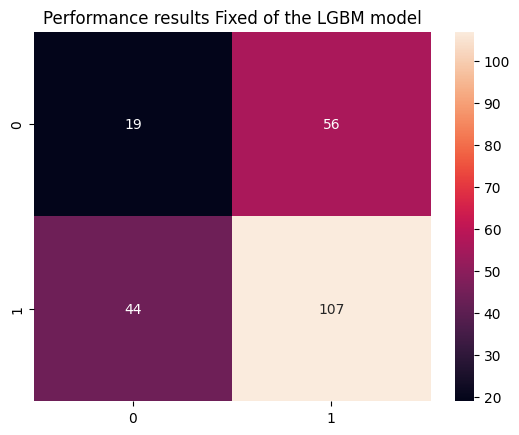


Feature Importance of the model



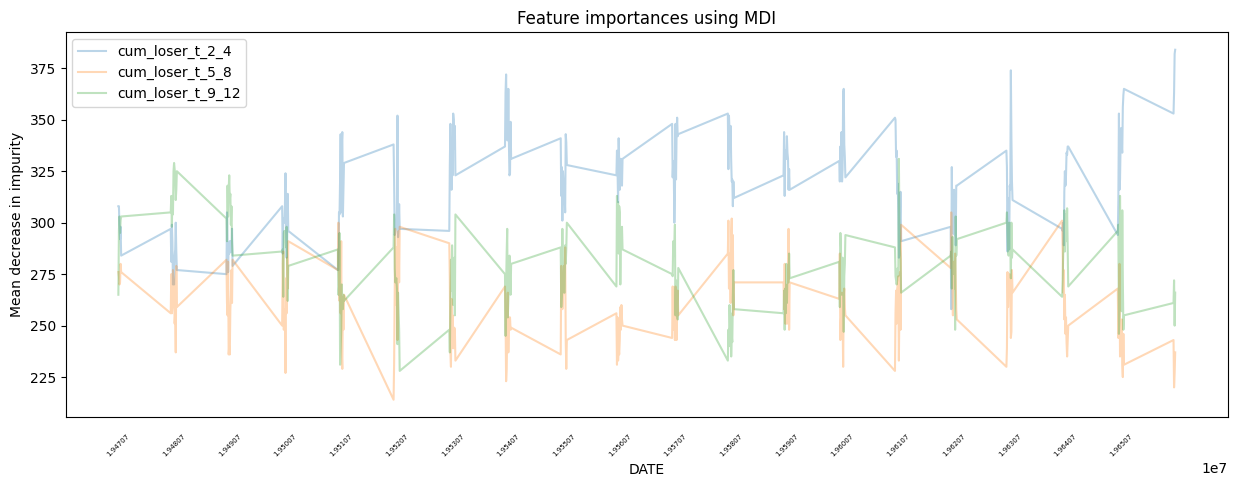

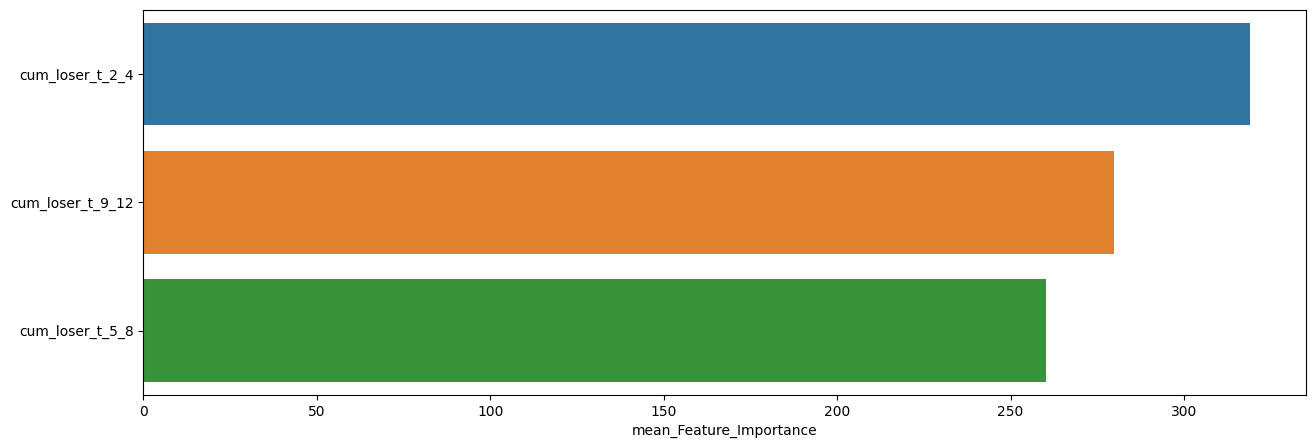

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                319.146018                     384   
cum_loser_t_9_12               279.734513                     331   
cum_loser_t_5_8                260.323009                     305   

                  min_Feature_Importance  
cum_loser_t_2_4                      258  
cum_loser_t_9_12                     228  
cum_loser_t_5_8                      214


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.17      0.22        75
         1.0       0.66      0.79      0.72       151

    accuracy                           0.58       226
   macro avg       0.47      0.48      0.47       226
weighted avg       0.54      0.58      0.55       226


accuracy : 0.584070796460177

precision : 0.6574585635359116

recall : 0.7880794701986755

F1-Score : 0.7168674698795181



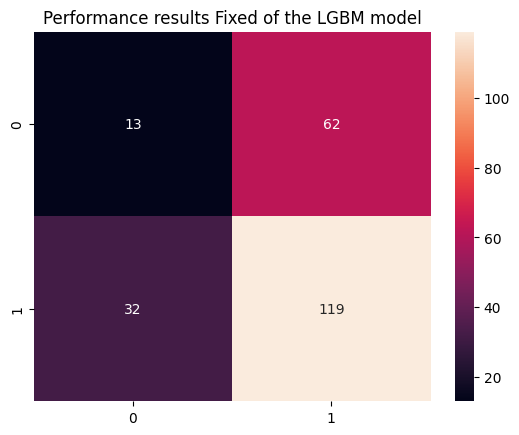


Feature Importance of the model



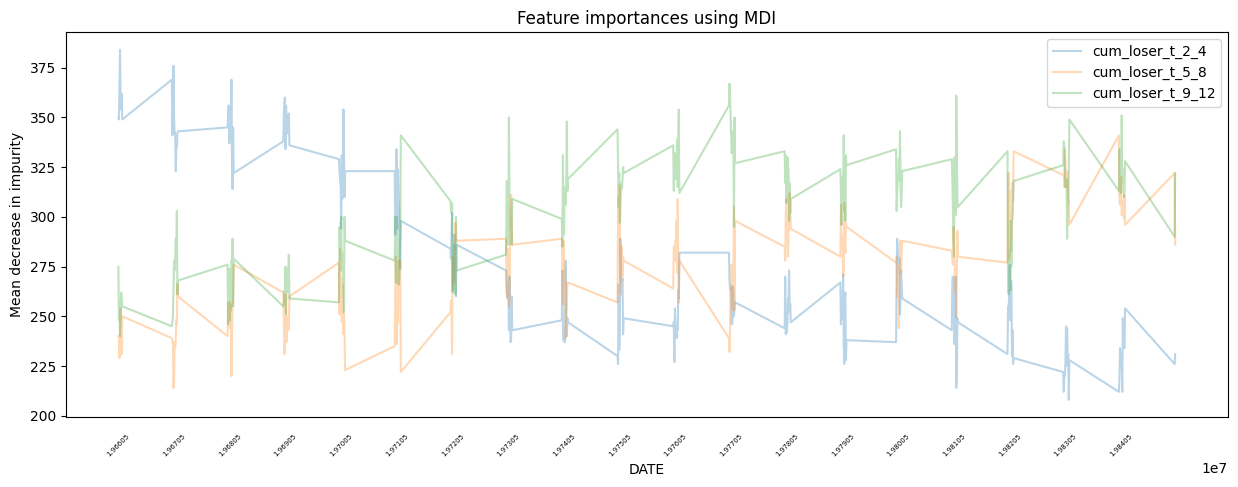

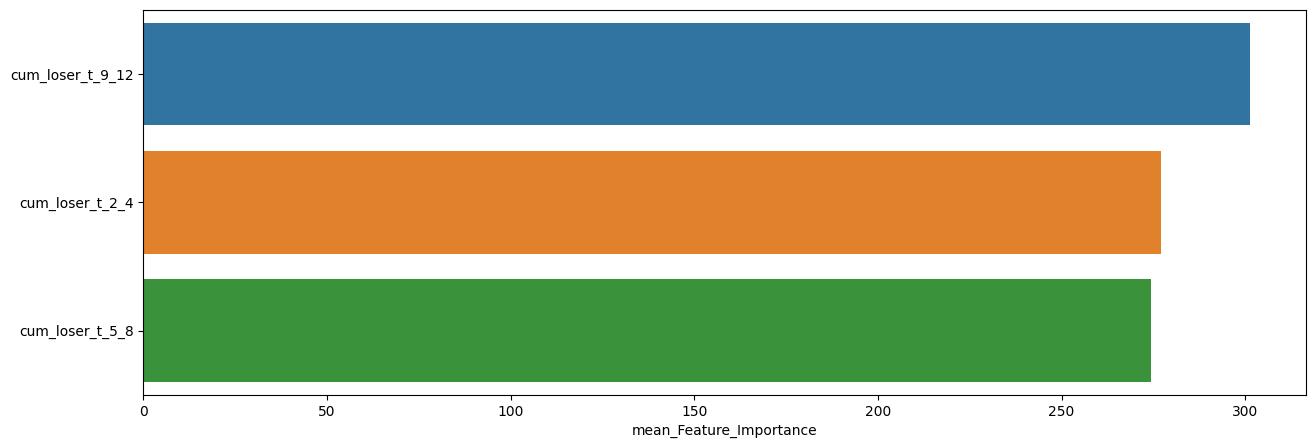

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12               301.420354                     367   
cum_loser_t_2_4                276.960177                     384   
cum_loser_t_5_8                274.460177                     341   

                  min_Feature_Importance  
cum_loser_t_9_12                     240  
cum_loser_t_2_4                      208  
cum_loser_t_5_8                      214


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.16      0.20        70
         1.0       0.68      0.81      0.74       156

    accuracy                           0.61       226
   macro avg       0.47      0.48      0.47       226
weighted avg       0.55      0.61      0.57       226


accuracy : 0.6061946902654868

precision : 0.6810810810810811

recall : 0.8076923076923077

F1-Score : 0.7390029325513198



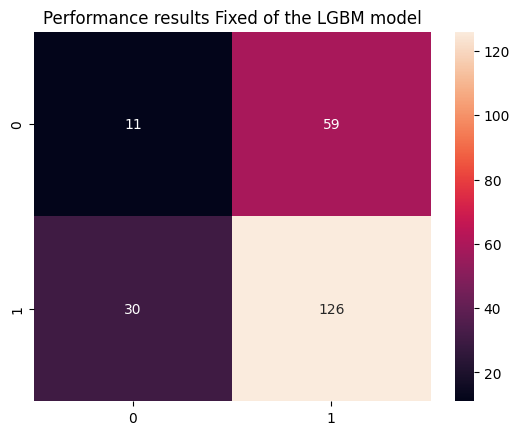


Feature Importance of the model



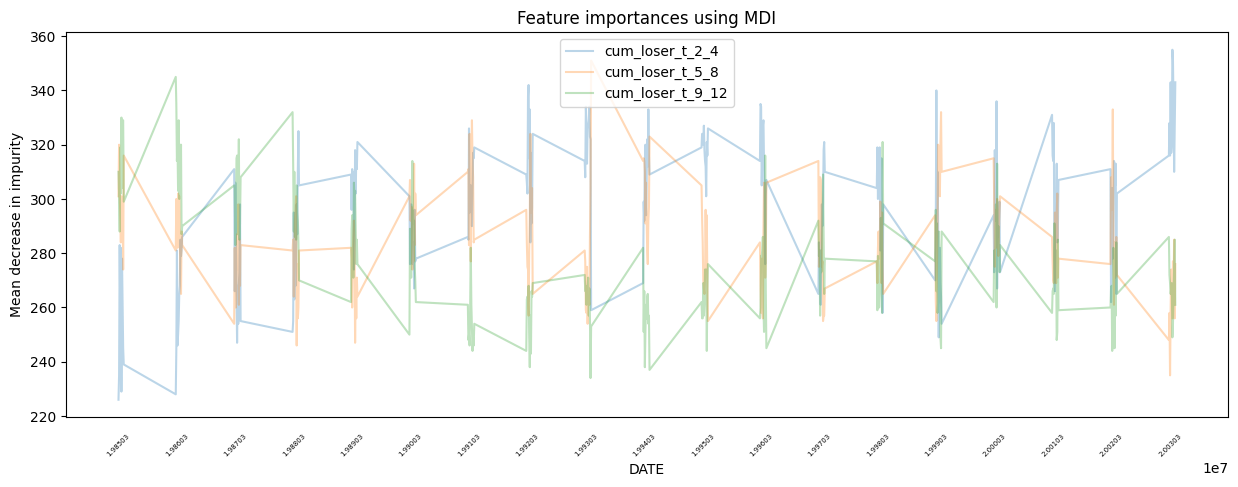

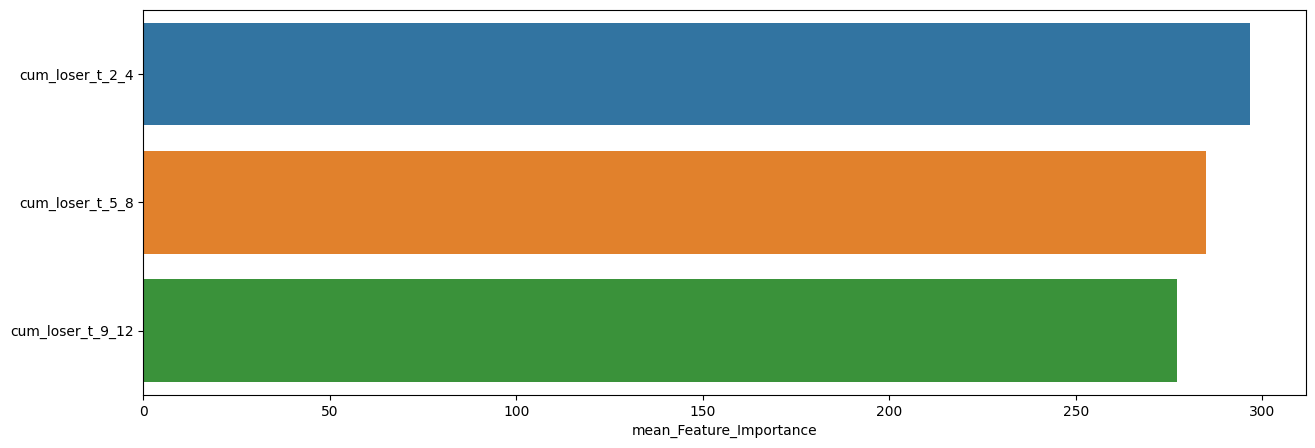

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                296.796460                     355   
cum_loser_t_5_8                284.836283                     351   
cum_loser_t_9_12               276.969027                     345   

                  min_Feature_Importance  
cum_loser_t_2_4                      226  
cum_loser_t_5_8                      235  
cum_loser_t_9_12                     234


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.22      0.26        96
         1.0       0.53      0.65      0.59       132

    accuracy                           0.47       228
   macro avg       0.42      0.44      0.42       228
weighted avg       0.44      0.47      0.45       228


accuracy : 0.4692982456140351

precision : 0.5341614906832298

recall : 0.6515151515151515

F1-Score : 0.5870307167235495



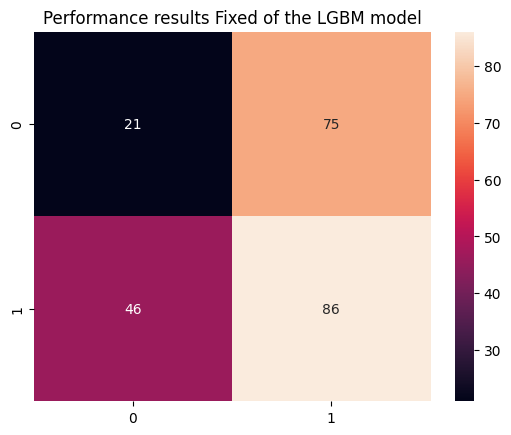


Feature Importance of the model



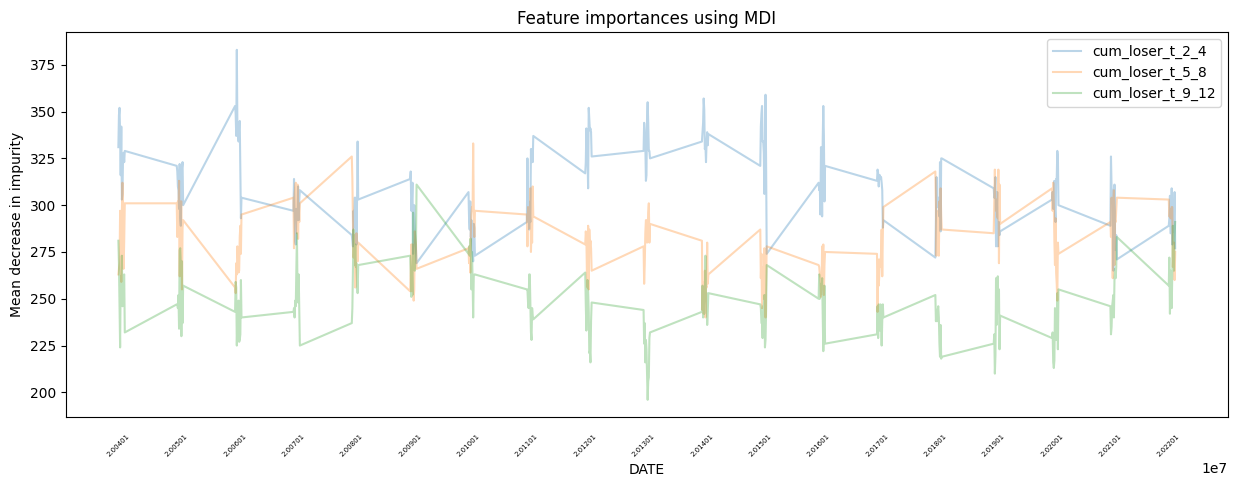

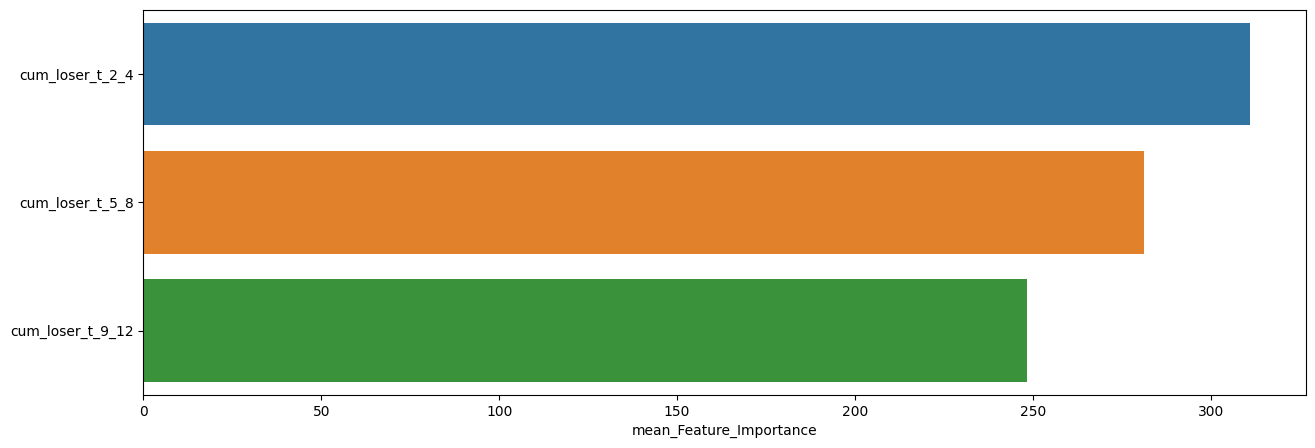

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                311.131579                     383   
cum_loser_t_5_8                281.206140                     333   
cum_loser_t_9_12               248.315789                     311   

                  min_Feature_Importance  
cum_loser_t_2_4                      265  
cum_loser_t_5_8                      240  
cum_loser_t_9_12                     196

In [111]:
slice_feature_importance(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Fixed', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



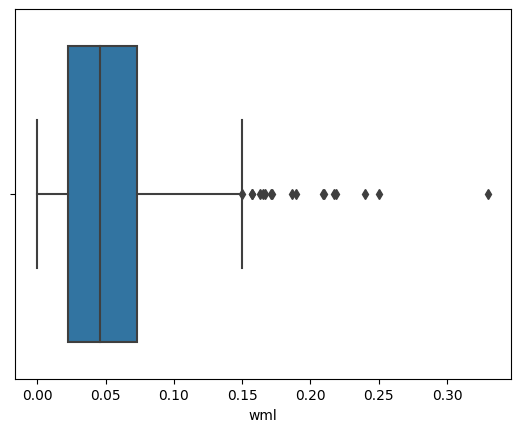

count     mean       std       min      25%      50%       75%       max
wml  438.0  0.05446  0.044537  0.000128  0.02234  0.04627  0.073386  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



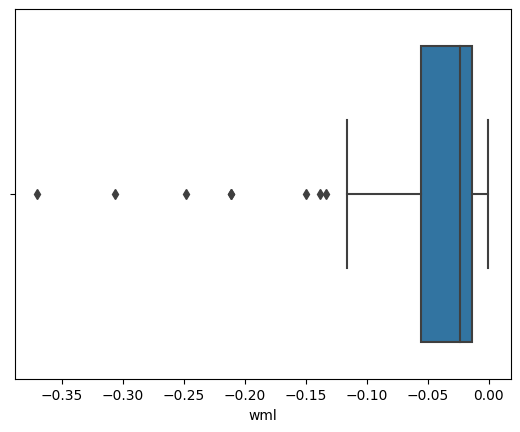

count      mean       std       min       25%       50%       75%  \
wml   64.0 -0.055226  0.074015 -0.370041 -0.055283 -0.023687 -0.013304   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



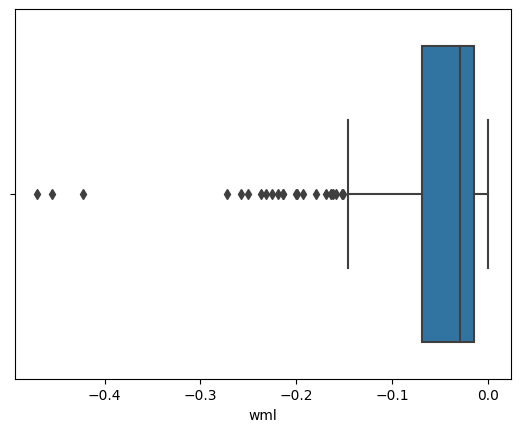

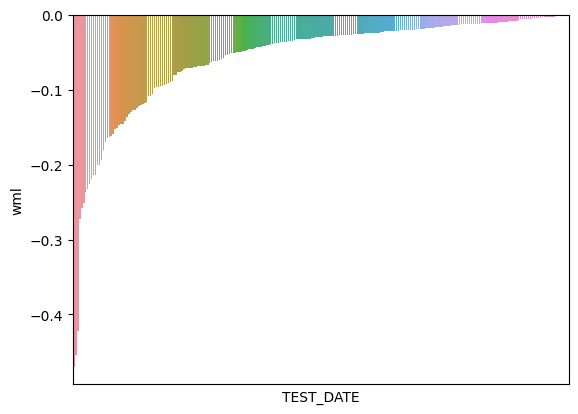

count      mean       std       min       25%       50%       75%  \
wml  252.0 -0.056587  0.070661 -0.469903 -0.069073 -0.029177 -0.015304   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



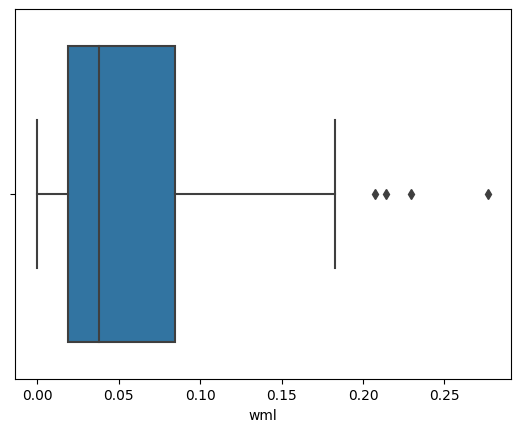

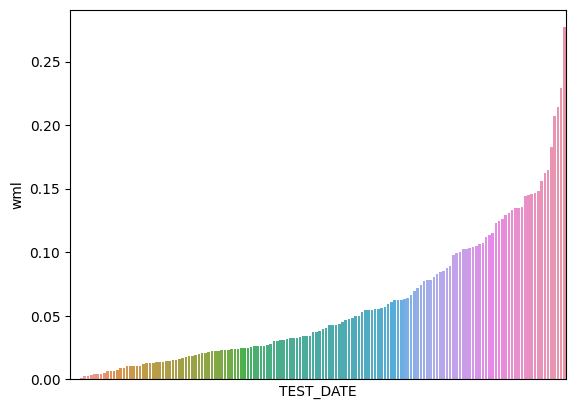

count      mean       std       min       25%       50%       75%  \
wml  152.0  0.057526  0.052916  0.000007  0.018785  0.037827  0.084413   

          max  
wml  0.276912

In [112]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Fixed_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.72569

최근 누적 수익률

  2022년-12월 -> 1526.25
  2022년-11월 -> 1375.02
  2022년-10월 -> 1307.89
  2022년-09월 -> 1307.89
  2022년-08월 -> 1307.89

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2000년-02월 -> 9752.06
  2등 : 2000년-10월 -> 8848.62
  3등 : 2000년-12월 -> 8848.62
  4등 : 2000년-11월 -> 8848.62
  5등 : 2000년-09월 -> 8484.95
  6등 : 2000년-08월 -> 8484.95
  7등 : 2000년-03월 -> 8264.44
  8등 : 2000년-06월 -> 7609.95
  9등 : 2000년-07월 -> 7581.69
  10등 : 2000년-04월 -> 7369.14



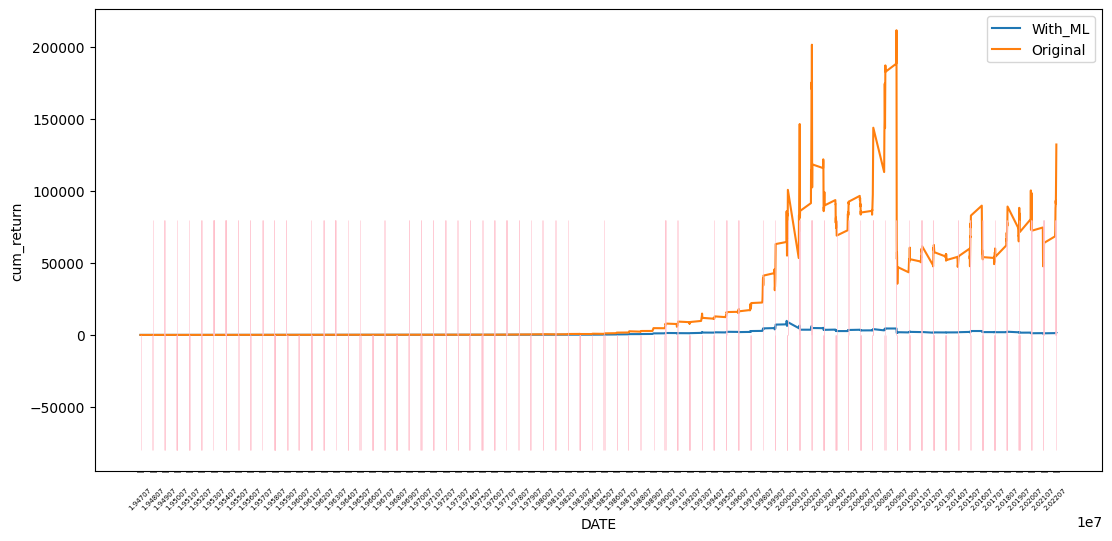

In [113]:
LGBM_F_CUM_RETURN_static = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.76186

최근 누적 수익률

  2022년-12월 -> 4451.67
  2022년-11월 -> 4085.38
  2022년-10월 -> 3934.34
  2022년-09월 -> 3751.38
  2022년-08월 -> 3580.83

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 6515.00
  2등 : 2002년-07월 -> 6174.44
  3등 : 2002년-06월 -> 6042.08
  4등 : 2002년-08월 -> 6004.13
  5등 : 2002년-10월 -> 5686.30
  6등 : 2009년-02월 -> 5651.98
  7등 : 2008년-11월 -> 5478.14
  8등 : 2009년-01월 -> 5464.43
  9등 : 2008년-12월 -> 5402.19
  10등 : 2003년-02월 -> 5383.33



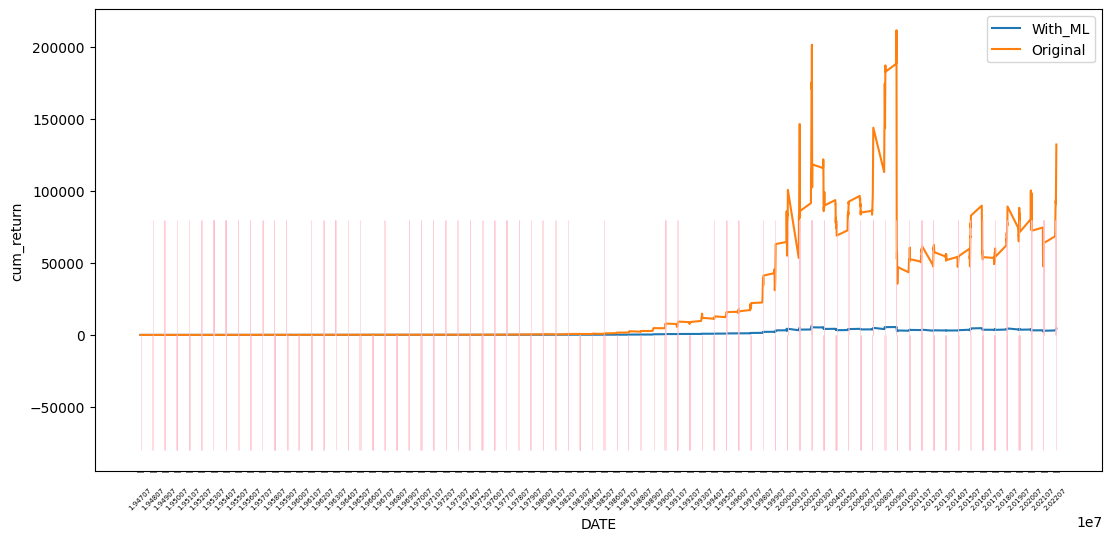

In [114]:
LGBM_F_CUM_RETURN_dynamic = cumm_return_by_dynamic(Fixed_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

## Rolling Expanding Windows

### Random Forest

In [115]:
RDF_Param={} 
RDF = RandomForestClassifier(**RDF_Param, random_state=42)

**************************************************

RDF Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   bootstrap : True
   ccp_alpha : 0.0
   class_weight : None
   criterion : gini
   max_depth : None
   max_features : sqrt
   max_leaf_nodes : None
   max_samples : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_jobs : None
   oob_score : False
   random_state : 42
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.31      0.16      0.21       316
         1.0       0.64      0.80      0.71       590

    accuracy                           0.58       906
   macro avg       0.47      0.48      0.46       906
weighted avg       0.52      0.58      0.54       906


accuracy : 0.5783664459161147

precision : 0.6413043478260869

recall : 0.8

F1-Score : 0.7119155354449472



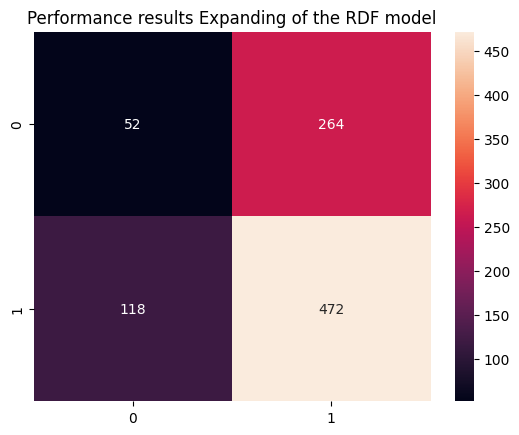


Feature Importance of the model



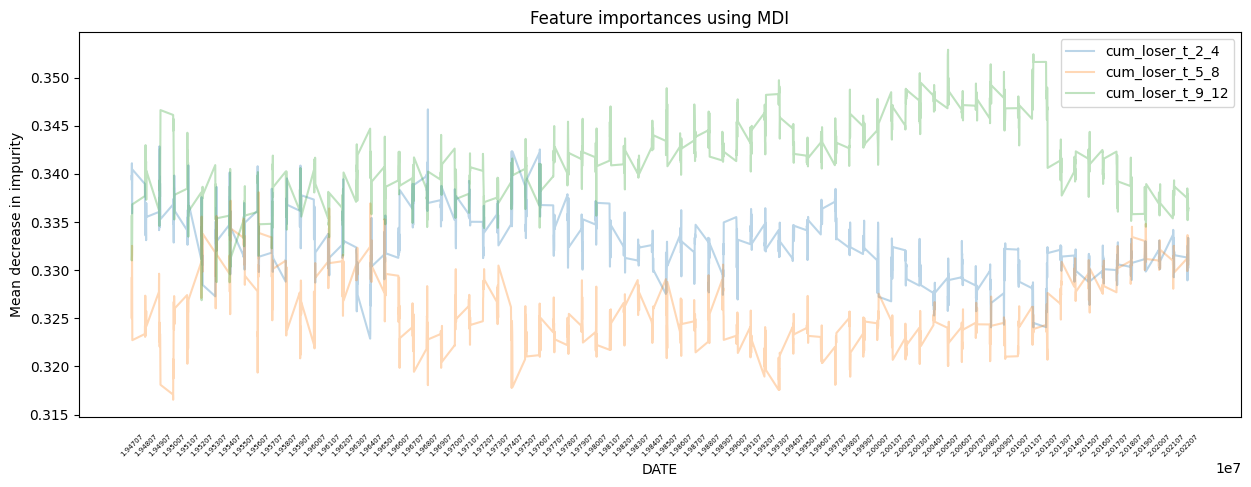

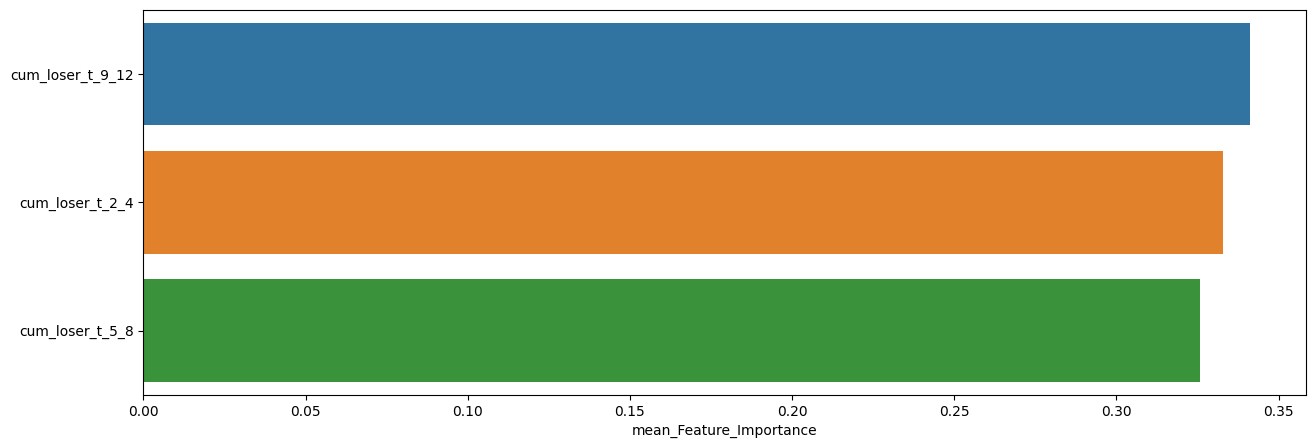

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.341315                0.352884   
cum_loser_t_2_4                  0.332822                0.346692   
cum_loser_t_5_8                  0.325863                0.338082   

                  min_Feature_Importance  
cum_loser_t_9_12                0.326872  
cum_loser_t_2_4                 0.322880  
cum_loser_t_5_8                 0.316535

In [116]:
Expanding_RDF_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=RDF, # 사용할 모델
                                      model_name='RDF', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.28      0.17      0.21        75
         1.0       0.65      0.77      0.71       151

    accuracy                           0.58       226
   macro avg       0.47      0.47      0.46       226
weighted avg       0.53      0.58      0.54       226


accuracy : 0.5752212389380531

precision : 0.6536312849162011

recall : 0.7748344370860927

F1-Score : 0.709090909090909



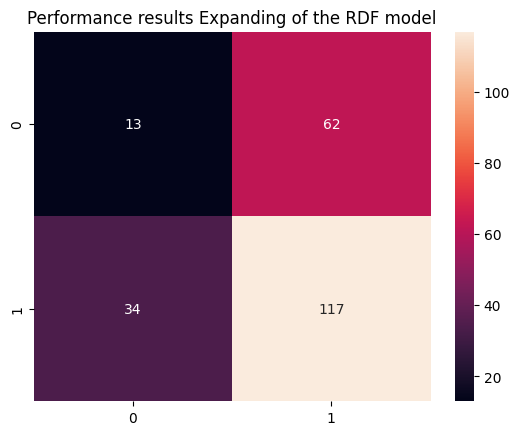


Feature Importance of the model



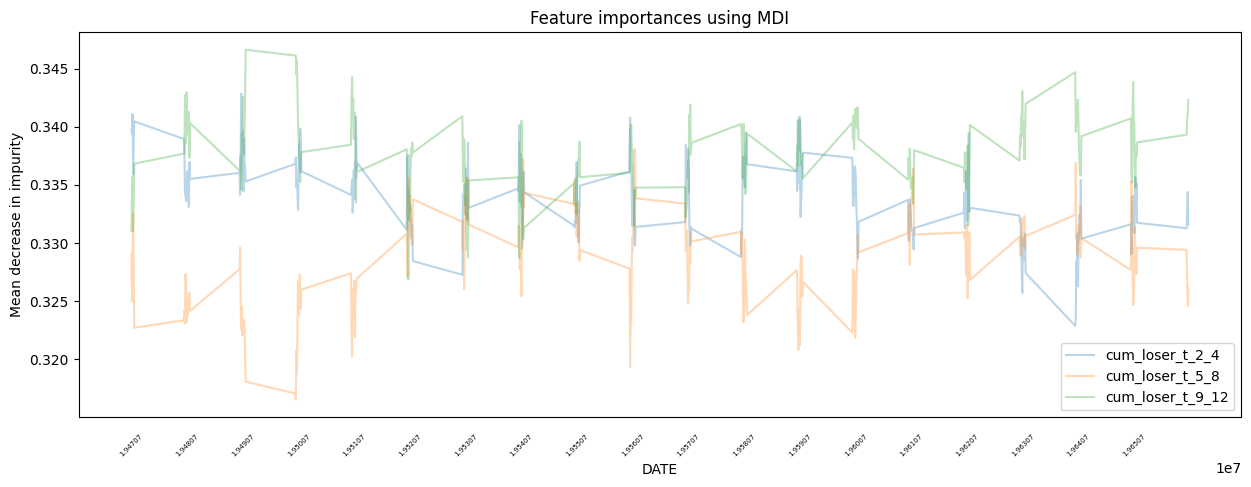

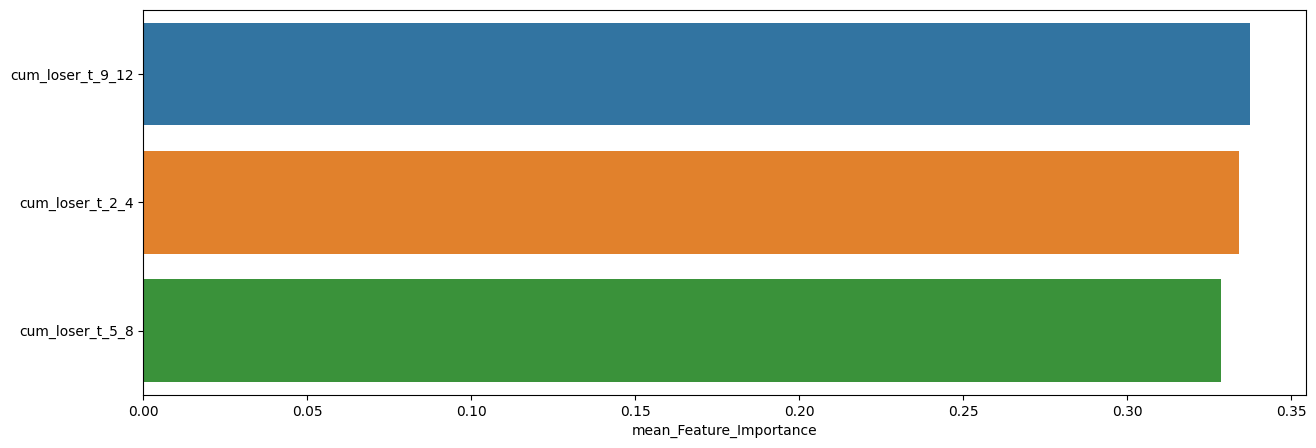

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.337597                0.346616   
cum_loser_t_2_4                  0.333947                0.342847   
cum_loser_t_5_8                  0.328456                0.338082   

                  min_Feature_Importance  
cum_loser_t_9_12                0.326872  
cum_loser_t_2_4                 0.322880  
cum_loser_t_5_8                 0.316535


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.23      0.27        75
         1.0       0.67      0.77      0.72       151

    accuracy                           0.59       226
   macro avg       0.50      0.50      0.49       226
weighted avg       0.56      0.59      0.57       226


accuracy : 0.5929203539823009

precision : 0.6685714285714286

recall : 0.7748344370860927

F1-Score : 0.7177914110429447



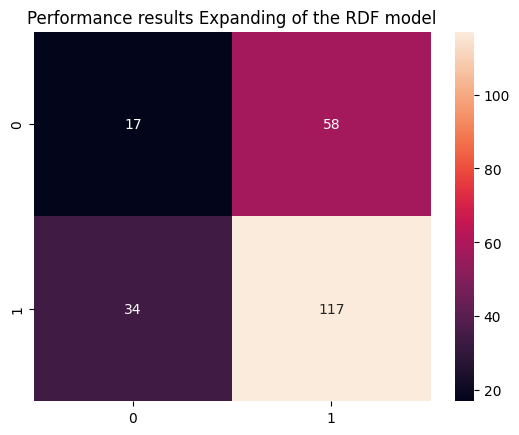


Feature Importance of the model



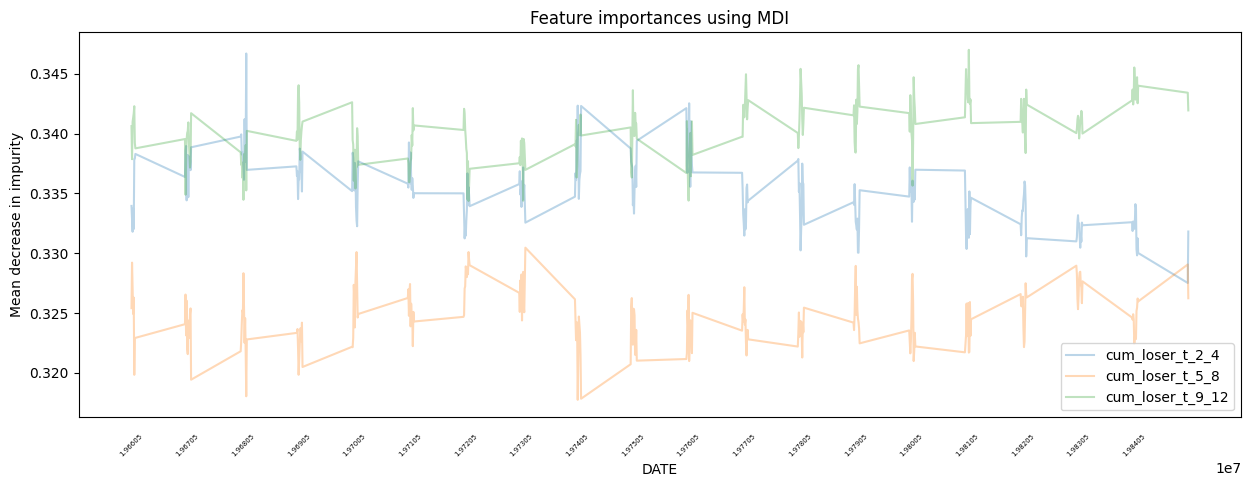

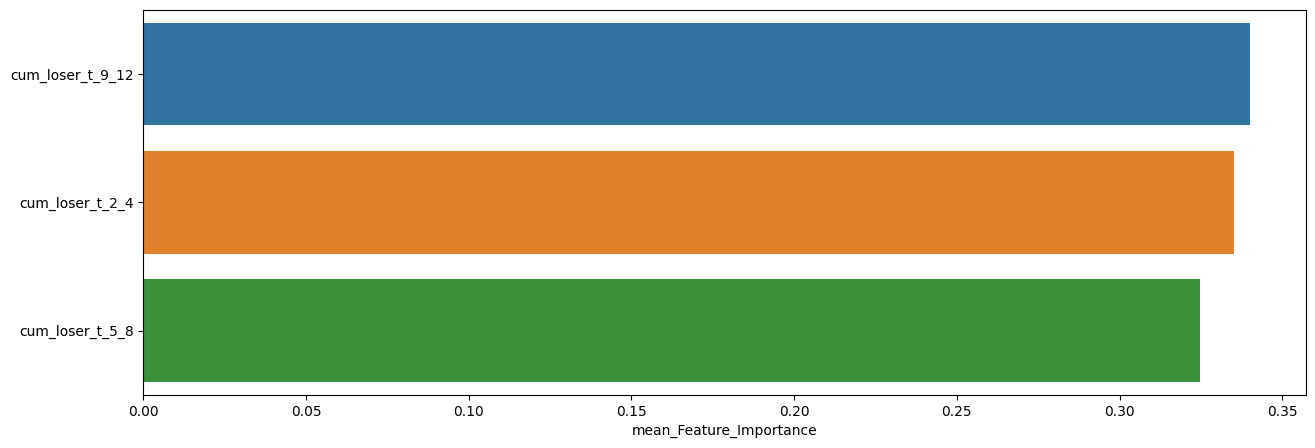

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.340227                0.347000   
cum_loser_t_2_4                  0.335191                0.346692   
cum_loser_t_5_8                  0.324582                0.330469   

                  min_Feature_Importance  
cum_loser_t_9_12                0.334368  
cum_loser_t_2_4                 0.327519  
cum_loser_t_5_8                 0.317755


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.17      0.23        70
         1.0       0.70      0.87      0.77       156

    accuracy                           0.65       226
   macro avg       0.53      0.52      0.50       226
weighted avg       0.60      0.65      0.61       226


accuracy : 0.6504424778761062

precision : 0.6994818652849741

recall : 0.8653846153846154

F1-Score : 0.7736389684813755



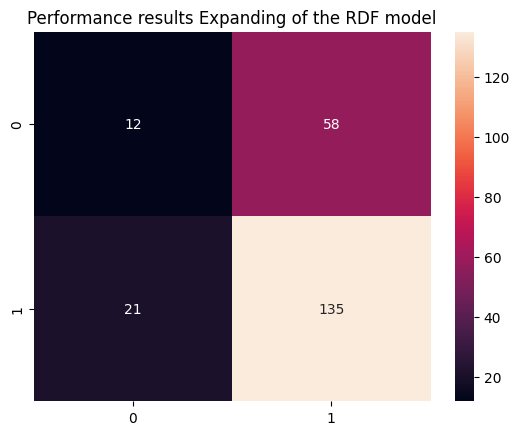


Feature Importance of the model



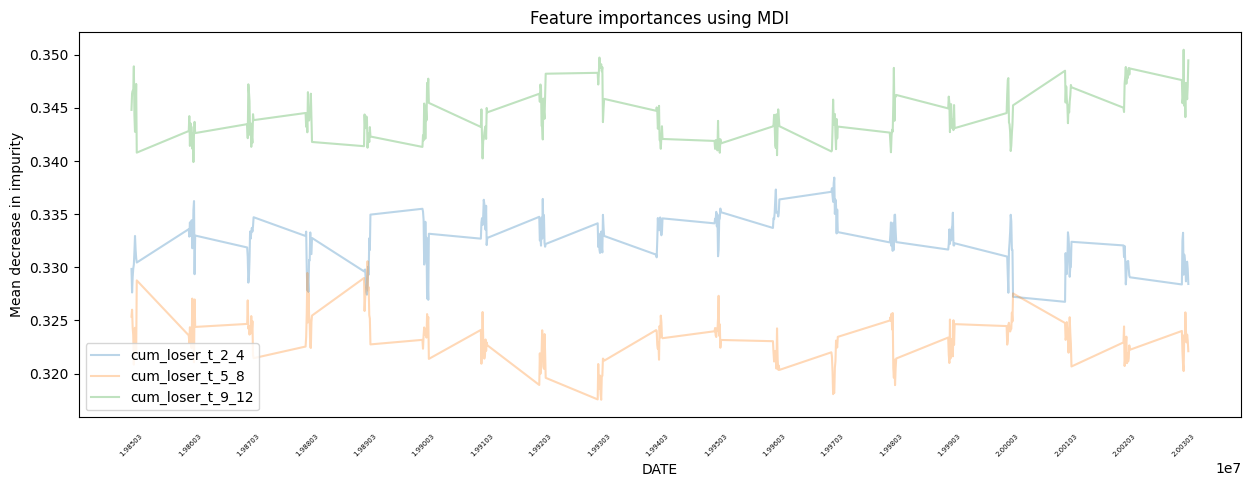

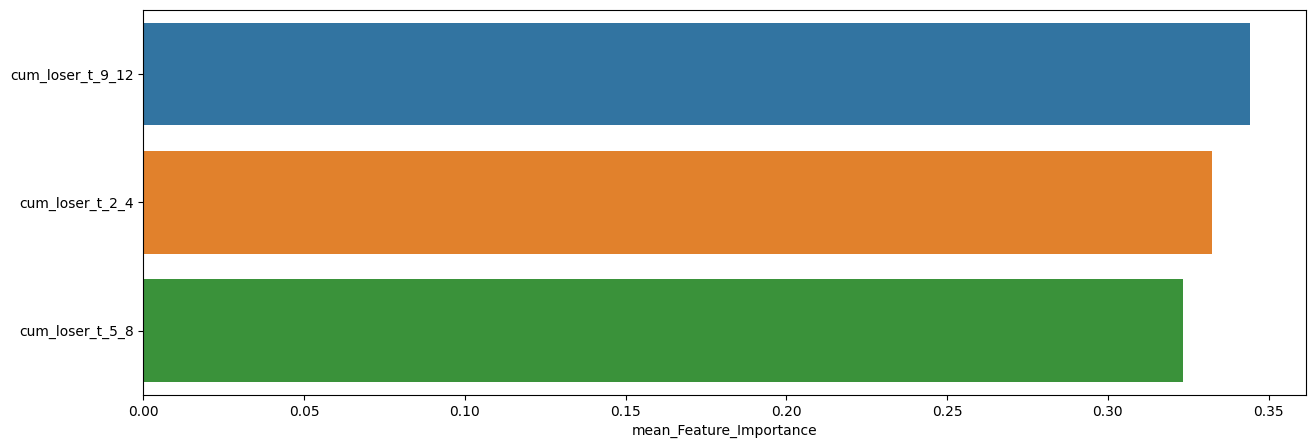

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.344343                0.350453   
cum_loser_t_2_4                  0.332450                0.338434   
cum_loser_t_5_8                  0.323207                0.330569   

                  min_Feature_Importance  
cum_loser_t_9_12                0.339893  
cum_loser_t_2_4                 0.326756  
cum_loser_t_5_8                 0.317550


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.26      0.10      0.15        96
         1.0       0.54      0.78      0.64       132

    accuracy                           0.50       228
   macro avg       0.40      0.44      0.39       228
weighted avg       0.42      0.50      0.43       228


accuracy : 0.4956140350877193

precision : 0.544973544973545

recall : 0.7803030303030303

F1-Score : 0.6417445482866043



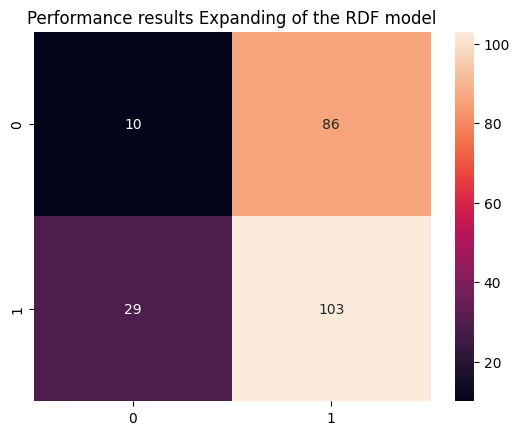


Feature Importance of the model



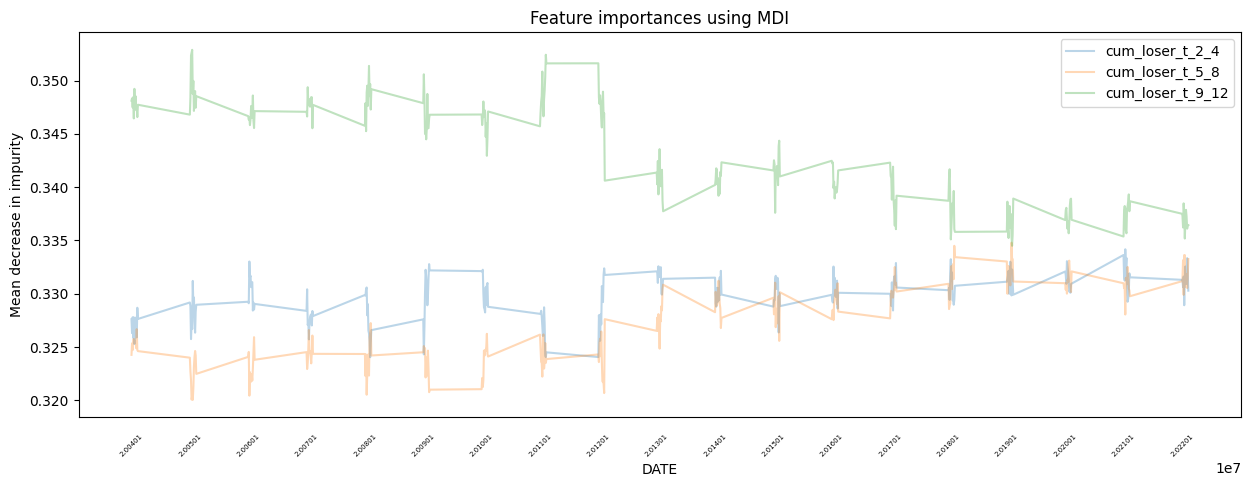

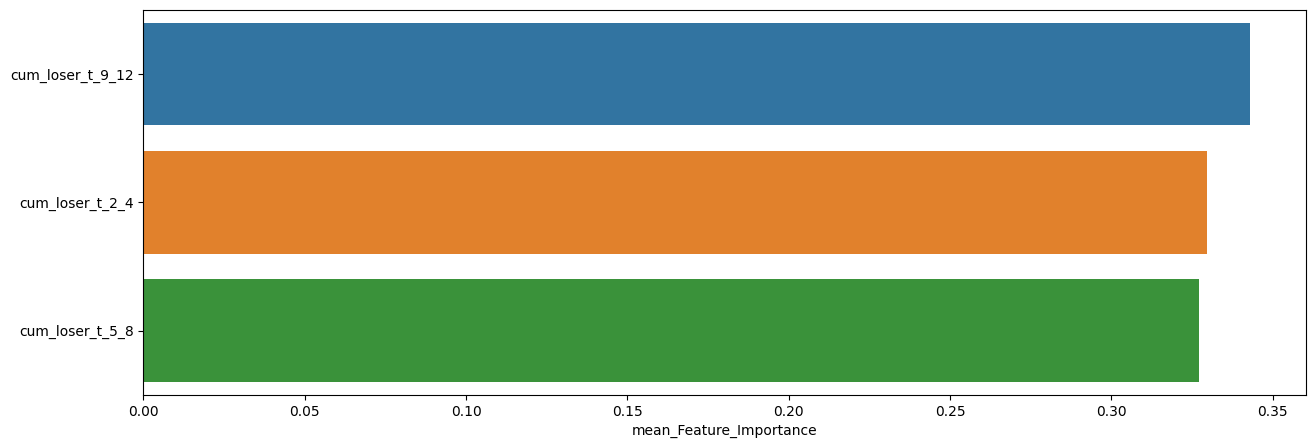

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.343079                0.352884   
cum_loser_t_2_4                  0.329726                0.334176   
cum_loser_t_5_8                  0.327195                0.334800   

                  min_Feature_Importance  
cum_loser_t_9_12                0.334506  
cum_loser_t_2_4                 0.324055  
cum_loser_t_5_8                 0.320055

In [117]:
slice_feature_importance(Expanding_RDF_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'RDF') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



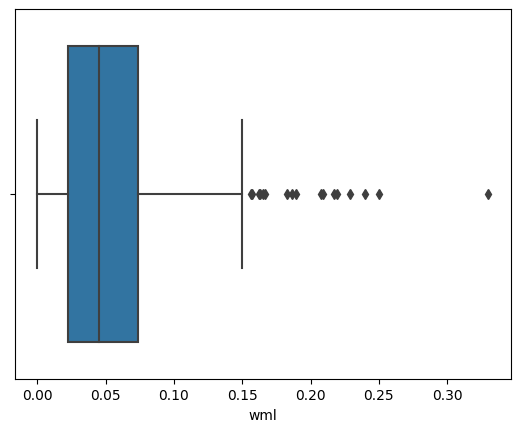

count      mean      std       min       25%       50%       75%  \
wml  472.0  0.054135  0.04489  0.000007  0.022192  0.045416  0.073654   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



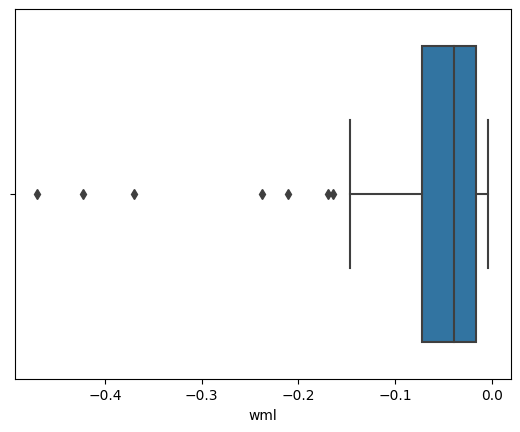

count      mean       std       min       25%       50%      75%  \
wml   52.0 -0.074779  0.101644 -0.469903 -0.072141 -0.039431 -0.01607   

          max  
wml -0.003458


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



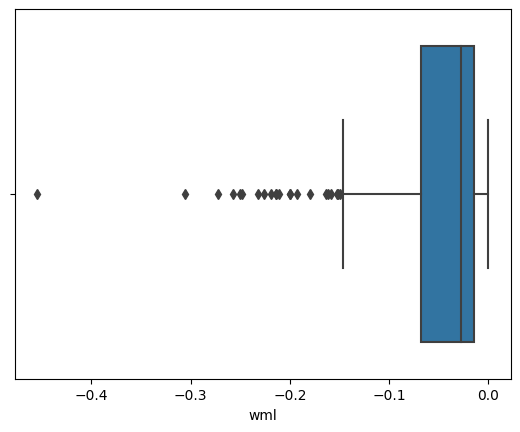

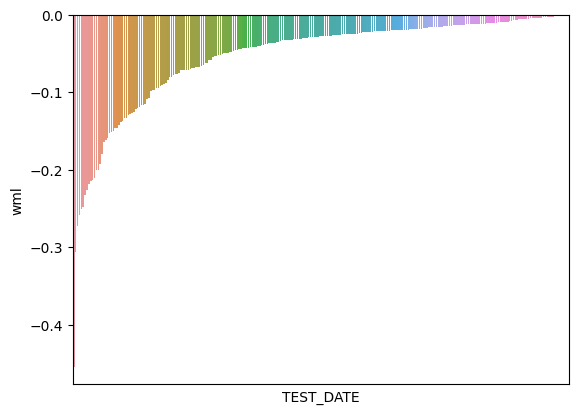

count      mean       std       min       25%       50%       75%  \
wml  264.0 -0.052673  0.063195 -0.454349 -0.067829 -0.027467 -0.014532   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



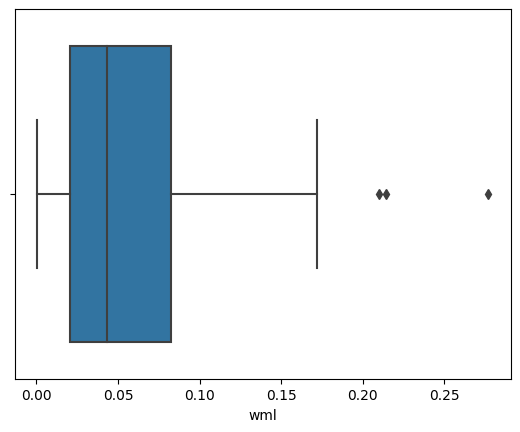

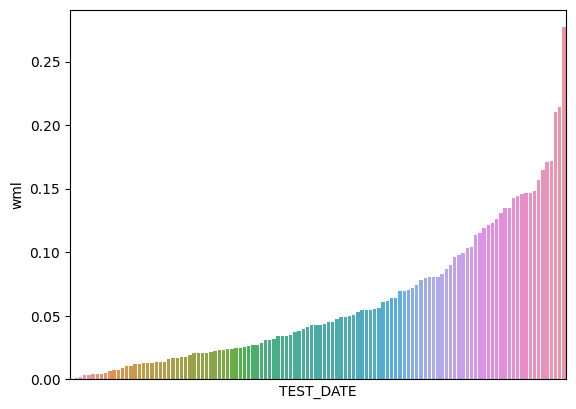

count      mean       std       min       25%       50%       75%  \
wml  118.0  0.059708  0.053797  0.000577  0.020572  0.042982  0.082392   

          max  
wml  0.276912

In [118]:
RDF_A0_P1, RDF_A1_P0 = What_Pred(Expanding_RDF_Result, WML, 'RDF')

Sharpe Ratio : 0.69511

최근 누적 수익률

  2022년-12월 -> 13659.69
  2022년-11월 -> 12307.04
  2022년-10월 -> 11706.55
  2022년-09월 -> 10365.89
  2022년-08월 -> 9424.04

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2007년-12월 -> 21383.07
  2등 : 2007년-11월 -> 19852.43
  3등 : 2002년-09월 -> 19505.13
  4등 : 2009년-02월 -> 19057.26
  5등 : 2009년-01월 -> 19057.26
  6등 : 2008년-12월 -> 19057.26
  7등 : 2008년-11월 -> 19057.26
  8등 : 2008년-10월 -> 19057.26
  9등 : 2009년-03월 -> 19057.26
  10등 : 2001년-09월 -> 18941.57



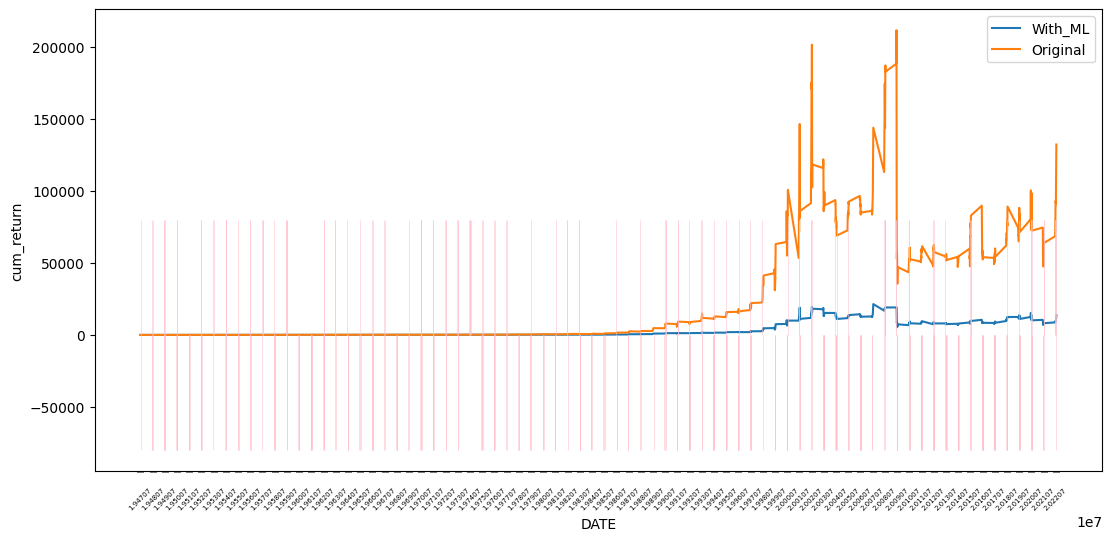

In [119]:
RDF_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PRED_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.71323

최근 누적 수익률

  2022년-12월 -> 8759.48
  2022년-11월 -> 7994.97
  2022년-10월 -> 7664.69
  2022년-09월 -> 7053.46
  2022년-08월 -> 6623.19

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2022년-12월 -> 8759.48
  2등 : 2009년-02월 -> 8168.91
  3등 : 2020년-03월 -> 8026.72
  4등 : 2022년-11월 -> 7994.97
  5등 : 2009년-01월 -> 7896.81
  6등 : 2008년-11월 -> 7854.35
  7등 : 2008년-12월 -> 7809.73
  8등 : 2022년-10월 -> 7664.69
  9등 : 2008년-10월 -> 7513.22
  10등 : 2009년-03월 -> 7478.72



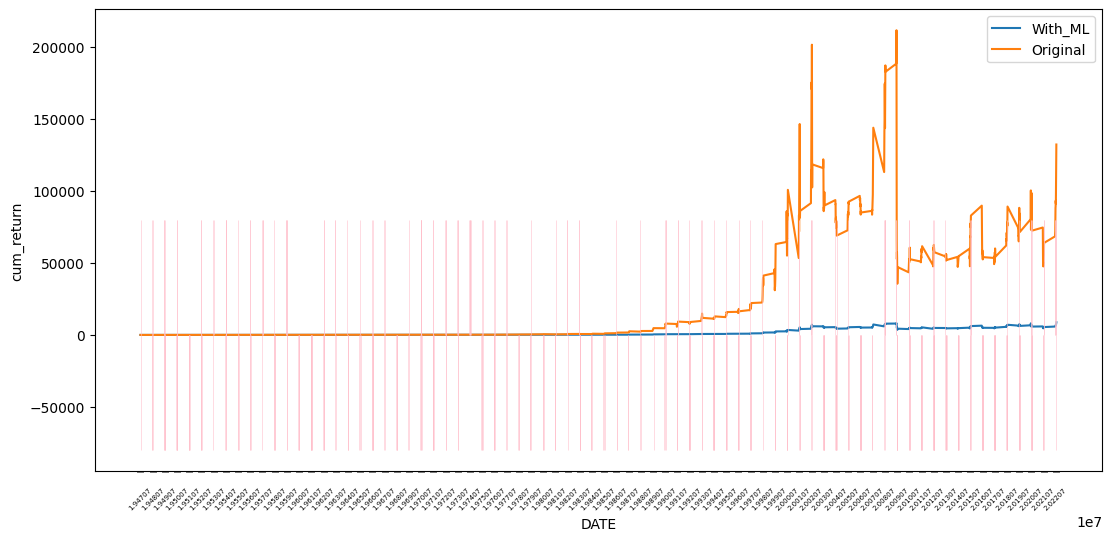

In [120]:
RDF_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_RDF_Result,
                                                 WML,
                                                 'RDF_PROB_POS_WML',
                                                 RDF_A0_P1,
                                                 RDF_A1_P0,
                                                 plot=True)

### Grdient Boosting

In [121]:
GBC_Param = {}
GBC = GradientBoostingClassifier(*GBC_Param, random_state=42)

**************************************************

GBC Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   ccp_alpha : 0.0
   criterion : friedman_mse
   init : None
   learning_rate : 0.1
   loss : log_loss
   max_depth : 3
   max_features : None
   max_leaf_nodes : None
   min_impurity_decrease : 0.0
   min_samples_leaf : 1
   min_samples_split : 2
   min_weight_fraction_leaf : 0.0
   n_estimators : 100
   n_iter_no_change : None
   random_state : 42
   subsample : 1.0
   tol : 0.0001
   validation_fraction : 0.1
   verbose : 0
   warm_start : False

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.13      0.19       316
         1.0       0.65      0.86      0.74       590

    accuracy                           0.60       906
   macro avg       0.49      0.49      0.46       906
weighted avg       0.54      0.60      0.55       906


accuracy : 0.6037527593818984

precision : 0.6482670089858793

recall : 0.8559322033898306

F1-Score : 0.7377647918188459



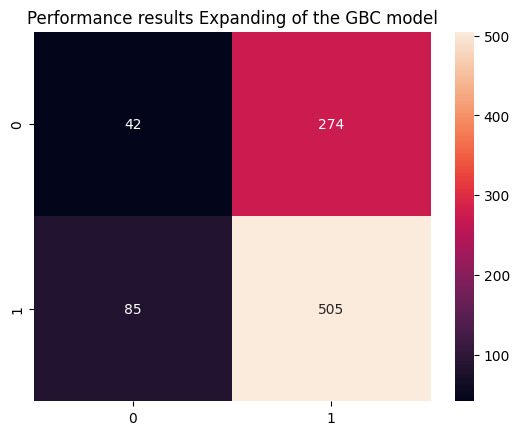


Feature Importance of the model



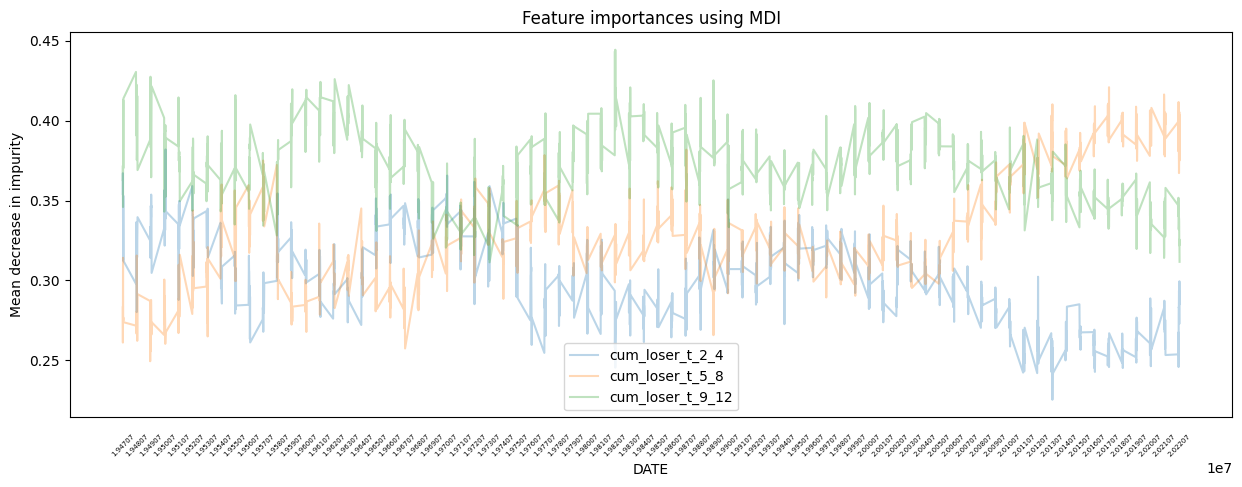

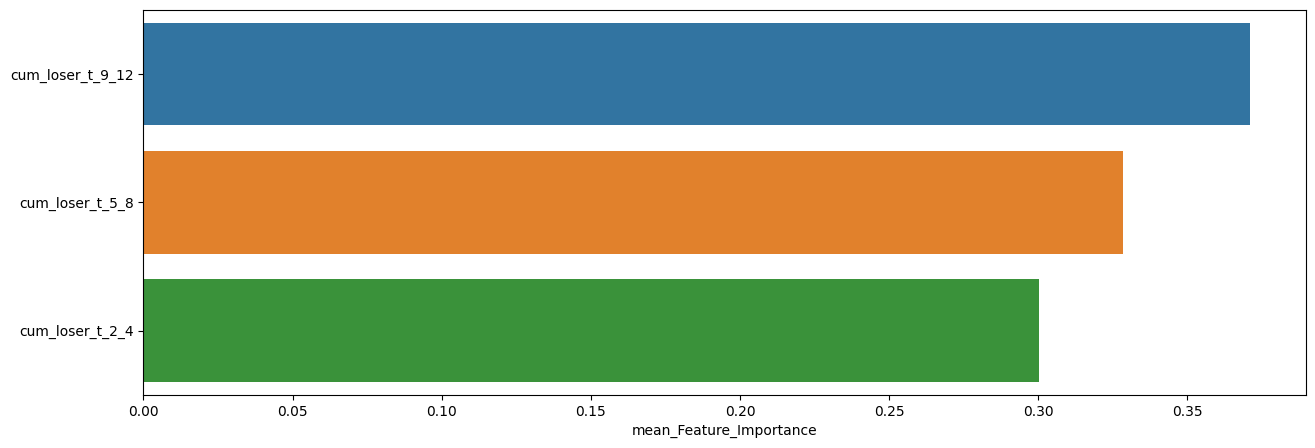

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.371122                0.444461   
cum_loser_t_5_8                  0.328506                0.420978   
cum_loser_t_2_4                  0.300372                0.381981   

                  min_Feature_Importance  
cum_loser_t_9_12                0.311287  
cum_loser_t_5_8                 0.249318  
cum_loser_t_2_4                 0.225196

In [122]:
Expanding_GBC_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                      window_size=240, # window size (훈련 데이터 셋 크기)
                                      method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                      model=GBC, # 사용할 모델
                                      model_name='GBC', # 사용한 모델 명
                                      plot=True, # 모델 성능 지표 시각화 여부
                                      plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.20      0.26        75
         1.0       0.68      0.83      0.74       151

    accuracy                           0.62       226
   macro avg       0.52      0.51      0.50       226
weighted avg       0.57      0.62      0.58       226


accuracy : 0.6194690265486725

precision : 0.6756756756756757

recall : 0.8278145695364238

F1-Score : 0.744047619047619



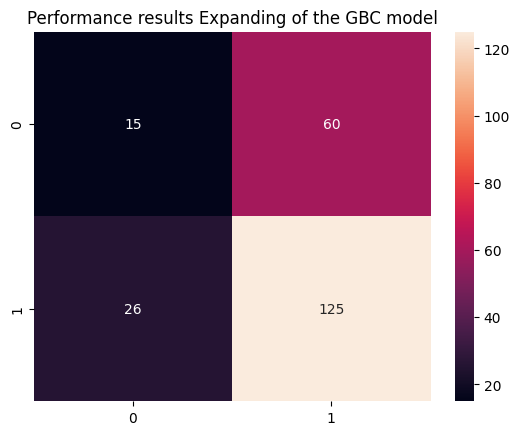


Feature Importance of the model



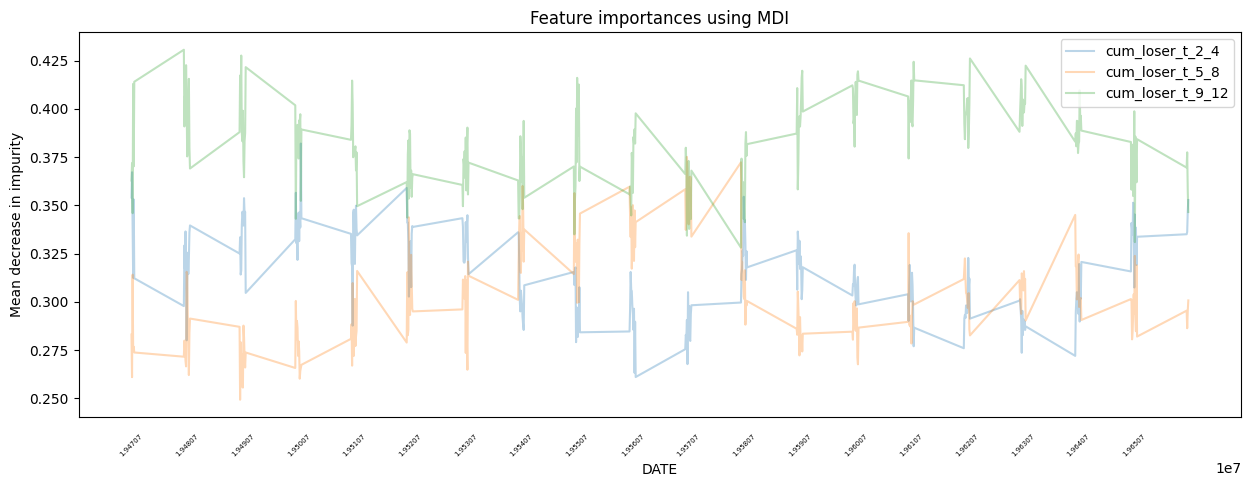

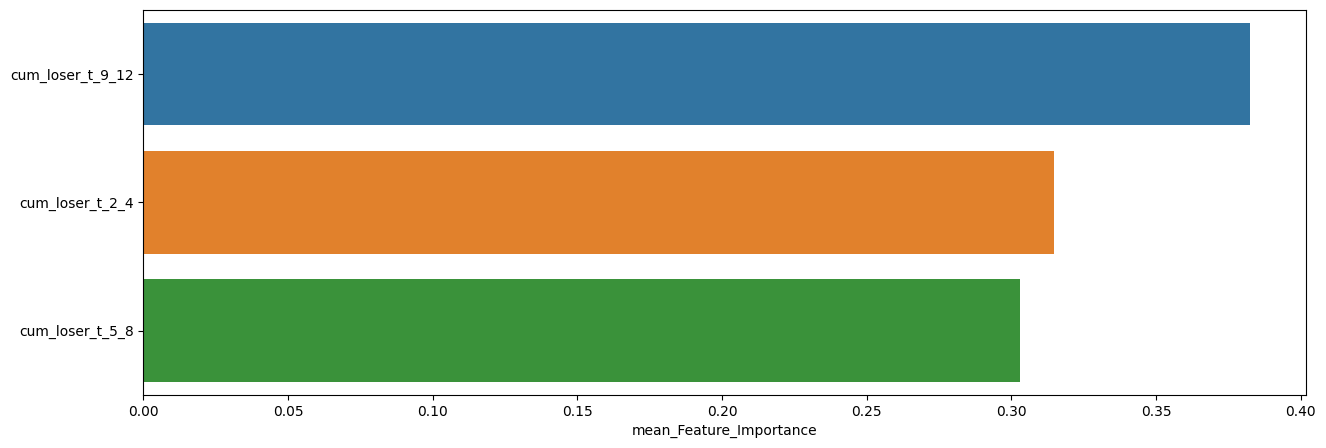

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.382592                0.430573   
cum_loser_t_2_4                  0.314609                0.381981   
cum_loser_t_5_8                  0.302799                0.375059   

                  min_Feature_Importance  
cum_loser_t_9_12                0.328077  
cum_loser_t_2_4                 0.261077  
cum_loser_t_5_8                 0.249318


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.30      0.17      0.22        75
         1.0       0.66      0.79      0.72       151

    accuracy                           0.59       226
   macro avg       0.48      0.48      0.47       226
weighted avg       0.54      0.59      0.55       226


accuracy : 0.588495575221239

precision : 0.6593406593406593

recall : 0.7947019867549668

F1-Score : 0.7207207207207207



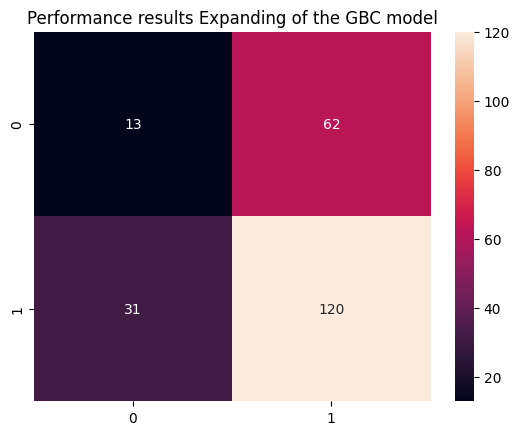


Feature Importance of the model



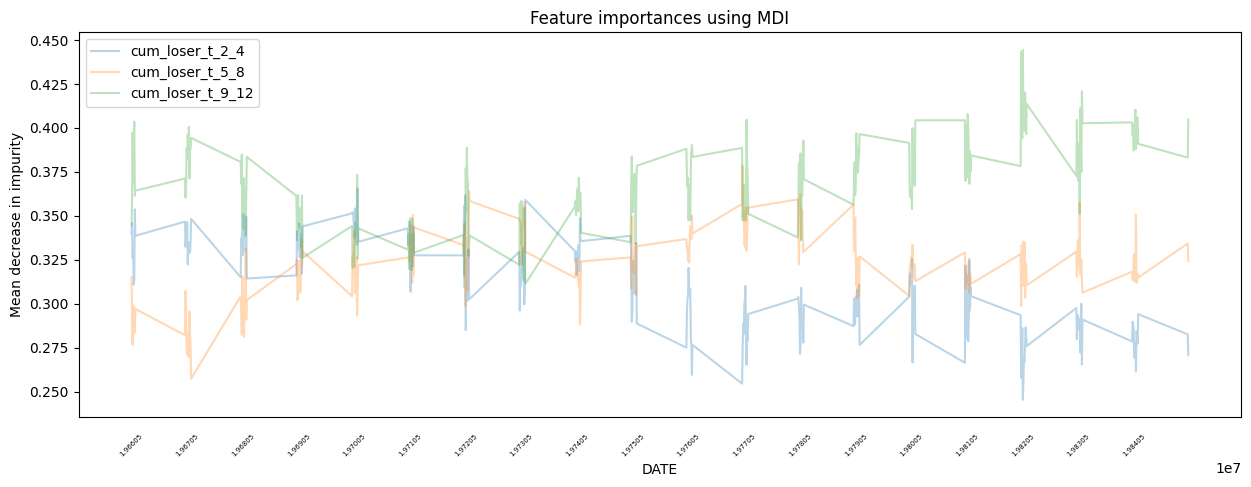

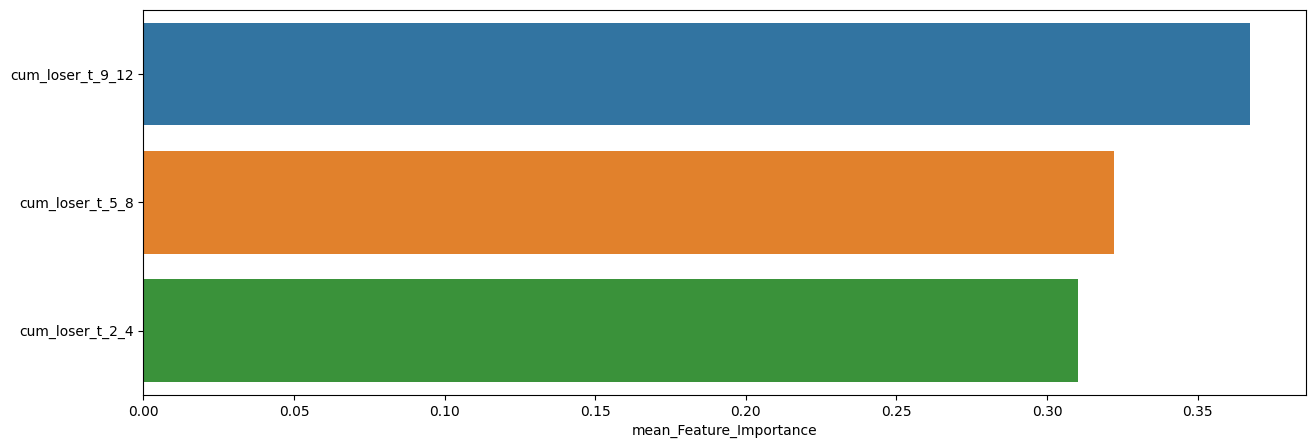

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.367530                0.444461   
cum_loser_t_5_8                  0.322248                0.378441   
cum_loser_t_2_4                  0.310222                0.365623   

                  min_Feature_Importance  
cum_loser_t_9_12                0.311287  
cum_loser_t_5_8                 0.257312  
cum_loser_t_2_4                 0.245325


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.39      0.10      0.16        70
         1.0       0.70      0.93      0.80       156

    accuracy                           0.67       226
   macro avg       0.54      0.51      0.48       226
weighted avg       0.60      0.67      0.60       226


accuracy : 0.672566371681416

precision : 0.6971153846153846

recall : 0.9294871794871795

F1-Score : 0.7967032967032968



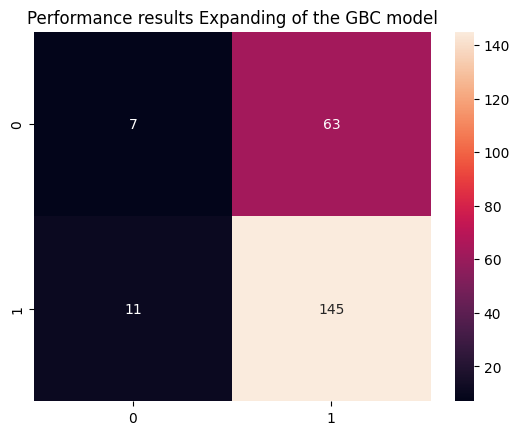


Feature Importance of the model



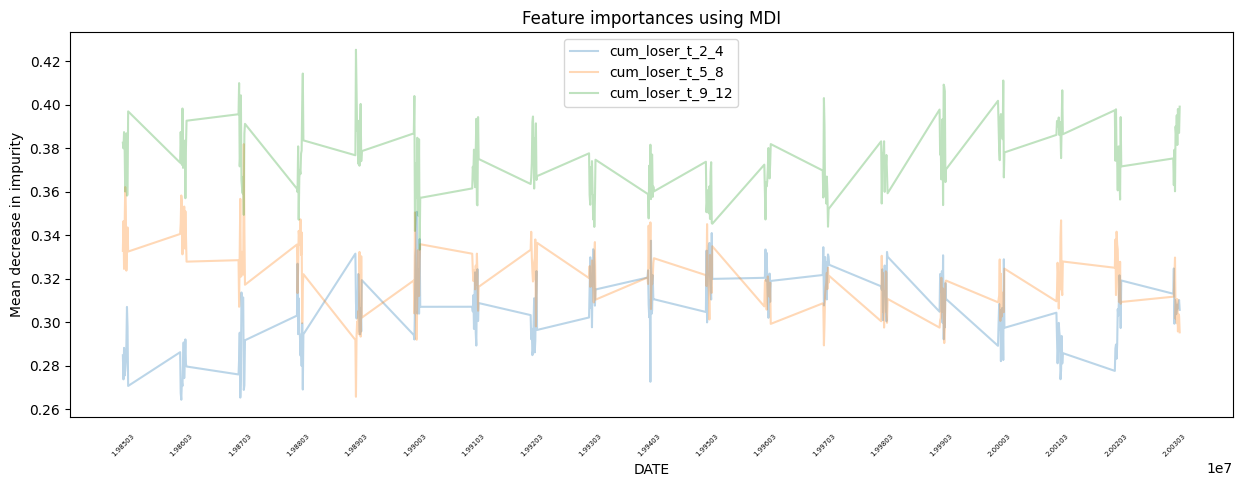

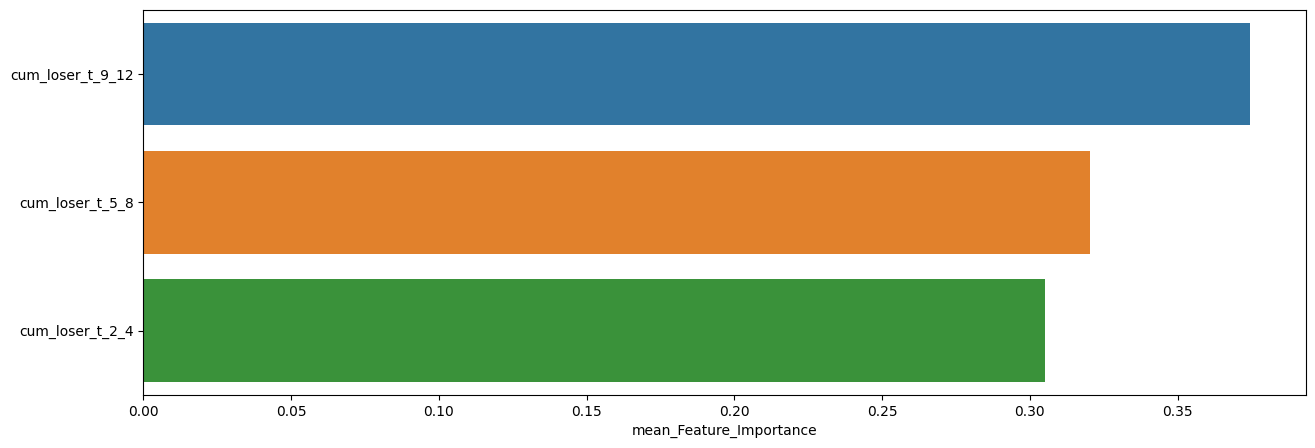

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.374637                0.425288   
cum_loser_t_5_8                  0.320200                0.381862   
cum_loser_t_2_4                  0.305163                0.350737   

                  min_Feature_Importance  
cum_loser_t_9_12                0.333318  
cum_loser_t_5_8                 0.265643  
cum_loser_t_2_4                 0.264274


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.29      0.07      0.12        96
         1.0       0.56      0.87      0.68       132

    accuracy                           0.54       228
   macro avg       0.43      0.47      0.40       228
weighted avg       0.45      0.54      0.45       228


accuracy : 0.5350877192982456

precision : 0.5637254901960784

recall : 0.8712121212121212

F1-Score : 0.6845238095238094



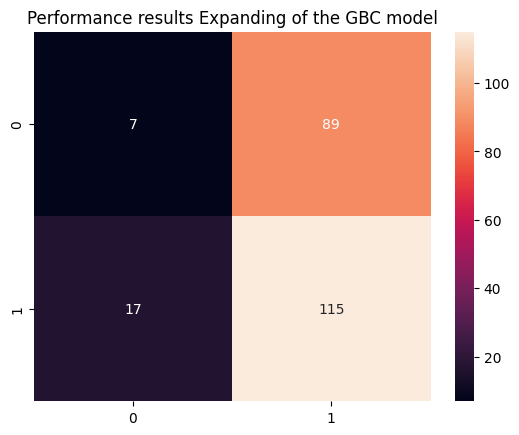


Feature Importance of the model



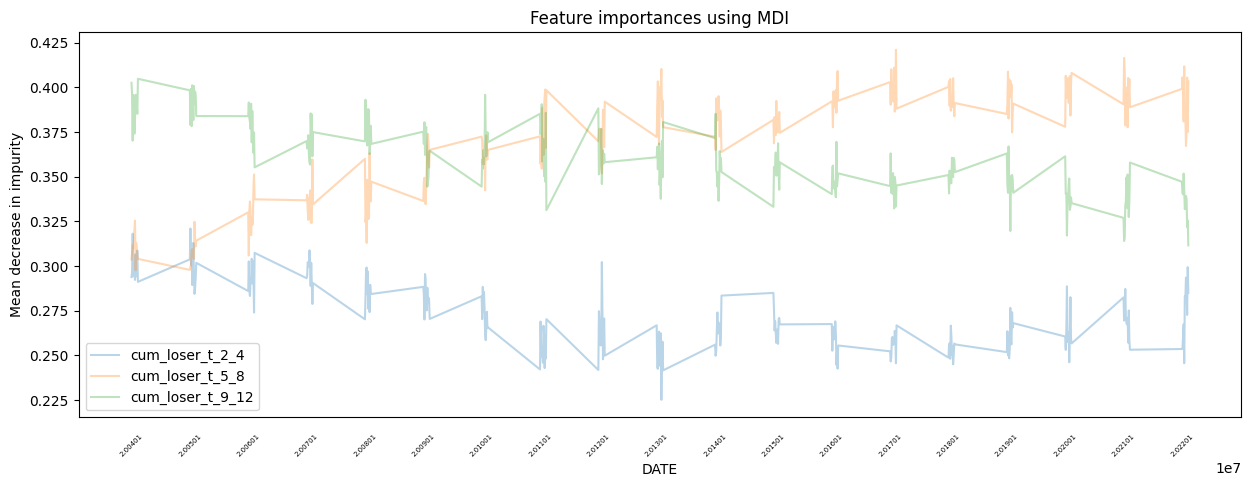

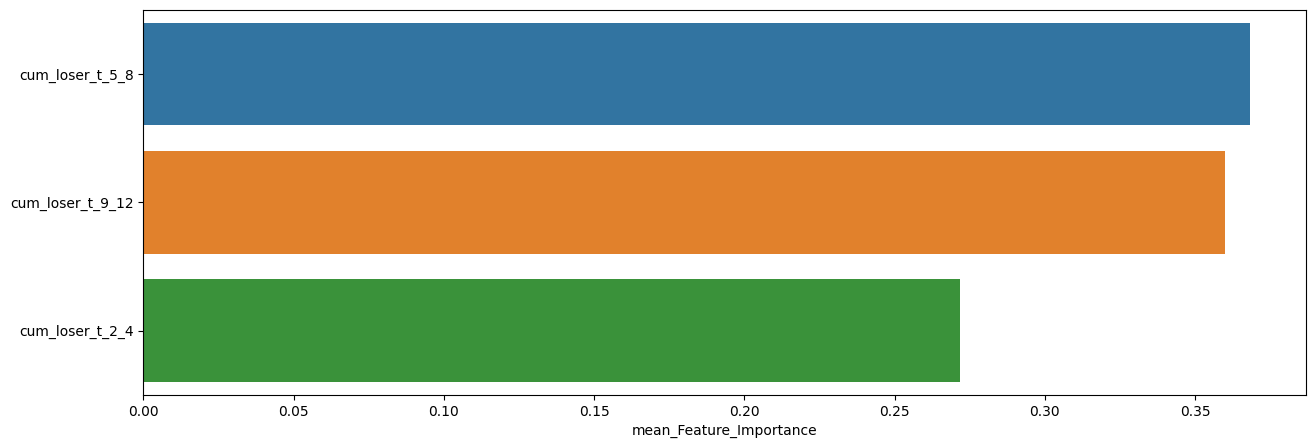

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_5_8                  0.368422                0.420978   
cum_loser_t_9_12                 0.359830                0.404775   
cum_loser_t_2_4                  0.271748                0.321033   

                  min_Feature_Importance  
cum_loser_t_5_8                 0.297617  
cum_loser_t_9_12                0.311595  
cum_loser_t_2_4                 0.225196

In [123]:
slice_feature_importance(Expanding_GBC_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'GBC') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



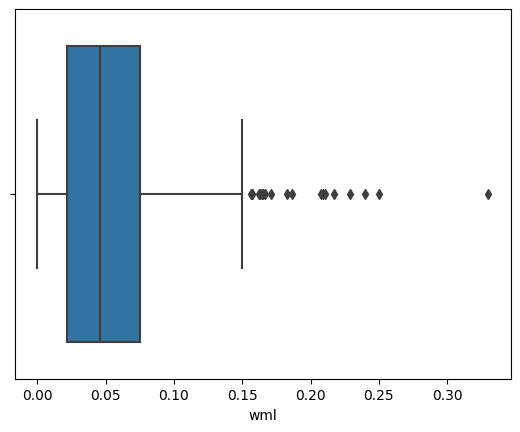

count      mean       std       min       25%       50%       75%  \
wml  505.0  0.054378  0.044955  0.000007  0.021888  0.046139  0.075043   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



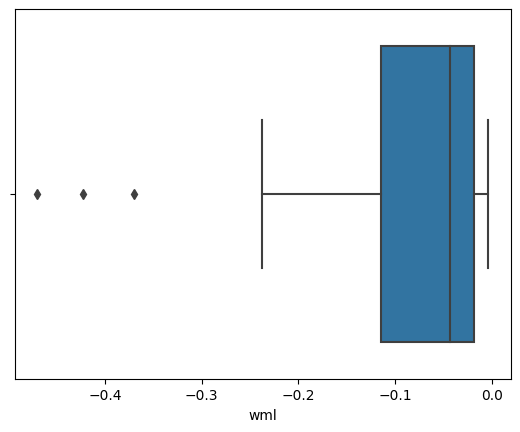

count      mean       std       min      25%       50%       75%  \
wml   42.0 -0.086514  0.110427 -0.469903 -0.11445 -0.042658 -0.018451   

          max  
wml -0.003446


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



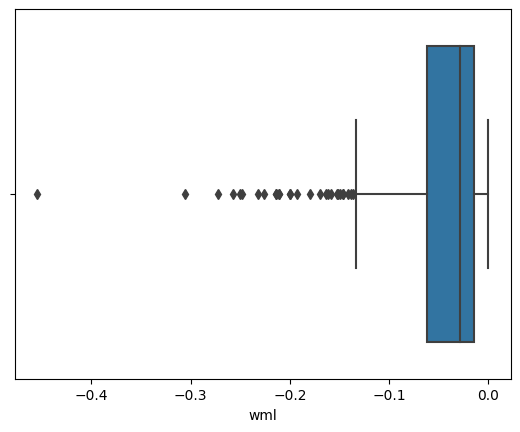

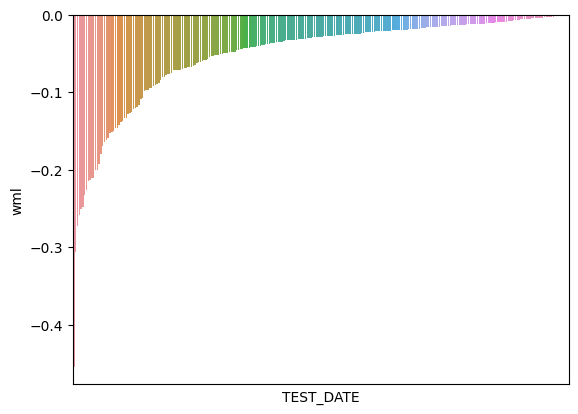

count      mean       std       min       25%       50%       75%  \
wml  274.0 -0.051681  0.062144 -0.454349 -0.062139 -0.028293 -0.014281   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



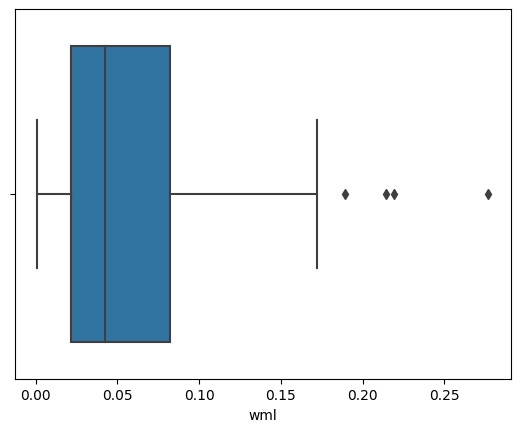

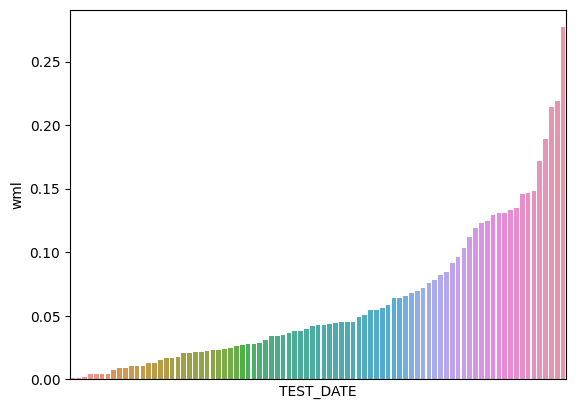

count      mean       std       min       25%       50%       75%  \
wml   85.0  0.060429  0.056638  0.000996  0.021479  0.042611  0.082184   

          max  
wml  0.276912

In [124]:
GBC_A0_P1, GBC_A1_P0 = What_Pred(Expanding_GBC_Result, WML, 'GBC')

Sharpe Ratio : 0.68881

최근 누적 수익률

  2022년-12월 -> 65592.85
  2022년-11월 -> 59097.91
  2022년-10월 -> 56214.54
  2022년-09월 -> 56214.54
  2022년-08월 -> 51107.30

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-03월 -> 83994.19
  2등 : 2009년-02월 -> 83994.19
  3등 : 2009년-01월 -> 83994.19
  4등 : 2007년-12월 -> 83670.54
  5등 : 2008년-06월 -> 83301.73
  6등 : 2008년-10월 -> 81471.22
  7등 : 2008년-11월 -> 81471.22
  8등 : 2008년-12월 -> 81471.22
  9등 : 2007년-11월 -> 77681.45
  10등 : 2002년-09월 -> 77252.05



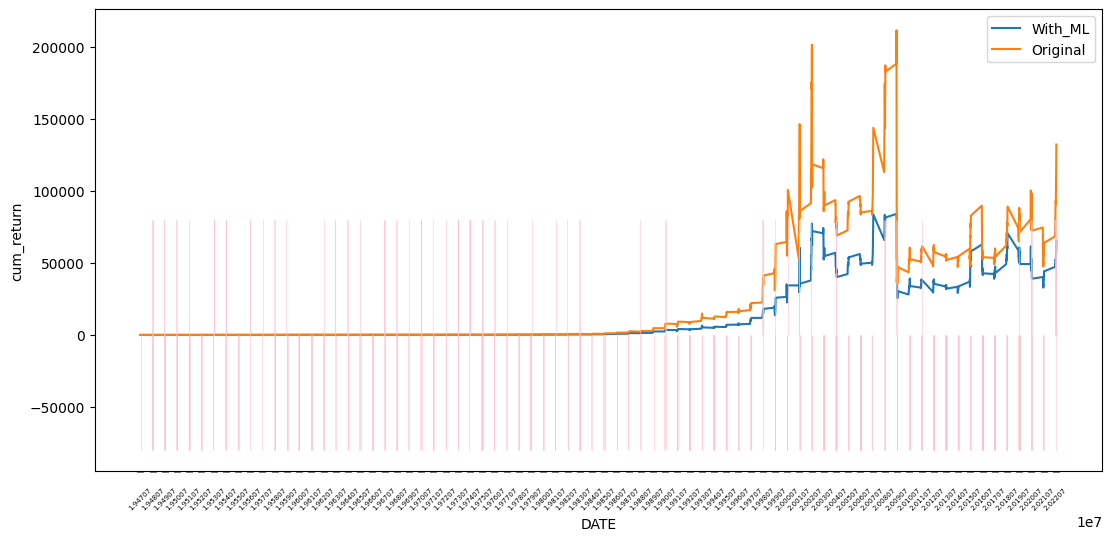

In [125]:
GBC_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                 WML,
                                                 'GBC_PRED_POS_WML',
                                                 GBC_A0_P1,
                                                 GBC_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.73455

최근 누적 수익률

  2022년-12월 -> 6038.22
  2022년-11월 -> 5645.90
  2022년-10월 -> 5481.00
  2022년-09월 -> 5177.64
  2022년-08월 -> 4881.06

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2009년-02월 -> 6927.08
  2등 : 2009년-01월 -> 6664.77
  3등 : 2008년-11월 -> 6623.11
  4등 : 2008년-12월 -> 6556.34
  5등 : 2008년-06월 -> 6515.81
  6등 : 2009년-03월 -> 6404.76
  7등 : 2008년-10월 -> 6348.84
  8등 : 2002년-09월 -> 6304.30
  9등 : 2008년-09월 -> 6086.53
  10등 : 2022년-12월 -> 6038.22



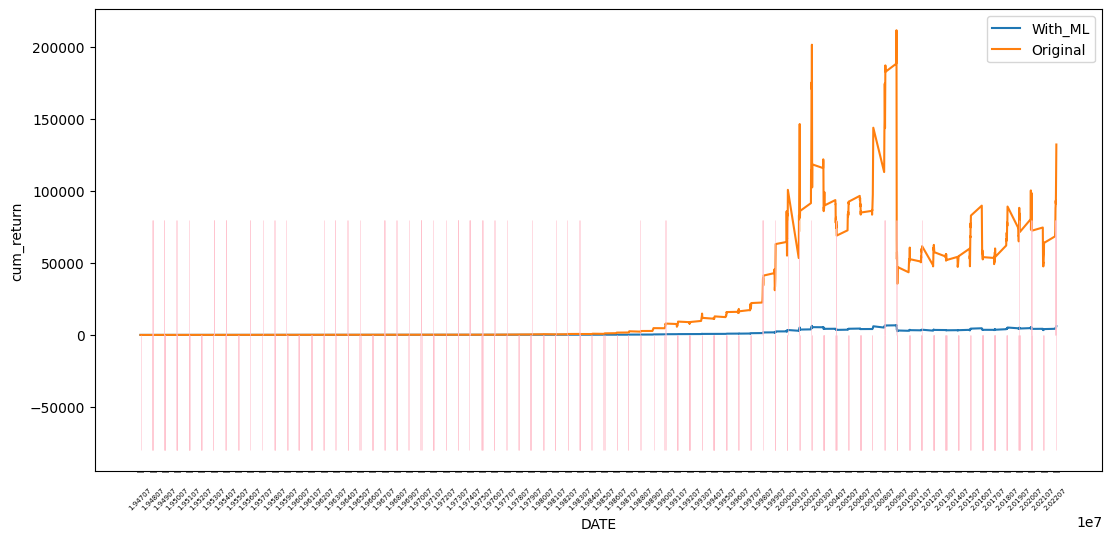

In [126]:
GBC_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_GBC_Result,
                                                  WML,
                                                  'GBC_PROB_POS_WML',
                                                  GBC_A0_P1,
                                                  GBC_A1_P0,
                                                  plot=True)

### XGB

In [127]:
XGB_Param = {}
XGB = XGBClassifier(**XGB_Param, random_state=42)

**************************************************

XGB Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   objective : binary:logistic
   use_label_encoder : None
   base_score : None
   booster : None
   callbacks : None
   colsample_bylevel : None
   colsample_bynode : None
   colsample_bytree : None
   early_stopping_rounds : None
   enable_categorical : False
   eval_metric : None
   feature_types : None
   gamma : None
   gpu_id : None
   grow_policy : None
   importance_type : None
   interaction_constraints : None
   learning_rate : None
   max_bin : None
   max_cat_threshold : None
   max_cat_to_onehot : None
   max_delta_step : None
   max_depth : None
   max_leaves : None
   min_child_weight : None
   missing : nan
   monotone_constraints : None
   n_estimators : 100
   n_jobs : None
   num_parallel_tree : None
   predictor : None
   random_state : 42
   reg_alpha : None
   reg_lambda : None
   sampling_method : None
   scale_pos_weight : None
   subsample : No

  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.38      0.28      0.32       316
         1.0       0.66      0.75      0.70       590

    accuracy                           0.58       906
   macro avg       0.52      0.52      0.51       906
weighted avg       0.56      0.58      0.57       906


accuracy : 0.5849889624724062

precision : 0.6606606606606606

recall : 0.7457627118644068

F1-Score : 0.7006369426751592



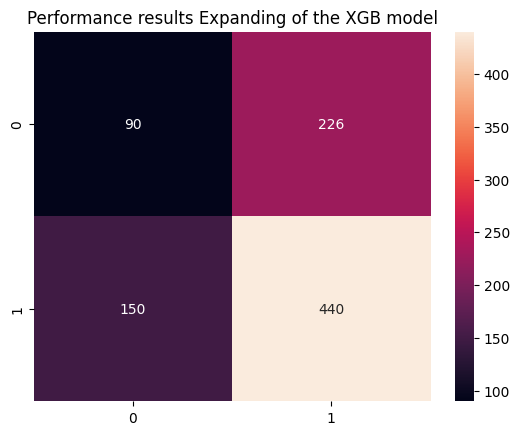


Feature Importance of the model



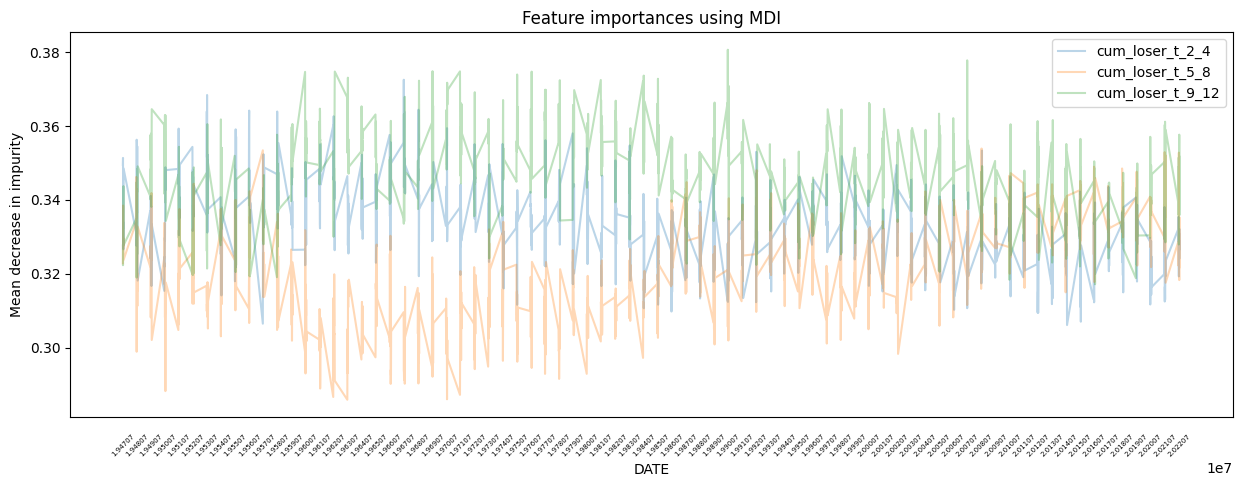

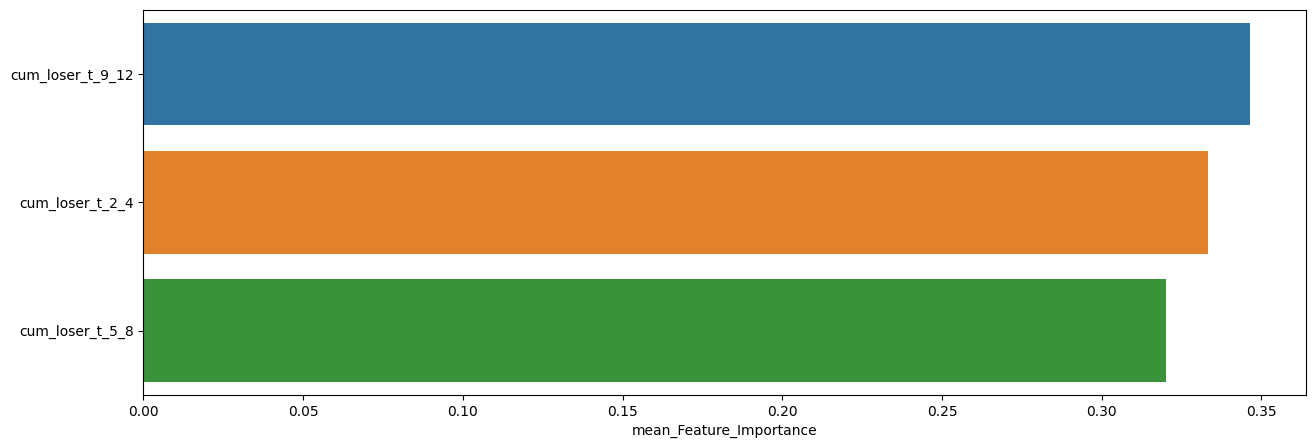

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.346578                0.380641   
cum_loser_t_2_4                  0.333159                0.372518   
cum_loser_t_5_8                  0.320263                0.353896   

                  min_Feature_Importance  
cum_loser_t_9_12                0.317162  
cum_loser_t_2_4                 0.306125  
cum_loser_t_5_8                 0.285904

In [128]:
Expanding_XGB_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                  window_size=240, # window size (훈련 데이터 셋 크기)
                                  method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                  model=XGB, # 사용할 모델
                                  model_name='XGB', # 사용한 모델 명
                                  plot=True, # 모델 성능 지표 시각화 여부
                                  plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.36      0.35      0.35        75
         1.0       0.68      0.70      0.69       151

    accuracy                           0.58       226
   macro avg       0.52      0.52      0.52       226
weighted avg       0.58      0.58      0.58       226


accuracy : 0.5796460176991151

precision : 0.6818181818181818

recall : 0.695364238410596

F1-Score : 0.6885245901639343



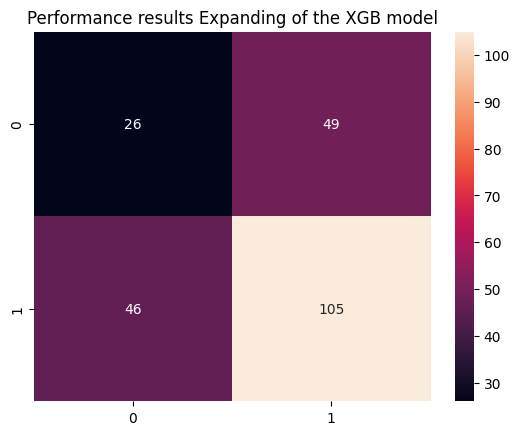


Feature Importance of the model



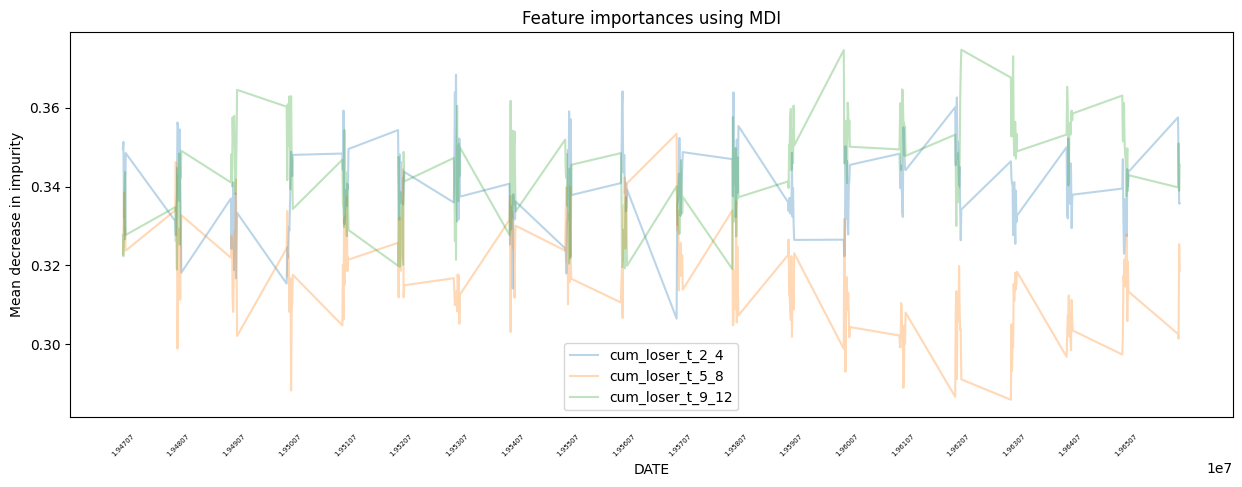

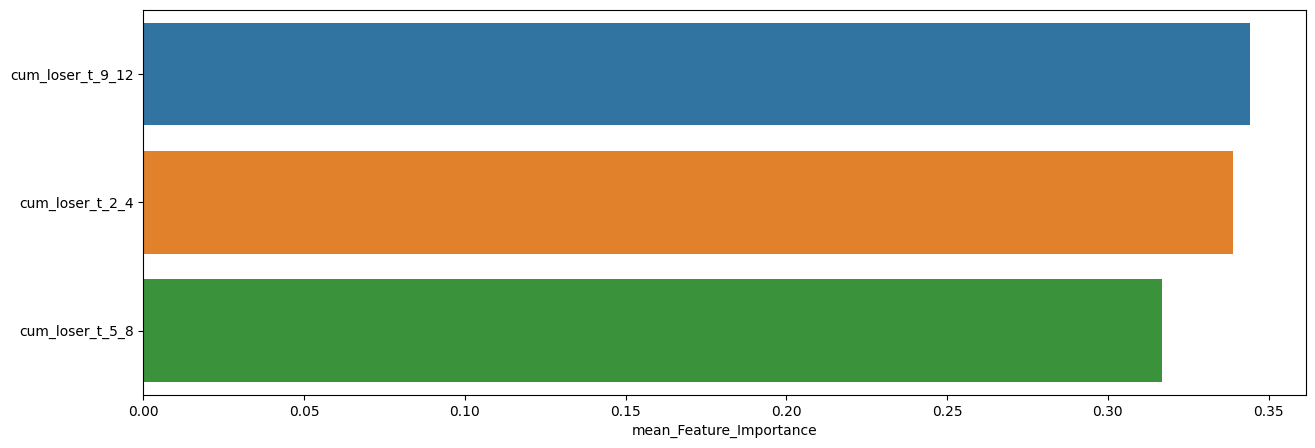

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.344355                0.374741   
cum_loser_t_2_4                  0.338925                0.368392   
cum_loser_t_5_8                  0.316720                0.353414   

                  min_Feature_Importance  
cum_loser_t_9_12                0.318975  
cum_loser_t_2_4                 0.306493  
cum_loser_t_5_8                 0.285904


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.37      0.31      0.34        75
         1.0       0.68      0.74      0.71       151

    accuracy                           0.60       226
   macro avg       0.53      0.52      0.52       226
weighted avg       0.58      0.60      0.59       226


accuracy : 0.5973451327433629

precision : 0.6829268292682927

recall : 0.7417218543046358

F1-Score : 0.7111111111111112



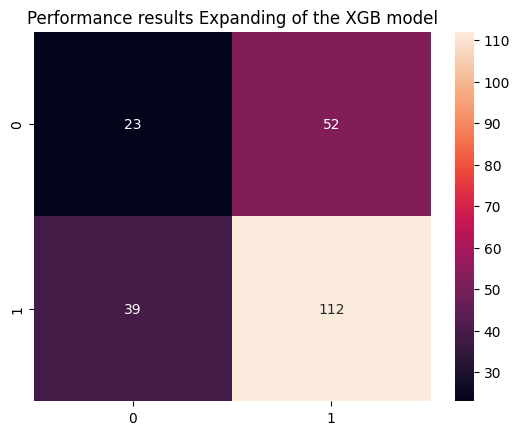


Feature Importance of the model



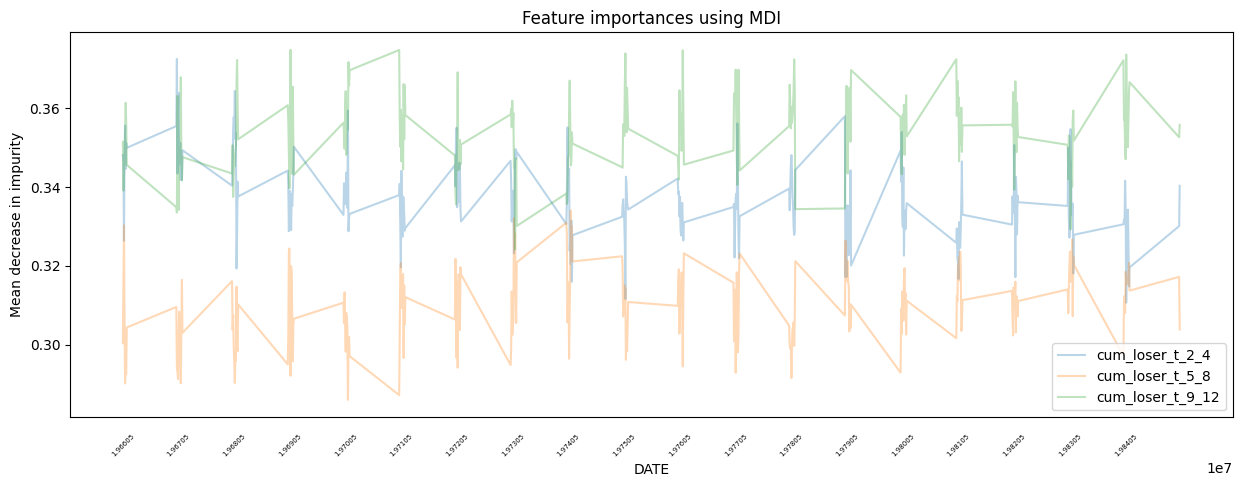

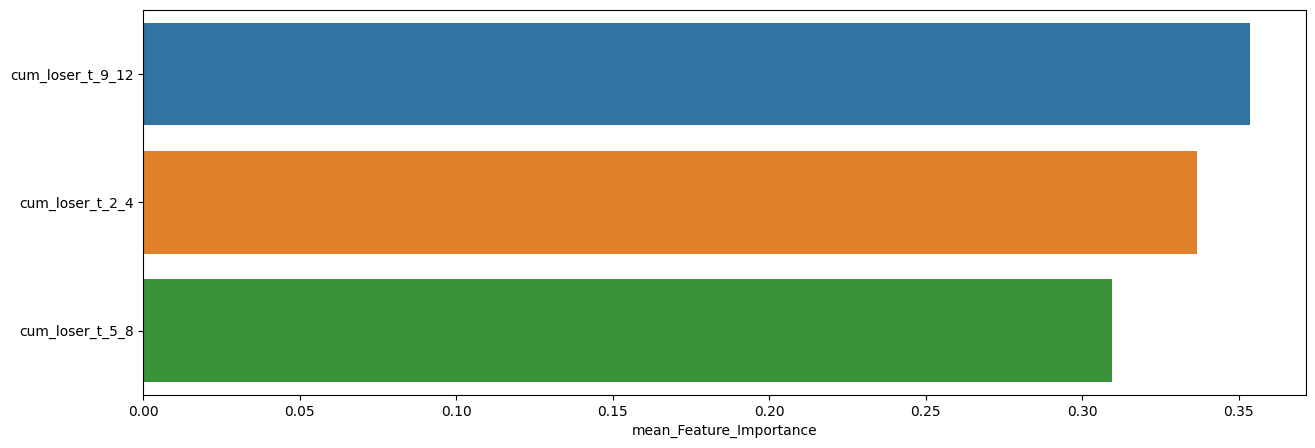

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.353817                0.374837   
cum_loser_t_2_4                  0.336580                0.372518   
cum_loser_t_5_8                  0.309604                0.334066   

                  min_Feature_Importance  
cum_loser_t_9_12                0.324176  
cum_loser_t_2_4                 0.310678  
cum_loser_t_5_8                 0.286036


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.45      0.31      0.37        70
         1.0       0.73      0.83      0.77       156

    accuracy                           0.67       226
   macro avg       0.59      0.57      0.57       226
weighted avg       0.64      0.67      0.65       226


accuracy : 0.668141592920354

precision : 0.7288135593220338

recall : 0.8269230769230769

F1-Score : 0.7747747747747747



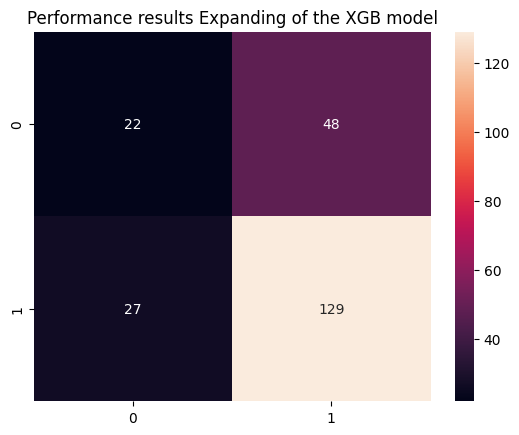


Feature Importance of the model



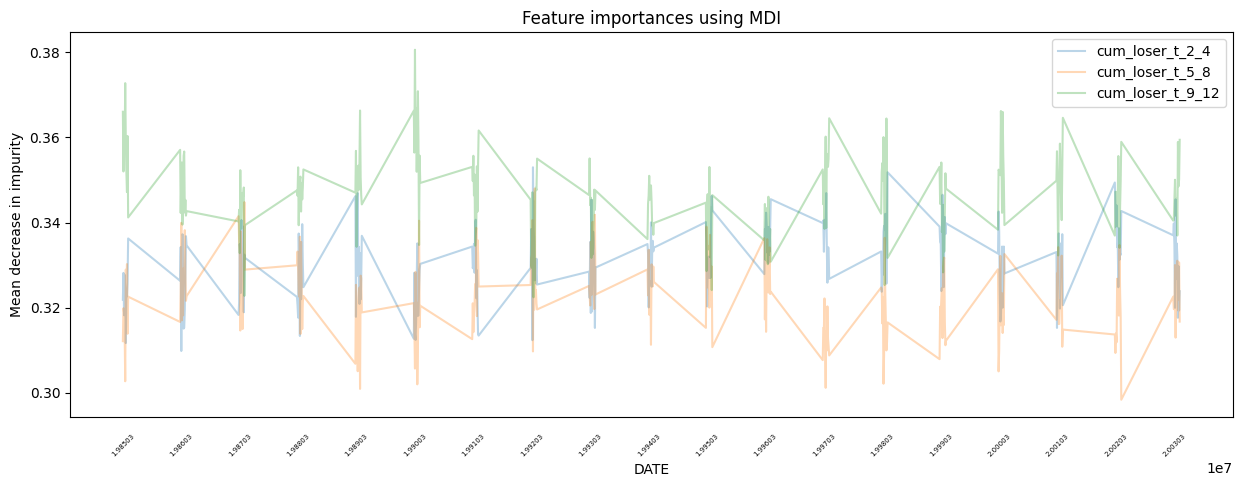

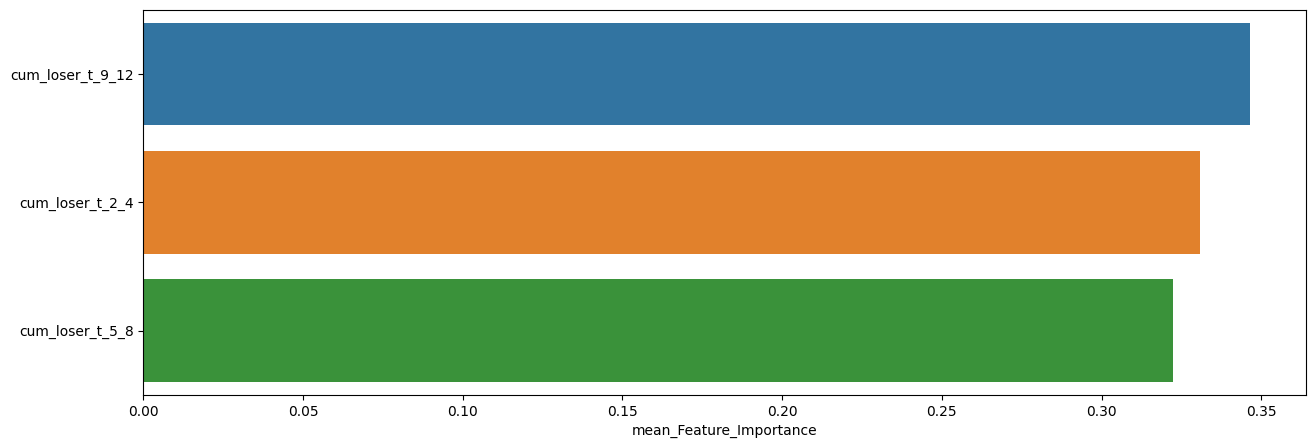

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.346629                0.380641   
cum_loser_t_2_4                  0.330857                0.352996   
cum_loser_t_5_8                  0.322514                0.348013   

                  min_Feature_Importance  
cum_loser_t_9_12                0.322408  
cum_loser_t_2_4                 0.309781  
cum_loser_t_5_8                 0.298315


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.20      0.25        96
         1.0       0.55      0.71      0.62       132

    accuracy                           0.50       228
   macro avg       0.44      0.46      0.43       228
weighted avg       0.46      0.50      0.46       228


accuracy : 0.4956140350877193

precision : 0.5497076023391813

recall : 0.7121212121212122

F1-Score : 0.6204620462046205



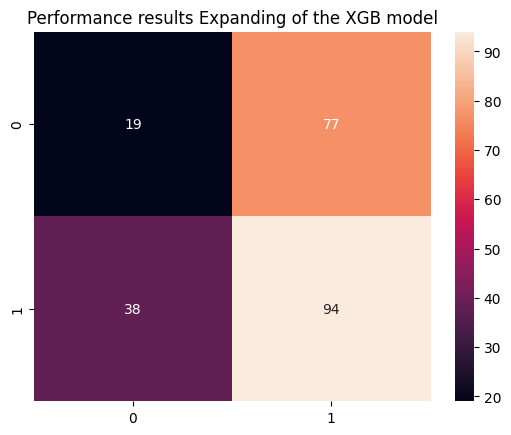


Feature Importance of the model



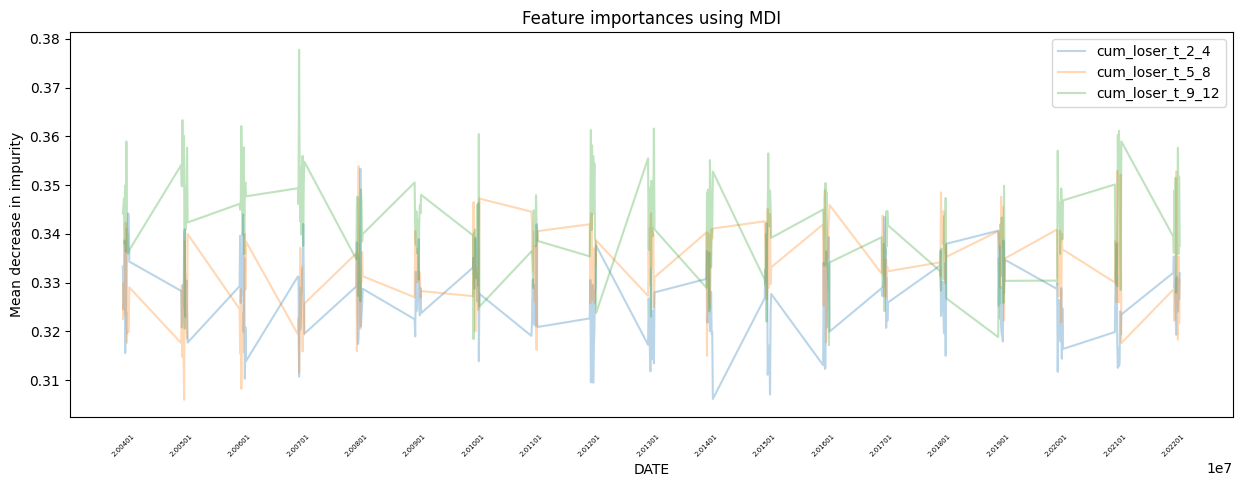

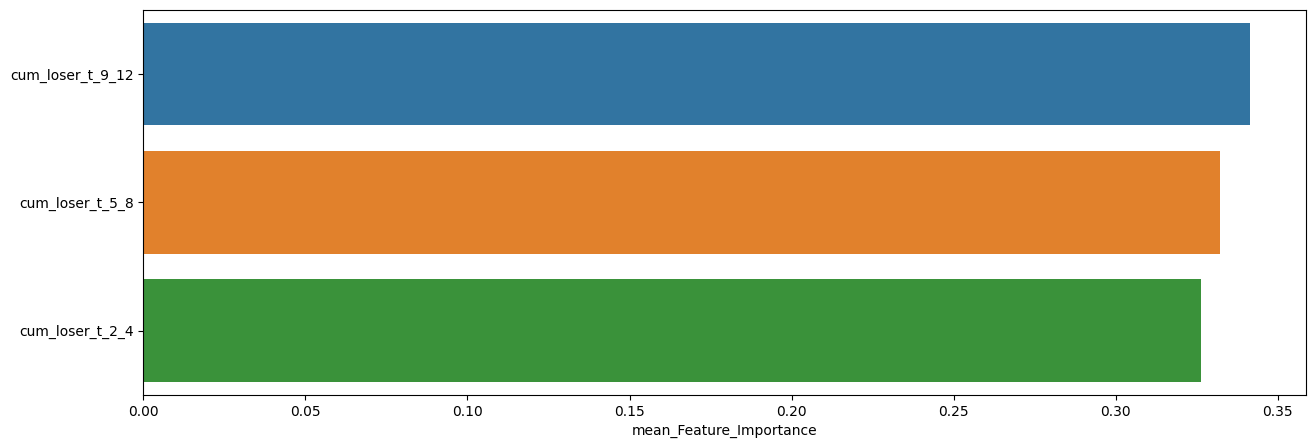

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12                 0.341555                0.377774   
cum_loser_t_5_8                  0.332110                0.353896   
cum_loser_t_2_4                  0.326335                0.353338   

                  min_Feature_Importance  
cum_loser_t_9_12                0.317162  
cum_loser_t_5_8                 0.305934  
cum_loser_t_2_4                 0.306125

In [129]:
slice_feature_importance(Expanding_XGB_Result, # 모델 추론 결과 데이터
                         4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                         'Expanding', # Rolling Windows Method
                         'XGB') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



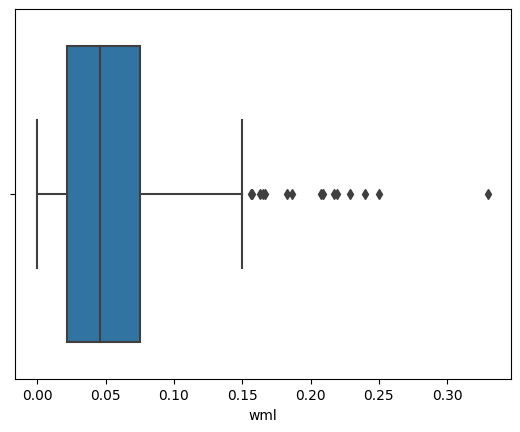

count      mean       std       min       25%       50%       75%  \
wml  440.0  0.054277  0.045184  0.000007  0.021997  0.045567  0.075441   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



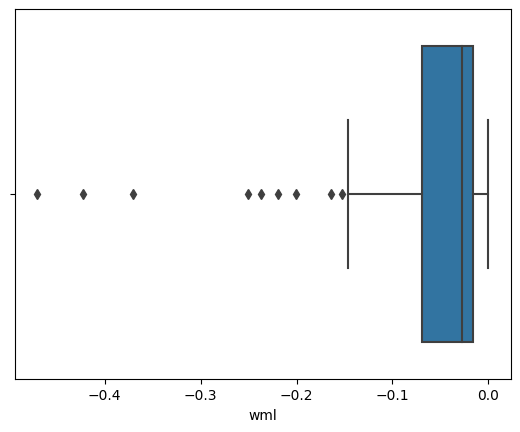

count      mean       std       min      25%       50%       75%  \
wml   90.0 -0.062836  0.086431 -0.469903 -0.06897 -0.027349 -0.015928   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



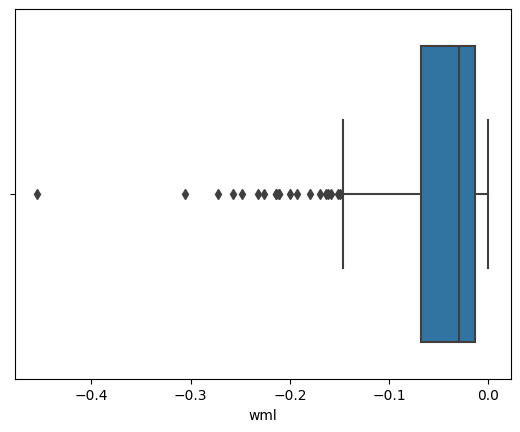

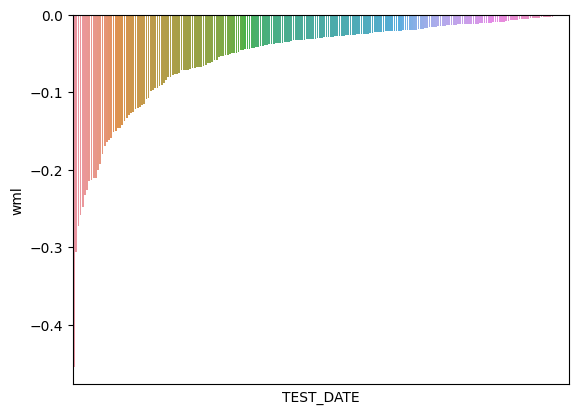

count      mean      std       min      25%     50%      75%       max
wml  226.0 -0.053713  0.06423 -0.454349 -0.06784 -0.0296 -0.01382 -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



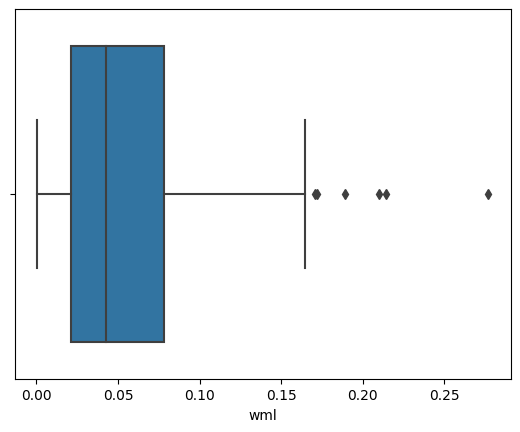

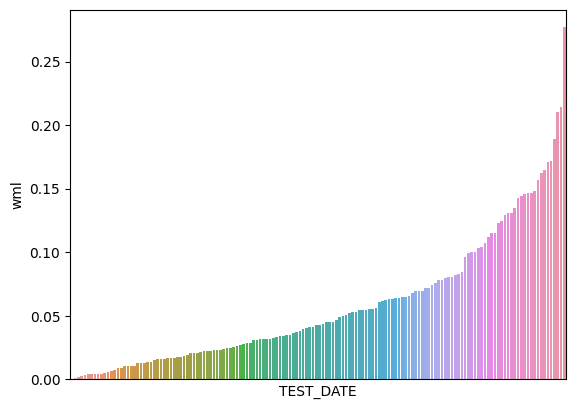

count      mean       std       min       25%       50%       75%  \
wml  150.0  0.058105  0.051342  0.000651  0.020974  0.042982  0.078474   

          max  
wml  0.276912

In [130]:
XGB_A0_P1, XGB_A1_P0 = What_Pred(Expanding_XGB_Result, WML, 'XGB')

Sharpe Ratio : 0.65545

최근 누적 수익률

  2022년-12월 -> 18008.55
  2022년-11월 -> 16225.29
  2022년-10월 -> 15433.63
  2022년-09월 -> 15433.63
  2022년-08월 -> 15433.63

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2007년-12월 -> 48411.75
  2등 : 2007년-11월 -> 44946.43
  3등 : 2002년-09월 -> 44871.31
  4등 : 2002년-12월 -> 41859.31
  5등 : 2007년-10월 -> 41299.12
  6등 : 2003년-02월 -> 40943.04
  7등 : 2003년-01월 -> 40943.04
  8등 : 2008년-03월 -> 40685.25
  9등 : 2008년-04월 -> 40685.25
  10등 : 2008년-05월 -> 40685.25



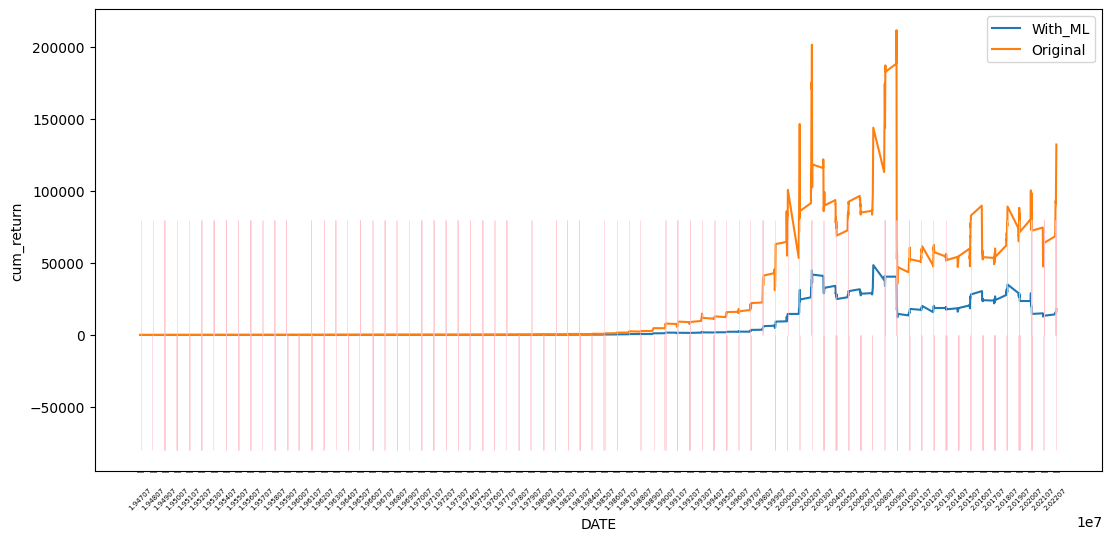

In [131]:
XGB_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PRED_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

Sharpe Ratio : 0.68602

최근 누적 수익률

  2022년-12월 -> 10267.42
  2022년-11월 -> 9298.03
  2022년-10월 -> 8854.78
  2022년-09월 -> 8344.39
  2022년-08월 -> 7980.57

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2008년-06월 -> 13915.98
  2등 : 2007년-12월 -> 13865.28
  3등 : 2009년-02월 -> 13615.53
  4등 : 2009년-01월 -> 13559.98
  5등 : 2008년-11월 -> 13454.35
  6등 : 2008년-12월 -> 13432.92
  7등 : 2008년-10월 -> 13365.75
  8등 : 2007년-11월 -> 13113.15
  9등 : 2008년-05월 -> 12952.79
  10등 : 2008년-04월 -> 12862.01



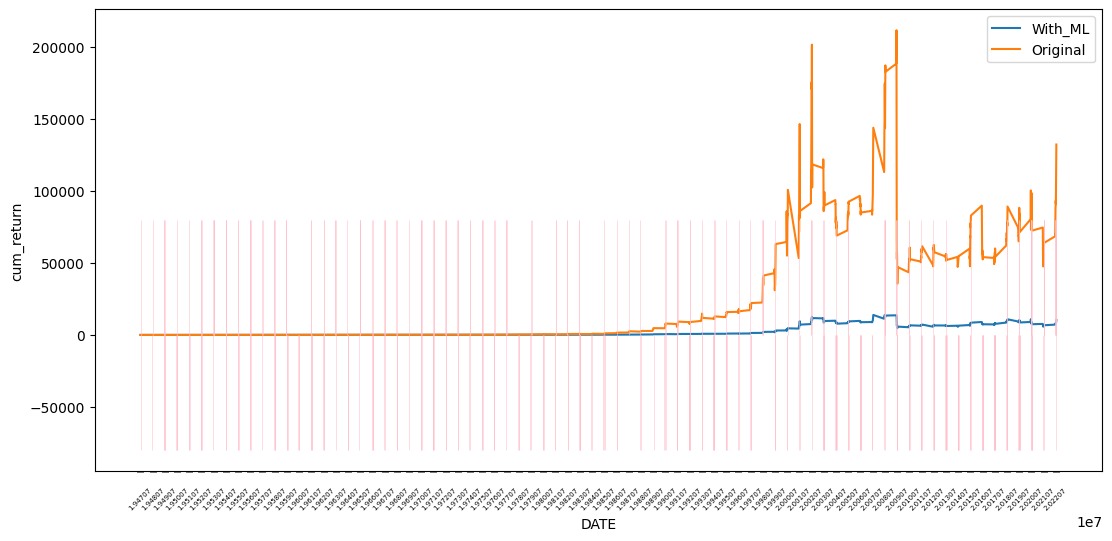

In [132]:
XGB_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_XGB_Result,
                                                 WML,
                                                 'XGB_PROB_POS_WML',
                                                 XGB_A0_P1,
                                                 XGB_A1_P0,
                                                 plot=True)

### LGBM

In [133]:
LGBM_param = {}
LGBM = LGBMClassifier(**LGBM_param, random_state=42)

**************************************************

LGBM Model의 Rolling Expanding Window를 실행합니다

설정된 Model의 하이퍼파리미터 : 

   boosting_type : gbdt
   class_weight : None
   colsample_bytree : 1.0
   importance_type : split
   learning_rate : 0.1
   max_depth : -1
   min_child_samples : 20
   min_child_weight : 0.001
   min_split_gain : 0.0
   n_estimators : 100
   n_jobs : -1
   num_leaves : 31
   objective : None
   random_state : 42
   reg_alpha : 0.0
   reg_lambda : 0.0
   silent : warn
   subsample : 1.0
   subsample_for_bin : 200000
   subsample_freq : 0

**************************************************


  0%|          | 0/906 [00:00<?, ?it/s]


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.34      0.24      0.28       316
         1.0       0.65      0.75      0.69       590

    accuracy                           0.57       906
   macro avg       0.49      0.49      0.49       906
weighted avg       0.54      0.57      0.55       906


accuracy : 0.5717439293598234

precision : 0.6480938416422287

recall : 0.7491525423728813

F1-Score : 0.6949685534591196



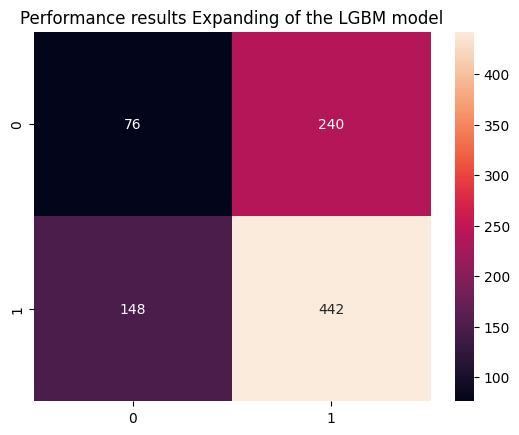


Feature Importance of the model



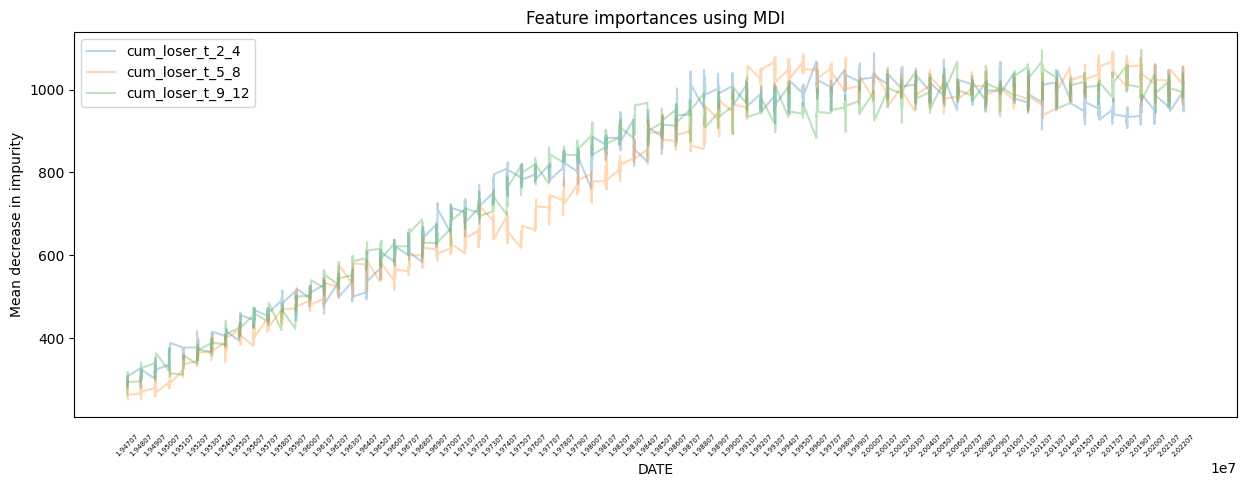

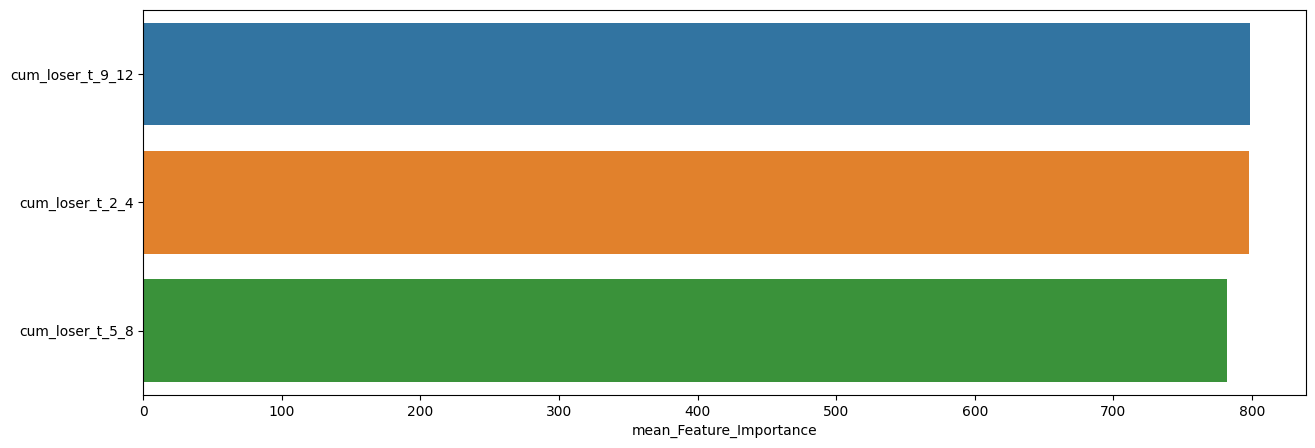

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12               798.976821                    1096   
cum_loser_t_2_4                797.701987                    1087   
cum_loser_t_5_8                781.953642                    1091   

                  min_Feature_Importance  
cum_loser_t_9_12                     265  
cum_loser_t_2_4                      281  
cum_loser_t_5_8                      252

In [134]:
Expanding_LGBM_Result = Roling_Windows(data=dynmom, # 사용할 데이터
                                    window_size=240, # window size (훈련 데이터 셋 크기)
                                    method='Expanding', # Rolling Winodw Method (Fixed or Expanding)
                                    model=LGBM, # 사용할 모델
                                    model_name='LGBM', # 사용한 모델 명
                                    plot=True, # 모델 성능 지표 시각화 여부
                                    plot_feature=True) # 모델의 변수 중요도 시각화 여부


**************************************************

DATE : 19470731 ~ 19660429

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.35      0.28      0.31        75
         1.0       0.67      0.74      0.71       151

    accuracy                           0.59       226
   macro avg       0.51      0.51      0.51       226
weighted avg       0.57      0.59      0.58       226


accuracy : 0.588495575221239

precision : 0.6746987951807228

recall : 0.7417218543046358

F1-Score : 0.7066246056782335



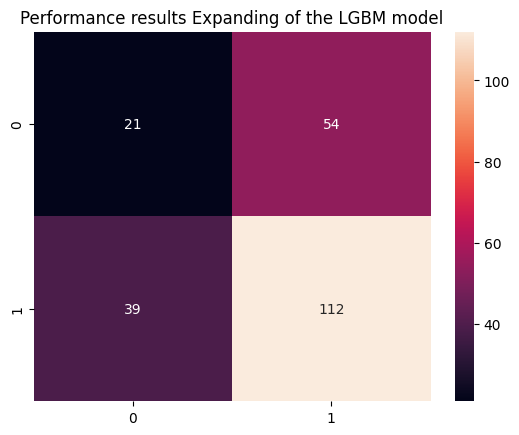


Feature Importance of the model



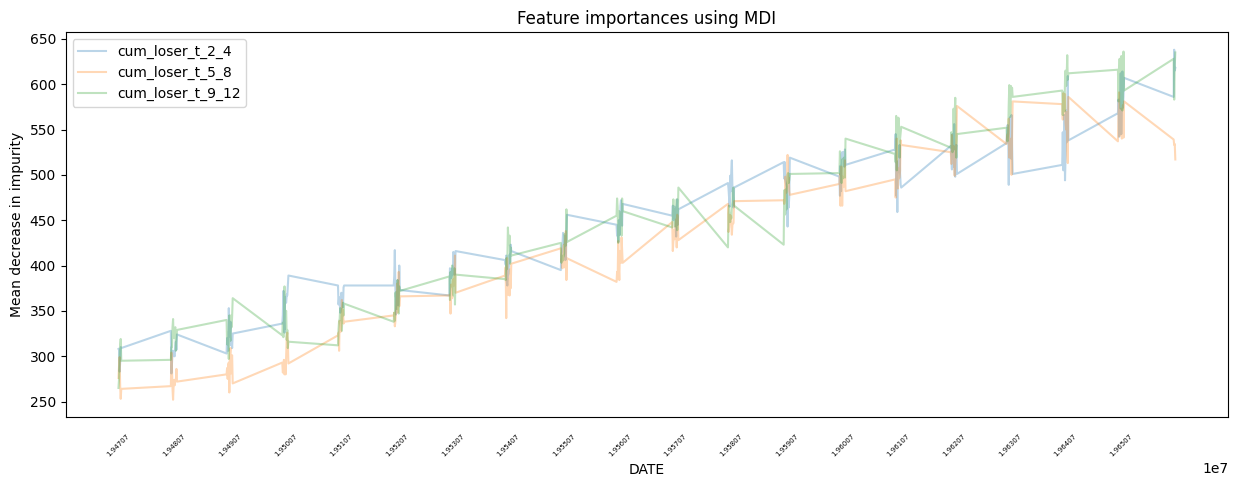

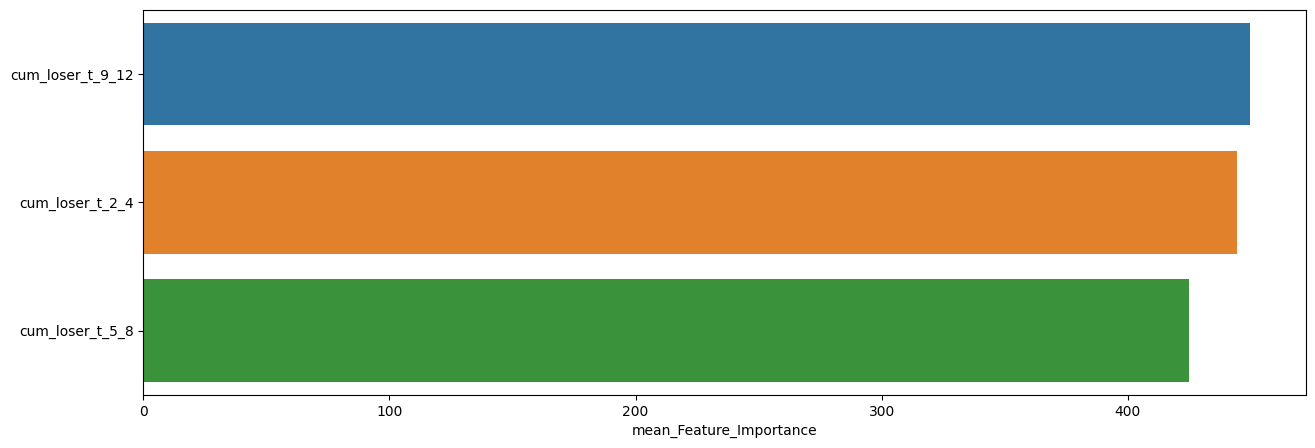

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12               449.805310                     636   
cum_loser_t_2_4                444.367257                     638   
cum_loser_t_5_8                424.694690                     591   

                  min_Feature_Importance  
cum_loser_t_9_12                     265  
cum_loser_t_2_4                      281  
cum_loser_t_5_8                      252


**************************************************

DATE : 19660531 ~ 19850228

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.27      0.23      0.25        75
         1.0       0.65      0.70      0.67       151

    accuracy                           0.54       226
   macro avg       0.46      0.46      0.46       226
weighted avg       0.52      0.54      0.53       226


accuracy : 0.5442477876106194

precision : 0.6463414634146342

recall : 0.7019867549668874

F1-Score : 0.673015873015873



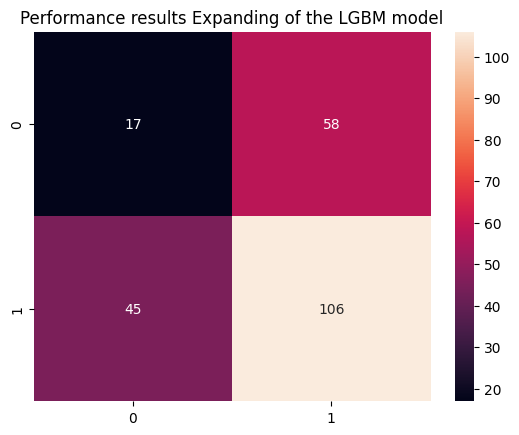


Feature Importance of the model



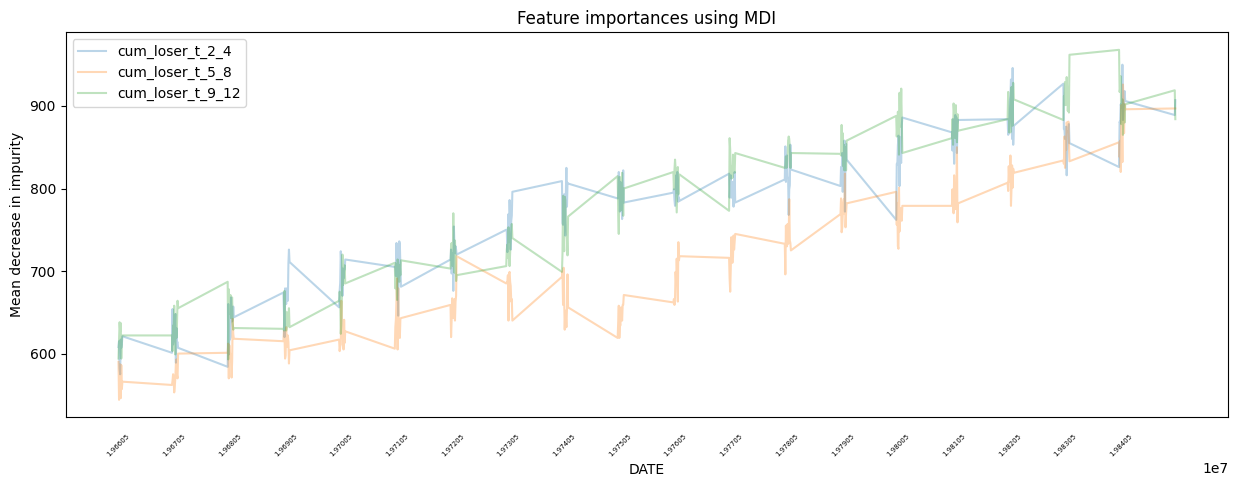

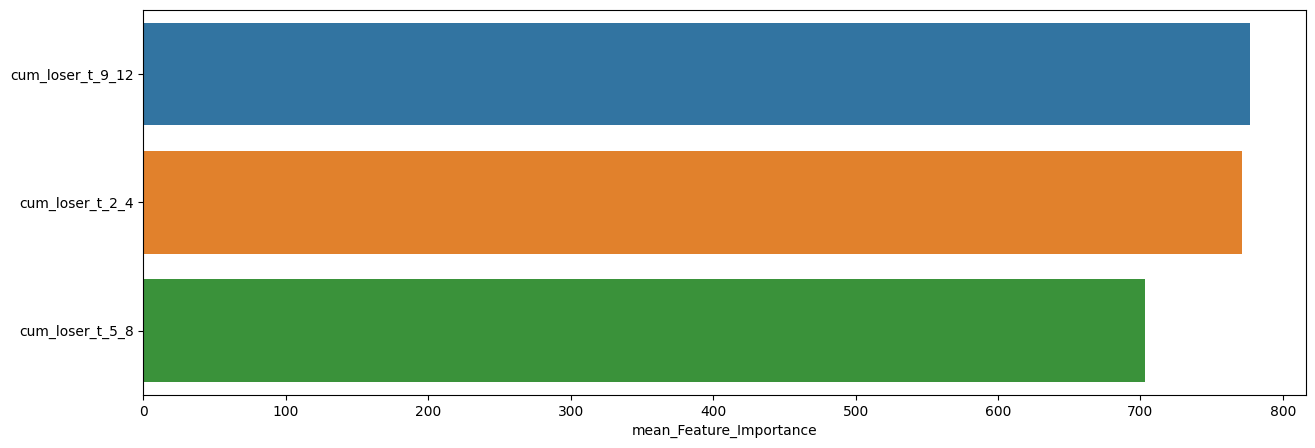

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_9_12               777.230088                     968   
cum_loser_t_2_4                771.216814                     950   
cum_loser_t_5_8                703.088496                     926   

                  min_Feature_Importance  
cum_loser_t_9_12                     593  
cum_loser_t_2_4                      575  
cum_loser_t_5_8                      544


**************************************************

DATE : 19850329 ~ 20031231

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.42      0.29      0.34        70
         1.0       0.72      0.82      0.77       156

    accuracy                           0.65       226
   macro avg       0.57      0.55      0.55       226
weighted avg       0.63      0.65      0.63       226


accuracy : 0.6548672566371682

precision : 0.7191011235955056

recall : 0.8205128205128205

F1-Score : 0.7664670658682635



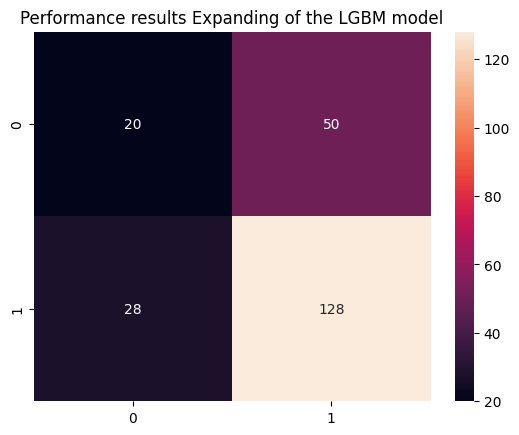


Feature Importance of the model



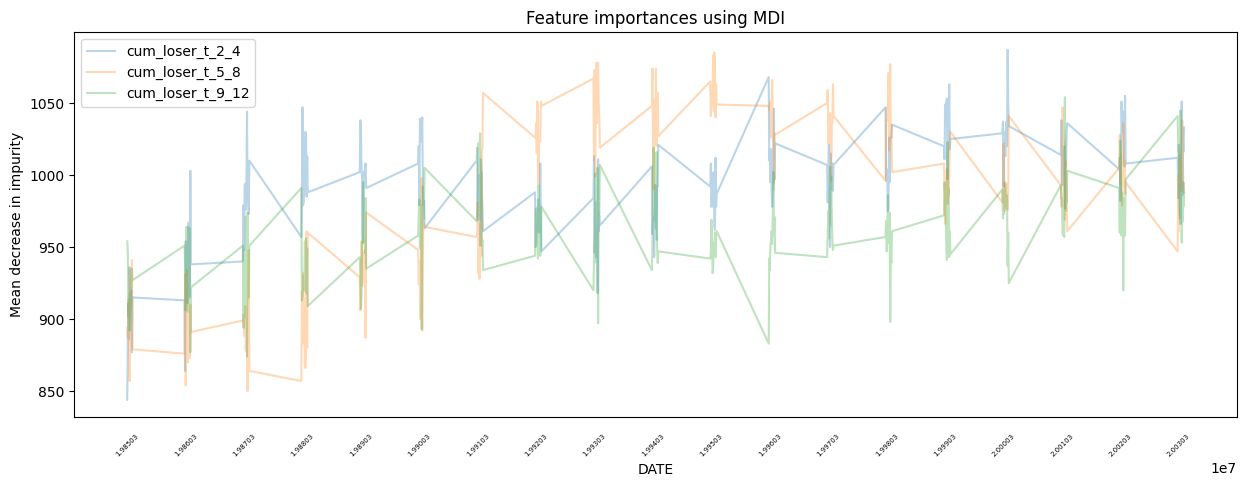

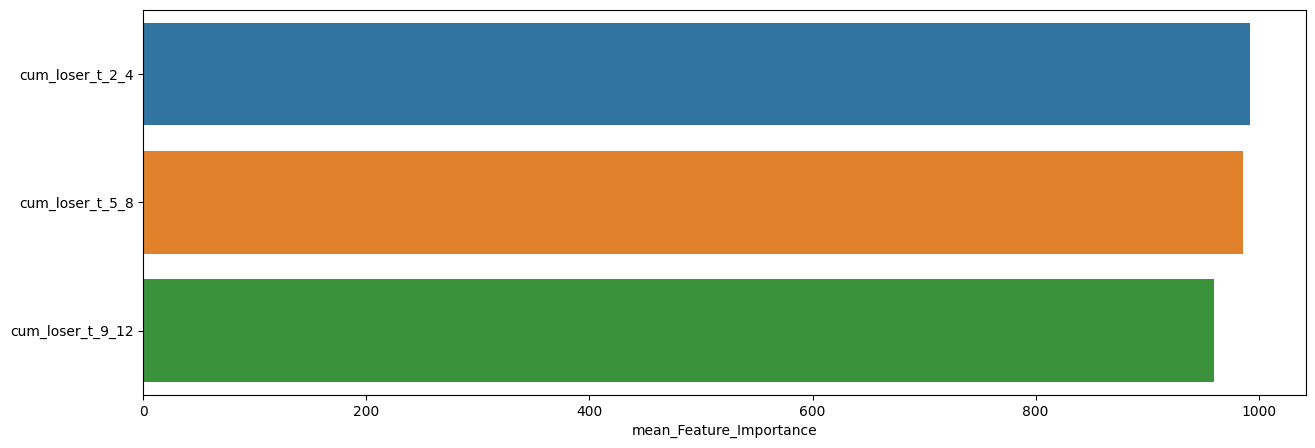

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_2_4                992.690265                    1087   
cum_loser_t_5_8                985.584071                    1085   
cum_loser_t_9_12               960.353982                    1054   

                  min_Feature_Importance  
cum_loser_t_2_4                      844  
cum_loser_t_5_8                      850  
cum_loser_t_9_12                     874


**************************************************

DATE : 20040130 ~ 20221230

**************************************************


Performance results of the model

              precision    recall  f1-score   support

         0.0       0.33      0.19      0.24        96
         1.0       0.55      0.73      0.63       132

    accuracy                           0.50       228
   macro avg       0.44      0.46      0.43       228
weighted avg       0.46      0.50      0.46       228


accuracy : 0.5

precision : 0.5517241379310345

recall : 0.7272727272727273

F1-Score : 0.6274509803921569



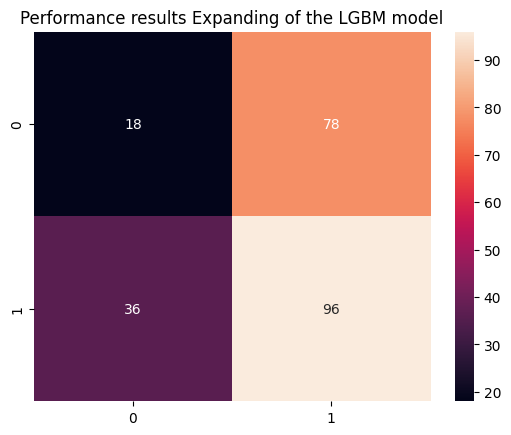


Feature Importance of the model



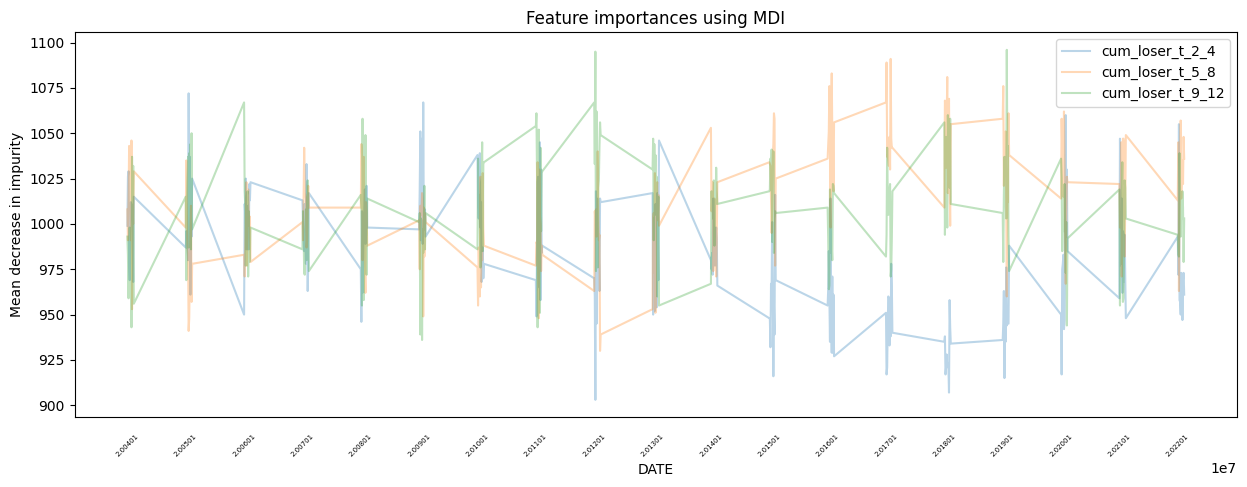

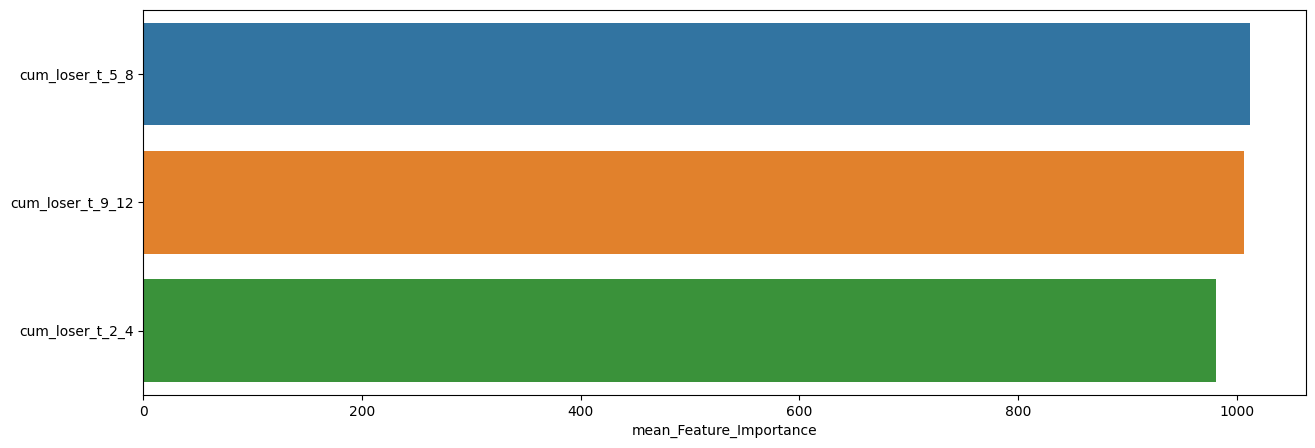

mean_Feature_Importance  max_Feature_Importance  \
cum_loser_t_5_8               1012.407895                    1091   
cum_loser_t_9_12              1006.679825                    1096   
cum_loser_t_2_4                980.912281                    1072   

                  min_Feature_Importance  
cum_loser_t_5_8                      930  
cum_loser_t_9_12                     936  
cum_loser_t_2_4                      903

In [135]:
slice_feature_importance(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                        4, # 나눌 구간 수 (If None : 특정 구간 입력) 
                        'Expanding', # Rolling Windows Method
                        'LGBM') # 모델 명


IQR 기준 WML 이상치 (Maximum 미만) 개수

Number of Outlier by IQR (Maximum) : 16
Maximum by IQR : 0.1670798809375
Max Outlier : 0.3301628157
Min Outlier : 0.1709176029

ACTUAL = PRED = 1



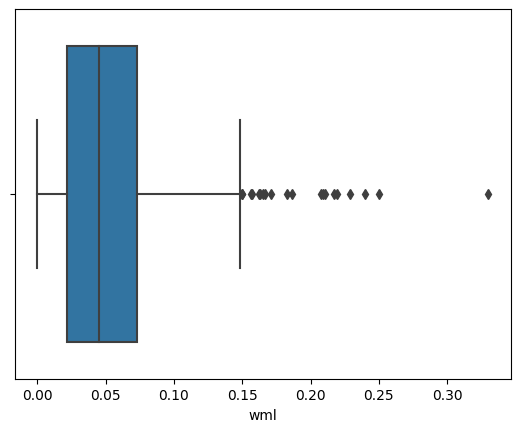

count      mean       std       min       25%       50%       75%  \
wml  442.0  0.054273  0.046062  0.000007  0.022018  0.045238  0.072607   

          max  
wml  0.330163


--------------------------------------------------------------------------------


IQR 기준 WML 이상치 (Minimum 미만) 개수

Number of Outlier by IQR (Minimum) : 40
Minimun by IQR : -0.1267517369625
Max Outlier : -0.127277386
Min Outlier : -0.469903035

ACTUAL = PRED = 0



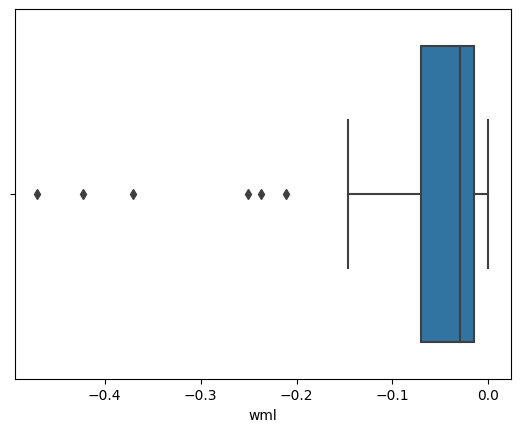

count      mean       std       min       25%       50%       75%  \
wml   76.0 -0.064691  0.090311 -0.469903 -0.070461 -0.029393 -0.015611   

          max  
wml -0.000183


--------------------------------------------------------------------------------


ACTUAL = 0 &  PRED = 1



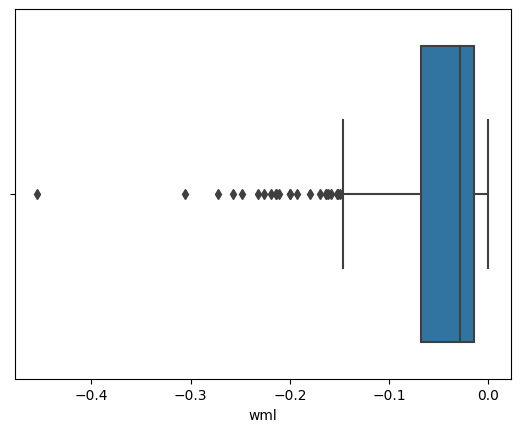

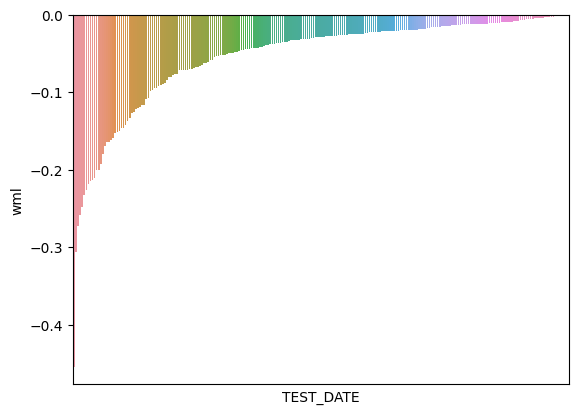

count      mean       std       min       25%       50%       75%  \
wml  240.0 -0.053658  0.064025 -0.454349 -0.067829 -0.028415 -0.014437   

          max  
wml -0.000132


--------------------------------------------------------------------------------


ACTUAL = 1 &  PRED = 0



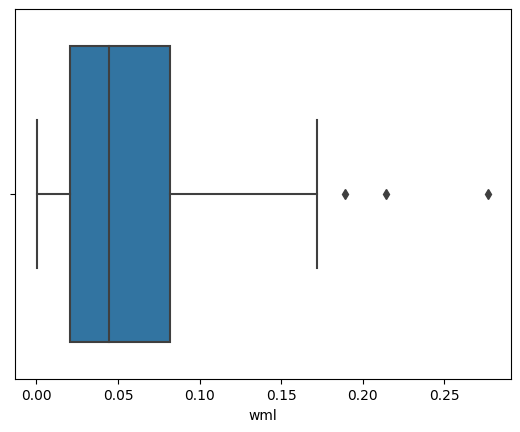

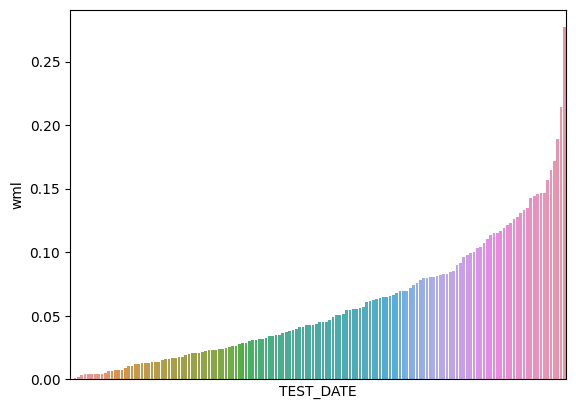

count      mean       std       min       25%       50%       75%  \
wml  148.0  0.058167  0.049026  0.000651  0.020619  0.044322  0.082131   

          max  
wml  0.276912

In [136]:
LGBM_A0_P1, LGBM_A1_P0 = What_Pred(Expanding_LGBM_Result,
                                   WML,
                                   'LGBM')

Sharpe Ratio : 0.66338

최근 누적 수익률

  2022년-12월 -> 8925.44
  2022년-11월 -> 8041.57
  2022년-10월 -> 7649.18
  2022년-09월 -> 6773.14
  2022년-08월 -> 6773.14

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2007년-12월 -> 17151.64
  2등 : 2007년-11월 -> 15923.88
  3등 : 2002년-09월 -> 15560.36
  4등 : 2003년-02월 -> 14945.61
  5등 : 2003년-03월 -> 14733.32
  6등 : 2008년-05월 -> 14662.36
  7등 : 2008년-06월 -> 14662.36
  8등 : 2008년-04월 -> 14662.36
  9등 : 2007년-10월 -> 14631.64
  10등 : 2002년-12월 -> 14515.82



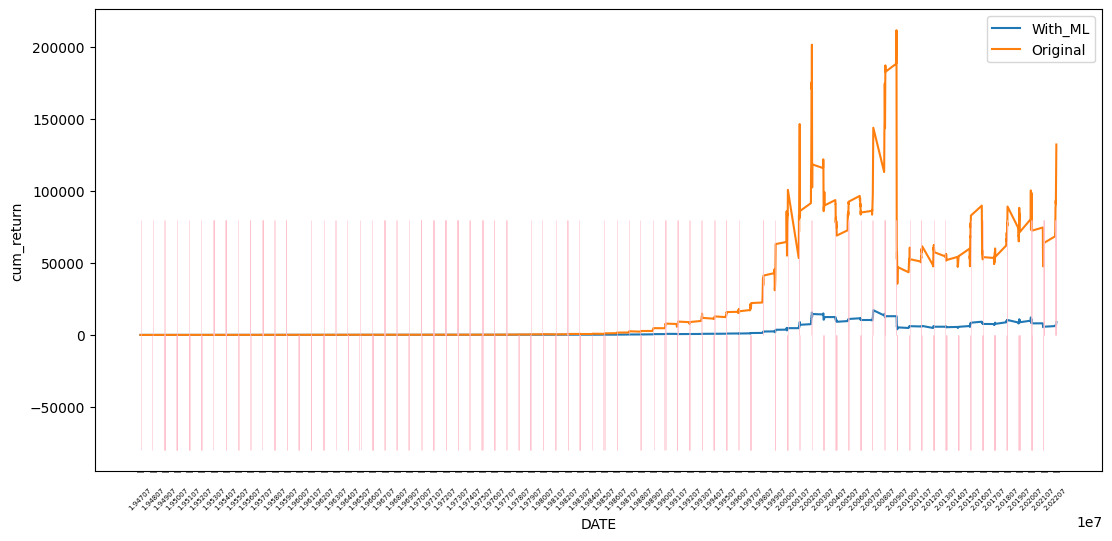

In [137]:
LGBM_E_CUM_RETURN_static = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PRED_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

Sharpe Ratio : 0.71470

최근 누적 수익률

  2022년-12월 -> 7211.10
  2022년-11월 -> 6610.76
  2022년-10월 -> 6306.35
  2022년-09월 -> 5726.10
  2022년-08월 -> 5460.98

누적 수익률 가장 높았던 순간 Top 10

  1등 : 2002년-09월 -> 7372.43
  2등 : 2007년-12월 -> 7354.31
  3등 : 2022년-12월 -> 7211.10
  4등 : 2009년-02월 -> 7042.54
  5등 : 2007년-11월 -> 7008.94
  6등 : 2009년-01월 -> 7006.25
  7등 : 2020년-03월 -> 6999.48
  8등 : 2008년-11월 -> 6951.79
  9등 : 2008년-06월 -> 6934.00
  10등 : 2008년-12월 -> 6927.50



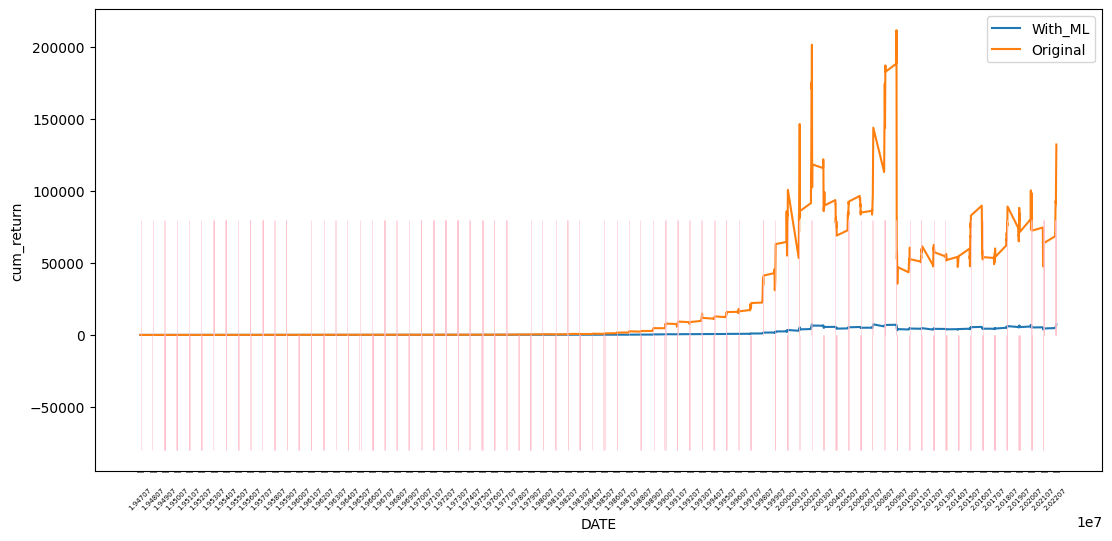

In [138]:
LGBM_E_CUM_RETURN_dynamic = cumm_return_by_dynamic(Expanding_LGBM_Result, # 모델 추론 결과 데이터
                                                   WML, # 원본 데이터의 'wml' 데이터
                                                   'LGBM_PROB_POS_WML', # 모델 추론 결과 칼럼
                                                   LGBM_A0_P1,
                                                   LGBM_A1_P0,
                                                   plot=True) # 시각화 여부

# Performance

## F1 - Score

RDF의 F1-Score : 0.7061503416856492
GBC의 F1-Score : 0.7228177641653906
XGB의 F1-Score : 0.680952380952381
LGBM의 F1-Score : 0.684375



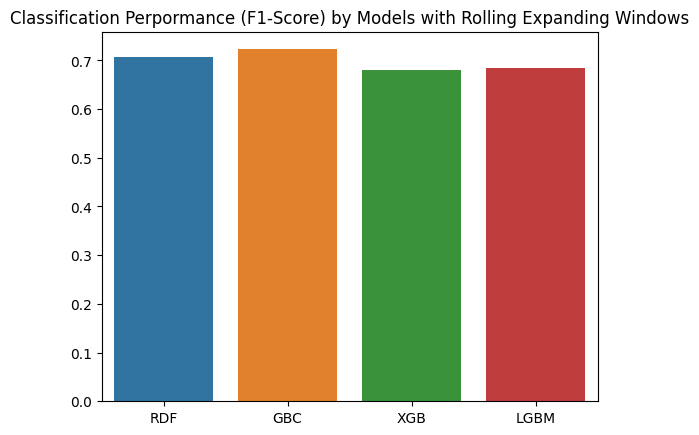

In [139]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

RDF의 F1-Score : 0.7119155354449472
GBC의 F1-Score : 0.7377647918188459
XGB의 F1-Score : 0.7006369426751592
LGBM의 F1-Score : 0.6949685534591196



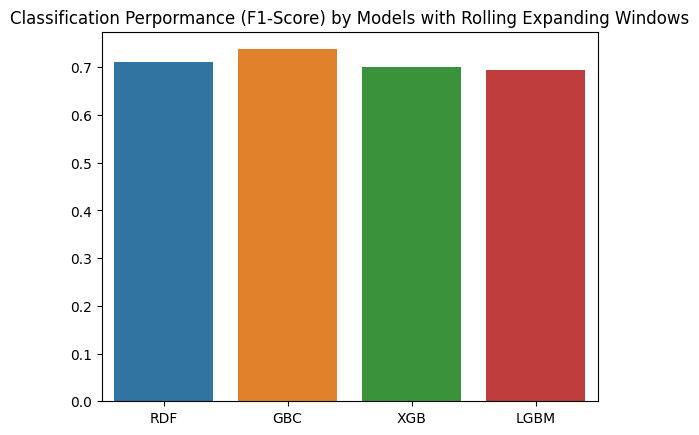

In [140]:
list_model = ['RDF', 'GBC', 'XGB', 'LGBM']
list_result = [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result]

list_f1 = []

for model, data in zip(list_model, list_result):
  F1 = f1_score(data['Actual_POS_WML'], data[f'{model}_PRED_POS_WML'])
  print(f'{model}의 F1-Score : {F1}')
  list_f1.append(F1)
print()

sns.barplot(x=list_model, y=list_f1)
plt.title('Classification Perpormance (F1-Score) by Models with Rolling Expanding Windows')
plt.show()

## Cum Return & Sharpe Ratio

In [141]:
R_WML = WML.loc[19470731:].copy()
CUM_WML = WML.loc[19470731:].copy()

CUM_WML['wml'] = (1 + CUM_WML.wml).cumprod() - 1
CUM_WML.columns = ['cum_return'] 

last_r = CUM_WML['cum_return'].values[-1]
w_S = (R_WML['wml'].mean()/R_WML['wml'].std()) * math.sqrt(12)

In [142]:
def compare_sharpe_ratio(list_model, list_result, list_cum, dynamic=True):

  print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format('ORG', w_S, last_r))

  for model, data, cum in zip(list_model, list_result, list_cum):
    data['wml'] = WML.loc[19470731:]['wml']

    if dynamic == True:

      data[f'{model}_PROB_WML'] = data['wml'] * data[f'{model}_PROB_POS_WML']
      S = (data[f'{model}_PROB_WML'].mean()/data[f'{model}_PROB_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))

      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

    else:

      data[f'{model}_PRED_WML'] = data['wml'] * data[f'{model}_PRED_POS_WML']
      S = (data[f'{model}_PRED_WML'].mean()/data[f'{model}_PRED_WML'].std())*math.sqrt(12)

      C = list(cum['cum_return'])[-1]
      print('{} Sharpe Ratio : {:0.4f}  최종 누적 수익률 : {}'.format(model, S, C))
      
      sns.lineplot(data=cum, x=data.index, y='cum_return', alpha=0.7, label=model)

  sns.lineplot(data=CUM_WML, x=CUM_WML.index, y='cum_return', alpha=0.7, label='ORG')
  plt.title('Sharpe Ratio & Cum Return by Model')
  plt.xticks([CUM_WML.index[i] for i in range(0,len(CUM_WML.index), 12)])
  plt.tick_params(axis='x',
                    direction='out',
                    labelrotation=45,
                    length=1,
                    pad=10,
                    labelsize=1,
                    width=0.1)
  plt.show()

### Rolling Fixed Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6301  최종 누적 수익률 : 5853.093694697353
GBC Sharpe Ratio : 0.8088  최종 누적 수익률 : 69657.71220192048
XGB Sharpe Ratio : 0.5498  최종 누적 수익률 : 1517.3978168330327
LGBM Sharpe Ratio : 0.5434  최종 누적 수익률 : 1526.2481048797592


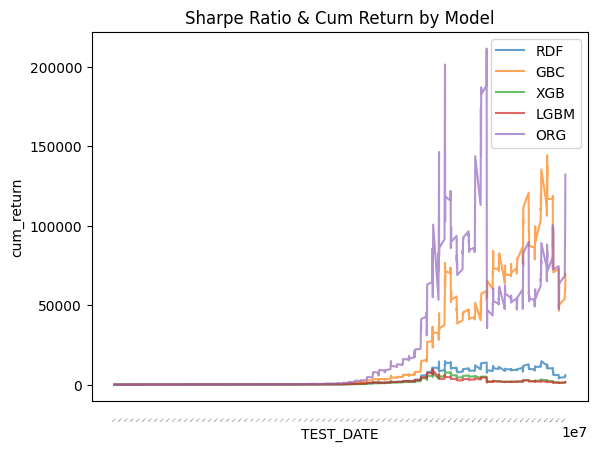

In [143]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_static, GBC_F_CUM_RETURN_static, XGB_F_CUM_RETURN_static, LGBM_F_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.7452  최종 누적 수익률 : 5427.756074079065
GBC Sharpe Ratio : 0.7904  최종 누적 수익률 : 9170.214566320537
XGB Sharpe Ratio : 0.6550  최종 누적 수익률 : 4012.997791490643
LGBM Sharpe Ratio : 0.7037  최종 누적 수익률 : 4451.668268537056


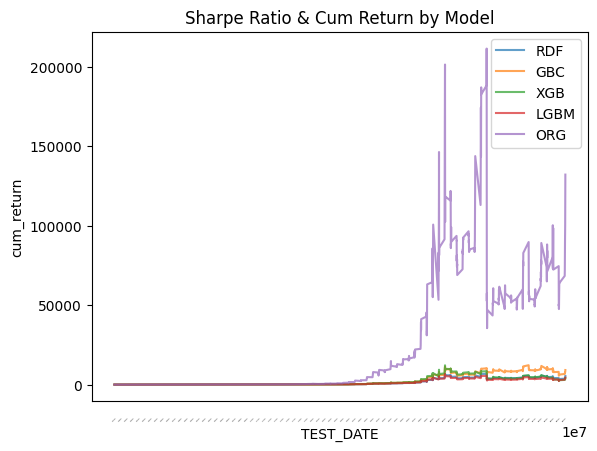

In [144]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Fixed_RDF_Result, Fixed_GBC_Result, Fixed_XGB_Result, Fixed_LGBM_Result],
                     [RDF_F_CUM_RETURN_dynamic, GBC_F_CUM_RETURN_dynamic, XGB_F_CUM_RETURN_dynamic, LGBM_F_CUM_RETURN_dynamic],
                     dynamic=True)

### Rolling Expanding Windows

#### Static

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.6727  최종 누적 수익률 : 13659.69116701071
GBC Sharpe Ratio : 0.7553  최종 누적 수익률 : 65592.85289025333
XGB Sharpe Ratio : 0.7098  최종 누적 수익률 : 18008.549389590215
LGBM Sharpe Ratio : 0.6580  최종 누적 수익률 : 8925.439845235775


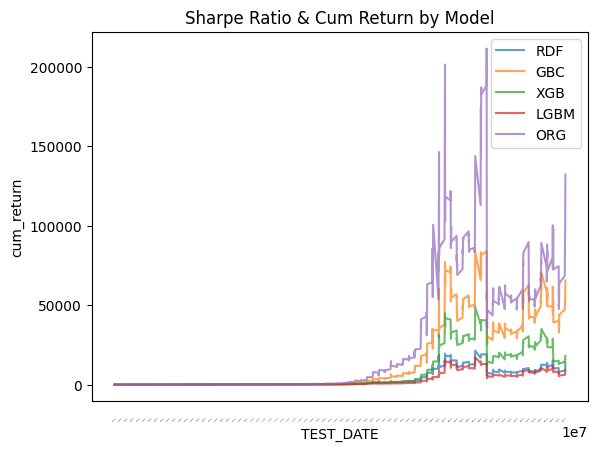

In [145]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_static, GBC_E_CUM_RETURN_static, XGB_E_CUM_RETURN_static, LGBM_E_CUM_RETURN_static],
                     dynamic=False)

#### Dynamic

ORG Sharpe Ratio : 0.7293  최종 누적 수익률 : 132103.15024526353
RDF Sharpe Ratio : 0.8040  최종 누적 수익률 : 8759.48219766808
GBC Sharpe Ratio : 0.7622  최종 누적 수익률 : 6038.223189186367
XGB Sharpe Ratio : 0.7558  최종 누적 수익률 : 10267.423949128262
LGBM Sharpe Ratio : 0.7533  최종 누적 수익률 : 7211.098863617375


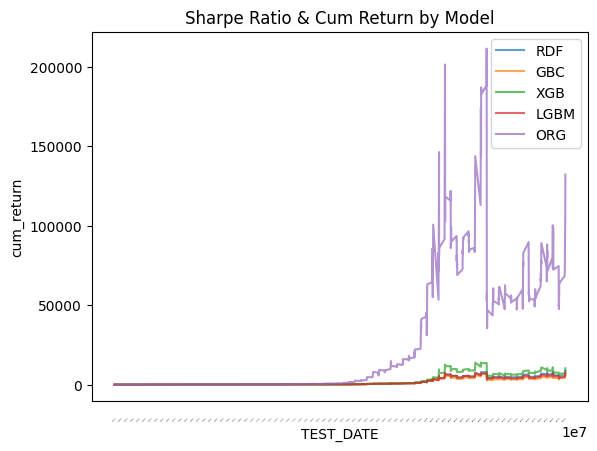

In [146]:
compare_sharpe_ratio(['RDF', 'GBC', 'XGB', 'LGBM'],
                     [Expanding_RDF_Result, Expanding_GBC_Result, Expanding_XGB_Result, Expanding_LGBM_Result],
                     [RDF_E_CUM_RETURN_dynamic, GBC_E_CUM_RETURN_dynamic, XGB_E_CUM_RETURN_dynamic, LGBM_E_CUM_RETURN_dynamic],
                     dynamic=True)